In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import corner
import imageio as iio
from datetime import date

## Data collection: GALAH DR4 x Globular Cluster List

In [5]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../spectrum_post_processing/galah_dr4_allstar_plxcom_not_validated.fits')
# galah_dr4_raw = galah_dr4_allspec[galah_dr4_allspec['best_spec4star']]#Table.read('../spectrum_post_processing/galah_dr4_allstar_not_validated.fits')
galah_dr4_raw['source_id'] = galah_dr4_raw['gaiadr3_source_id']
galah_dr4_raw = galah_dr4_raw[galah_dr4_raw['chi2_sp'] < 3]
# Read in your favourite Globular Cluster list. Keep in mind that we need tmass_id or gaia source_id as identifier
cluster_list = Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_cluster_source_id_memberprob0p7.fits')

# Join them with the keyword
data = join(galah_dr4_raw, cluster_list, keys='source_id')

In [6]:
# # 5000_2.00_-1.00 1587 TRUE
# # 5000_2.00_-0.75 1588 TRUE
# # 5000_3.00_-0.75 1612 TRUE

# rerun = (
#     (data['flag_sp_fit'] > 0) & 
#     (
#         (data['closest_model'] == '5000_2.00_-1.00') |
#         (data['closest_model'] == '5000_2.00_-0.75') |
#         (data['closest_model'] == '5000_3.00_-0.75')
#     )
# )
# np.savetxt('../spectrum_analysis/batches/rerun_gc1',data['sobject_id'][rerun],fmt='%s')
# s = np.unique([str(x)[:6] for x in data['sobject_id'][rerun]])
# s.sort()
# s

In [7]:
flagged = data['flag_sp_fit'] >= 1
model, counts = np.unique(data['closest_model'][flagged],return_counts=True)
mc = Table()
mc['model'] = model
mc['counts'] = counts
mc.sort(keys='counts',reverse=True)
mc

<Table length=78>
     model      counts
    bytes16     int64 
--------------- ------
5000_3.00_-1.50     19
7750_4.00_-1.00     12
5000_3.00_-2.00      5
7750_4.00_-0.75      5
7750_3.50_-1.00      5
7750_3.50_-0.75      5
5250_3.50_-1.00      5
4250_2.00_-1.00      5
 4000_3.00_0.75      5
5500_2.50_-1.50      4
            ...    ...
5750_3.00_-0.50      1
5500_4.00_-1.00      1
5500_2.50_-2.50      1
5500_2.50_-2.00      1
5250_3.50_-1.50      1
 4750_3.50_0.50      1
4750_3.00_-2.50      1
 4500_3.00_0.50      1
4500_2.50_-1.00      1
 3200_1.00_0.00      1

In [8]:
cluster_names, member_counts = np.unique(data['cluster'], return_counts=True)
clusters = Table()
clusters['cluster'] = cluster_names
clusters['members'] = member_counts
clusters

<Table length=18>
   cluster    members
   bytes15     int64 
------------- -------
       BH_140       1
          E_3       5
NGC_104_47Tuc     417
     NGC_1851      20
      NGC_288      56
      NGC_362      14
NGC_4590_M_68       1
NGC_5139_oCen     426
     NGC_5986       1
 NGC_6121_M_4     154
     NGC_6144       2
     NGC_6362      12
     NGC_6397      23
     NGC_6541       1
     NGC_6584       1
     NGC_6723       3
 NGC_7089_M_2      12
NGC_7099_M_30      24

In [9]:
clusters = clusters[clusters['members'] > 4]

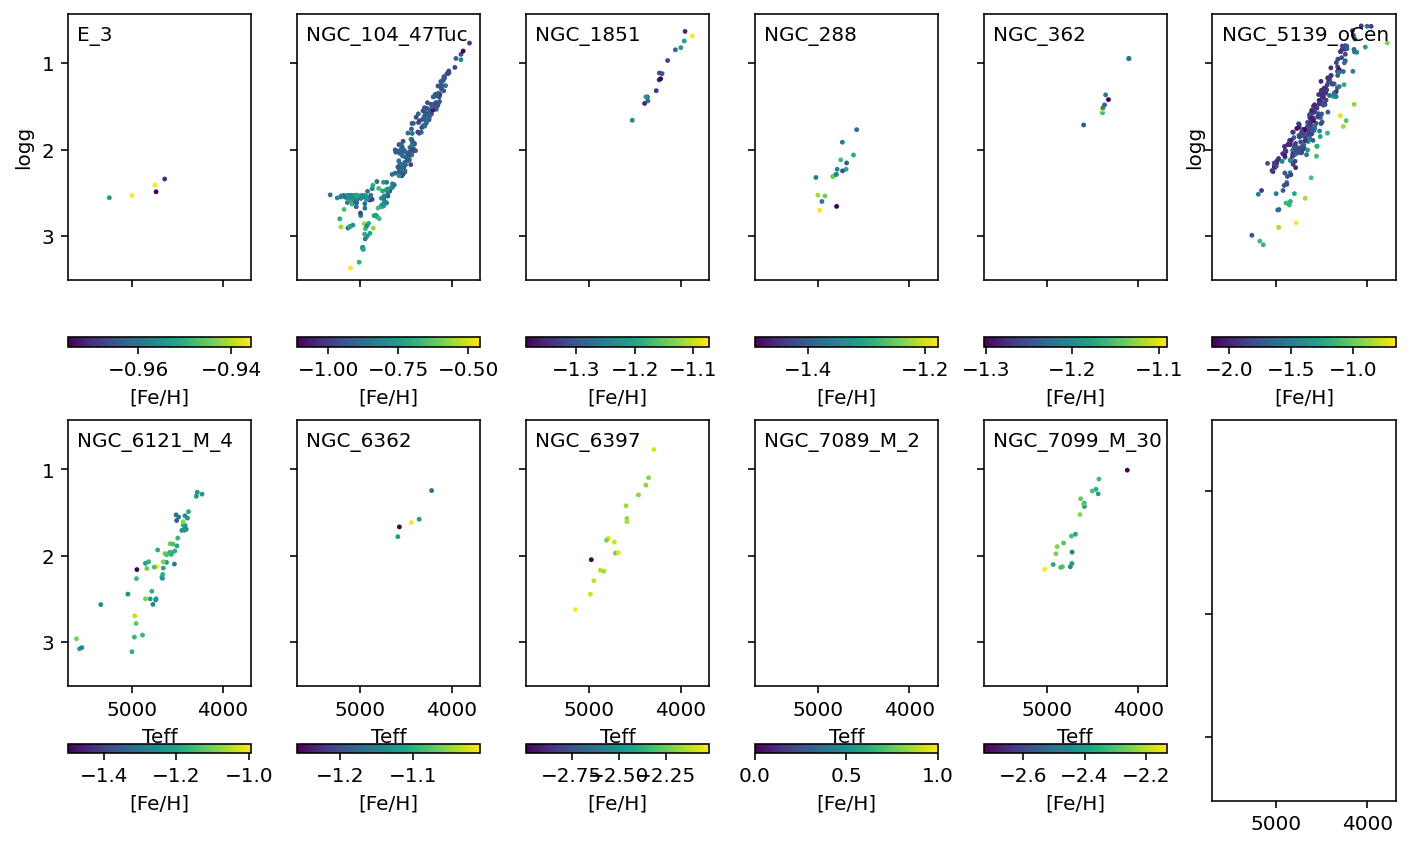

In [10]:
def plot_hrd_all_cluster(data, cluster_names):

#     f, gs = plt.subplots(2,4,figsize=(10,4),sharex=True,sharey=True)
    
#     for cluster_index in range(len(cluster_names)):
        
#         # Preparation of the individual panels
#         if cluster_index < int(len(cluster_names) / 2):
#             ax = gs[0,cluster_index]
#             if cluster_index == 0:
#                 ax.set_ylabel('logg')
#         else:
#             ax = gs[1,cluster_index - int(len(cluster_names) / 2)]
#             if cluster_index == int(len(cluster_names) / 2):
#                 ax.set_ylabel('logg')
#             ax.set_xlabel('Teff')
            
#         ax.text(0.05,0.9,cluster_names[cluster_index],transform=ax.transAxes)
    
#         select_unflagged_stars_in_cluster = (
#             (data['cluster'] == cluster_names[cluster_index]) & 
#             (data['flag_sp'] == 0)
#         )
        
#         # Plot a teff-logg diagram color-coded by [Fe/H]
#         s = ax.scatter(
#             data['teff'][select_unflagged_stars_in_cluster],
#             data['logg'][select_unflagged_stars_in_cluster],
#             c = 'k',
#             s = 2
#         )
        
#         select_flagged_stars_in_cluster = (
#             (data['cluster'] == cluster_names[cluster_index]) & 
#             (data['flag_sp'] > 0)
#         )
        
#         # Plot a teff-logg diagram color-coded by [Fe/H]
#         s = ax.scatter(
#             data['teff'][select_flagged_stars_in_cluster],
#             data['logg'][select_flagged_stars_in_cluster],
#             c = 'r',
#             s = 2
#         )

#     # Invert x- and y-axis
#     ax.set_xlim(ax.get_xlim()[::-1])
#     ax.set_ylim(ax.get_ylim()[::-1])

#     plt.tight_layout(w_pad=0,h_pad=0)
#     plt.show()
#     plt.close()
    
    f, gs = plt.subplots(2,6,figsize=(10,6),sharex=True,sharey=True)
    
    for cluster_index in range(len(cluster_names)):
        
        # Preparation of the individual panels
        if cluster_index < 6:
            ax = gs[0,cluster_index]
#         elif cluster_index < 6:
#             ax = gs[1,cluster_index-3]
        else:
            ax = gs[1,cluster_index-6]
            ax.set_xlabel('Teff')
        if cluster_index in [0,5]:
            ax.set_ylabel('logg')
            
        ax.text(0.05,0.9,cluster_names[cluster_index],transform=ax.transAxes)
    
        select_unflagged_stars_in_cluster = (
            (data['cluster'] == cluster_names[cluster_index]) & 
            (data['flag_sp'] == 0)
        )
        
        # Plot a teff-logg diagram color-coded by [Fe/H]
        s = ax.scatter(
            data['teff'][select_unflagged_stars_in_cluster],
            data['logg'][select_unflagged_stars_in_cluster],
            c = data['fe_h'][select_unflagged_stars_in_cluster],
            s = 2
        )
        # Add the colorbar for [Fe/H]
        cbar = plt.colorbar(s, ax=ax,orientation='horizontal')
        cbar.set_label('[Fe/H]')

    # Invert x- and y-axis
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])

    plt.tight_layout(w_pad=0,h_pad=0)
    plt.show()
    plt.close()
    
plot_hrd_all_cluster(data,clusters['cluster'])

In [11]:
parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
unique_ages = np.unique(parsec['logAge'])
unique_m_h = np.unique(parsec['m_h'])

In [15]:
# Using Forbes & Bridges (2010) ages, but GALAH DR4 [Fe/H]
isochrones_dr4 = dict()
isochrones = dict()

globular_clusters = Table.read('../auxiliary_information/GlobularClustersGALAHDR4.fits')

for cluster_name in cluster_names:

    in_cluster_good = (data['cluster'] == cluster_name) & (data['flag_sp'] == 0) & (data['flag_fe_h'] == 0) & (data['flag_mg_fe'] == 0)
    match = np.where(cluster_name == globular_clusters['Cluster'])[0]
    
    if len(data['cluster'][in_cluster_good]) > 0:

        fe_h_p16,fe_h_p50,fe_h_p84 = np.percentile(data['fe_h'][in_cluster_good],q=[16,50,84])
        print('\n'+cluster_name+': '+str(len(data['cluster'][in_cluster_good]))+' members')
        mg_fe_p16,mg_fe_p50,mg_fe_p84 = np.percentile(data['mg_fe'][in_cluster_good],q=[16,50,84])
        m_h_p16,m_h_p50,m_h_p84 = np.percentile(data['fe_h'][in_cluster_good] + np.log10(0.694*10**data['mg_fe'][in_cluster_good] + 0.306),q=[16,50,84])

        print('\n  [Fe/H]:  ',np.round(fe_h_p50,decimals=2),np.round(fe_h_p50-fe_h_p16,decimals=2),np.round(fe_h_p84-fe_h_p50,decimals=2))
        if len(match) > 0:
            print('    lit.:  ',globular_clusters['fe_h'][match[0]],globular_clusters['fe_h_source'][match[0]])
        print('\n  [Mg/Fe]:  ',np.round(mg_fe_p50,decimals=2),np.round(mg_fe_p50-mg_fe_p16,decimals=2),np.round(mg_fe_p84-mg_fe_p50,decimals=2))
        print('\n  [M/H]:   ',np.round(m_h_p50,decimals=2),np.round(m_h_p50-m_h_p16,decimals=2),np.round(m_h_p84-m_h_p50,decimals=2))
        if len(match) > 0:
            print('   lit.:   ',globular_clusters['m_h'][match[0]],globular_clusters['m_h_source'][match[0]])
            print('\n  Age:  ',str(globular_clusters['age'][match[0]])+' Gyr ('+globular_clusters['age_source'][match[0]]+')')

        print('\n----')
            
        isochrones_dr4[cluster_name] = parsec[
            (parsec['m_h'] == unique_m_h[np.argmin(np.abs(unique_m_h - (m_h_p50)))]) &
            (parsec['logAge'] == unique_ages[np.argmin(np.abs(10**unique_ages/10**9. - globular_clusters['age'][match[0]]))])
        ][:-5]
        
    else:
        print('\n'+cluster_name+': '+str(len(data['cluster'][in_cluster_good]))+' members')
        print('[Fe/H] lit.:  ',globular_clusters['fe_h'][match[0]],globular_clusters['fe_h_source'][match[0]])
        print('[M/H]  lit.:   ',globular_clusters['m_h'][match[0]],globular_clusters['m_h_source'][match[0]])
        print('Age:  ',str(globular_clusters['age'][match[0]])+' Gyr ('+globular_clusters['age_source'][match[0]]+')')

    isochrones[cluster_name] = parsec[
        (parsec['m_h'] == unique_m_h[np.argmin(np.abs(unique_m_h - (globular_clusters['m_h'][match[0]])))]) &
        (parsec['logAge'] == unique_ages[np.argmin(np.abs(10**unique_ages/10**9. - globular_clusters['age'][match[0]]))])
    ][:-5]


BH_140: 0 members
[Fe/H] lit.:   -1.5 NA
[M/H]  lit.:    -1.3 NA
Age:   10.0 Gyr (NA)

E_3: 5 members

  [Fe/H]:   -0.95 0.02 0.02
    lit.:   -0.83 M09

  [Mg/Fe]:   0.39 0.06 0.02

  [M/H]:    -0.67 0.03 0.04
   lit.:    -0.69 M09

  Age:   12.8 Gyr (M09)

----

NGC_104_47Tuc: 236 members

  [Fe/H]:   -0.9 0.05 0.08
    lit.:   -0.78 M09

  [Mg/Fe]:   0.41 0.06 0.08

  [M/H]:    -0.56 0.07 0.08
   lit.:    -0.64 M09

  Age:   13.06 Gyr (M09)

----

NGC_1851: 16 members

  [Fe/H]:   -1.3 0.05 0.09
    lit.:   -1.03 M09

  [Mg/Fe]:   0.41 0.08 0.07

  [M/H]:    -0.96 0.06 0.07
   lit.:    -0.81 M09

  Age:   9.98 Gyr (M09)

----

NGC_288: 15 members

  [Fe/H]:   -1.34 0.03 0.08
    lit.:   -1.14 M09

  [Mg/Fe]:   0.42 0.11 0.05

  [M/H]:    -1.01 0.06 0.1
   lit.:    -0.92 M09

  Age:   10.62 Gyr (M09)

----

NGC_362: 9 members

  [Fe/H]:   -1.22 0.02 0.05
    lit.:   -1.09 M09

  [Mg/Fe]:   0.34 0.13 0.08

  [M/H]:    -0.98 0.06 0.08
   lit.:    -0.87 M09

  Age:   10.37 Gyr (M09)

-

In [16]:
def plot_galah_dr4_overview_cluster(cluster_name):
    elements = [
        'Li',
        'C',
        'N',
        'O',
        'Na',
        'Mg',
        'Al',
        'Si',
        'K',
        'Ca',
        'Sc',
        'Ti',
        'V',
        'Cr',
        'Mn',
        'Co',
        'Ni',
        'Cu',
        'Zn',
        'Rb',
        'Sr',
        'Y',
        'Zr',
        'Mo',
        'Ru',
        'Ba',
        'La',
        'Ce',
        'Nd',
        'Sm',
        'Eu'
        ]
    
    in_cluster = (data['cluster'] == cluster_name)

    if len(data['cluster'][in_cluster]) > 2:

        fig, axs = plt.subplots(ncols=6, nrows=6, figsize=(11.75,8.25))
        gs = axs[0, 0].get_gridspec()
        for ax in axs[0, :2]:
            ax.remove()
        for ax in axs[1, :2]:
            ax.remove()

        # HRD 

        flag_sp_0 = (data['flag_sp'] == 0) & (data['cluster'] == cluster_name)
        flag_sp_above0_but_results = (data['flag_sp'] > 0) & (data['flag_sp'] < np.max(data['flag_sp'])) & (data['cluster'] == cluster_name)
        flag_sp_results = (data['flag_sp'] < np.max(data['flag_sp'])) & (data['cluster'] == cluster_name)

        teff_limits = [3750,7250]
        logg_limits = [-0.25,5.5]

        axbig = fig.add_subplot(gs[:2, :2])
        s = axbig.scatter(
            data['teff'][flag_sp_0],
            data['logg'][flag_sp_0],
            c = data['teff'][flag_sp_0], cmap='plasma',
            s = 2, vmin = 4000, vmax = 6000
        )

        axbig.plot(
            10**isochrones[cluster_name]['logT'],
            isochrones[cluster_name]['logg'], ls='dotted', c='k', lw=1
        )
        try:
            axbig.plot(
                10**isochrones_dr4[cluster_name]['logT'],
                isochrones_dr4[cluster_name]['logg'], ls='dashed', c='k', lw=1
            )
        except:
            pass

        axbig.set_xlim(teff_limits[1],teff_limits[0])
        axbig.set_ylim(logg_limits[1],logg_limits[0])
        axbig.text(0.5,0.93,cluster_name.replace('_',' ')+': '+str(len(data['teff'][flag_sp_0]))+'/'+str(len(data['teff'][in_cluster])),transform=axbig.transAxes,ha='center',bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))
        axbig.text(0.5,0.035,r'$T_\mathrm{eff}~/~\mathrm{K}$',transform=axbig.transAxes,ha='center',bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))
        axbig.text(0.02,0.5,r'$\log (g~/~\mathrm{cm\,s^{-2}})$',transform=axbig.transAxes,va='center',rotation=90,bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))
        cbar = plt.colorbar(s, ax=axbig)
        #cbar.set_label('[Fe/H]')


        # read an image
        img = iio.imread("../spectrum_post_processing/figures/logo_desktop.png")

        ax = axs[-1,-1]
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5,+1.2,'DR4 Preview',transform=ax.transAxes,ha='center')
        ax.text(0.6,-0.6,'Buder et al. \n as of '+date.today().strftime("%y%m%d"),transform=ax.transAxes,ha='center')

        for ind, label in enumerate(elements):    
            if ind <= 3:
                ax = axs[0,2+ind]
            elif ind <= 7:
                ax = axs[1,2+ind-4]
            elif ind <= 13:
                ax = axs[2,ind-8]
            elif ind <= 19:
                ax = axs[3,ind-14]
            elif ind <= 25:
                ax = axs[4,ind-20]
            elif ind <= 32:
                ax = axs[5,ind-26]
            else:
                raise ValueError('blob')
            if label == 'Li':
                color = '#2B292C'
            elif label in ['C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','Cu','Zn','Rb']:
                color = '#9AA2C9'
            elif label in ['V','Cr','Mn','Fe','Co','Ni']:
                color = '#E69774'
            elif label in ['N','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm']:
                color = '#C4DAAB'
            elif label in ['Eu']:
                color = '#D0A8C5'

            xbins = np.linspace(-2.5,0.75,50)
            if label == 'Li':
                ybins = np.linspace(-1,4,50)
            elif label in ['C','N','O','Y','Ba','La','Ce','Nd']:
                ybins = np.linspace(-1,2,50)
            elif label in ['Mg','Si','Ti']:
                ybins = np.linspace(-0.5,1,50)
            else:
                ybins = np.linspace(-1,1,50)

            # First panel: Detections for GALAH DR4 [Fe/H] vs. [X/Fe]
            if label == 'Li':
                textcolor = 'w'
                ax.set_yticks([-2,0,2])
            else:
                textcolor = 'k'

            flag0 = flag_sp_0 & (data['flag_'+label.lower()+'_fe'] == 0) #& (data['fe_h'] > -1)

            if label == 'Li':
                ax.text(0.05,0.83,'A('+label+')',ha='left',color=textcolor, transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor=color, alpha=0.75))
            else:
                ax.text(0.05,0.83,'['+label+'/Fe]',ha='left',color=textcolor, transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor=color, alpha=0.75))
            fraction = '0%'
            if len(data['e_fe_h'][flag0]) > 0:
                fraction = "{:.0f}".format(100*len(data['e_fe_h'][flag0])/len(data['teff'][flag_sp_0]))+'%'
            ax.text(0.97,0.05,fraction,ha='right', transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='square,pad=0',lw=0,facecolor='w', alpha=0.75))

            levels = (0.97,0.9,0.68,0.5,0.3)
            if label in ['La','Ce','Sm','Eu']:
                levels = (0.9,0.68,0.5,0.3)
            elif label in ['Rb','Sr','Mo','Ru']:
                levels = (0.5,0.3)

            ydata = data[label.lower()+'_fe'][flag0]
            if label == 'Li':
                ydata = data[label.lower()+'_fe'][flag0] + data['fe_h'][flag0] + 1.05

            ax.scatter(
                data['fe_h'][flag0],
                ydata,
                c = data['teff'][flag0], cmap='plasma',
                vmin = 4000,vmax = 6000,
                s = 2
            )
            ax.set_xlim(xbins[0],xbins[-1])
            ax.set_ylim(ybins[0],ybins[-1])

            ax.errorbar(
                0.9*xbins[0]+0.1*xbins[-1],
                0.9*ybins[0]+0.1*ybins[-1],
                xerr=np.ma.median(data['e_fe_h'][flag0]),
                yerr=np.ma.median(data['e_'+label.lower()+'_fe'][flag0]),
                capsize=2,color='k'
            )
            if ind >= 26:
                ax.set_xlabel('[Fe/H]')
        #     else:
            ax.set_xticks([-2,-1,0])
        plt.tight_layout(h_pad=0,w_pad=0)
        plt.savefig('figures/galah_dr4_overview_'+cluster_name+'.png',dpi=150,bbox_inches='tight')
        plt.show()
        plt.close()
    
    else:
        print(cluster_name,len(data['cluster'][in_cluster]))

BH_140 1


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


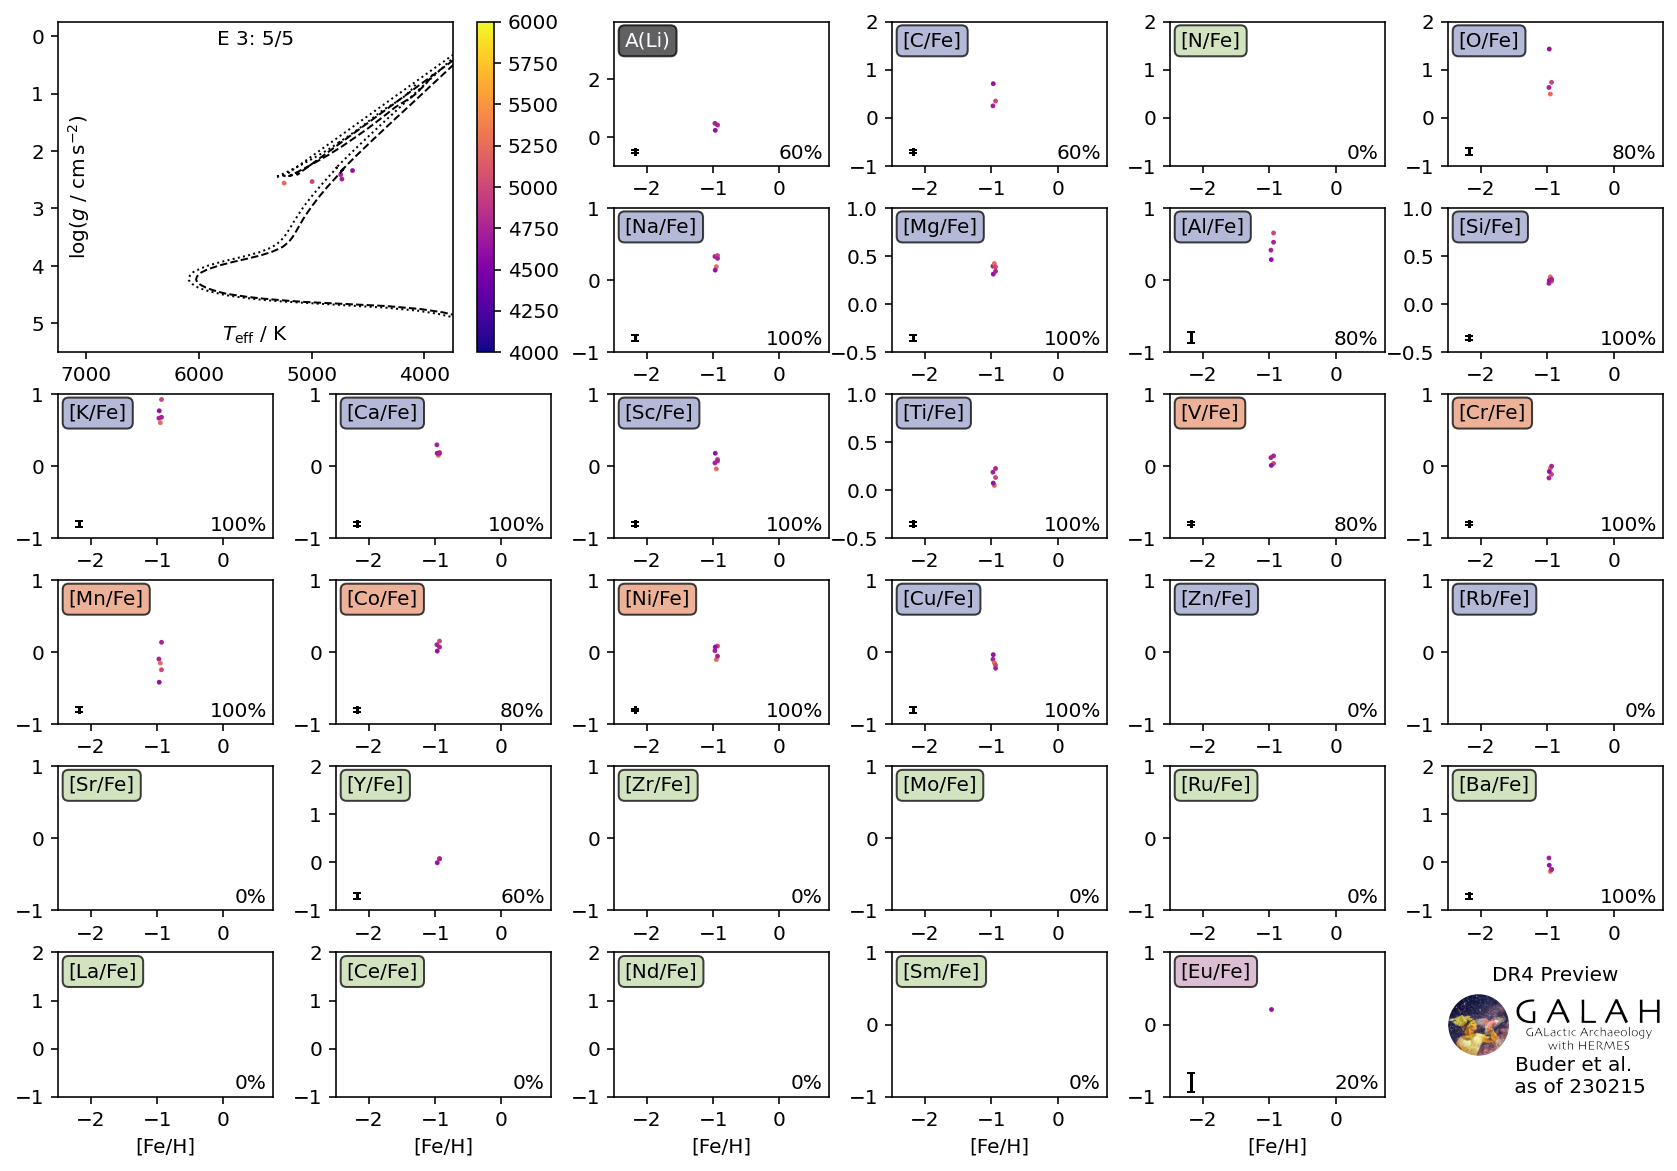

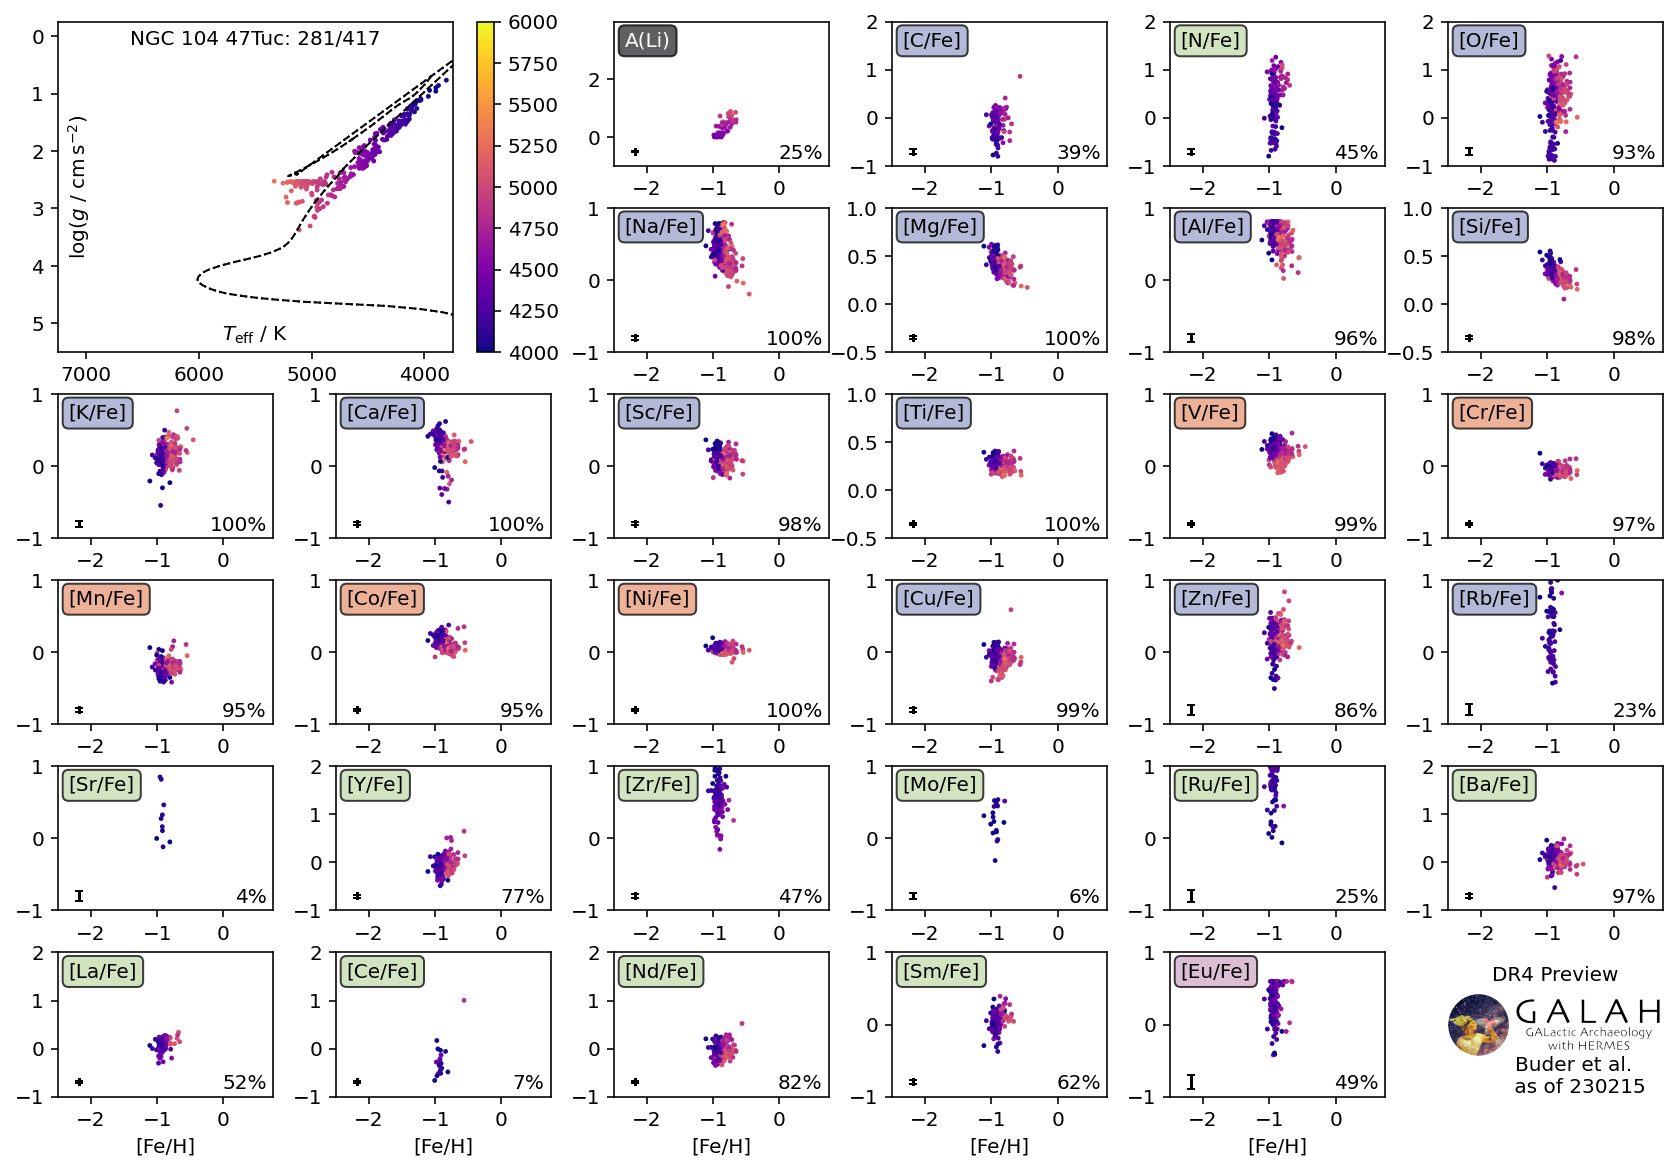

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


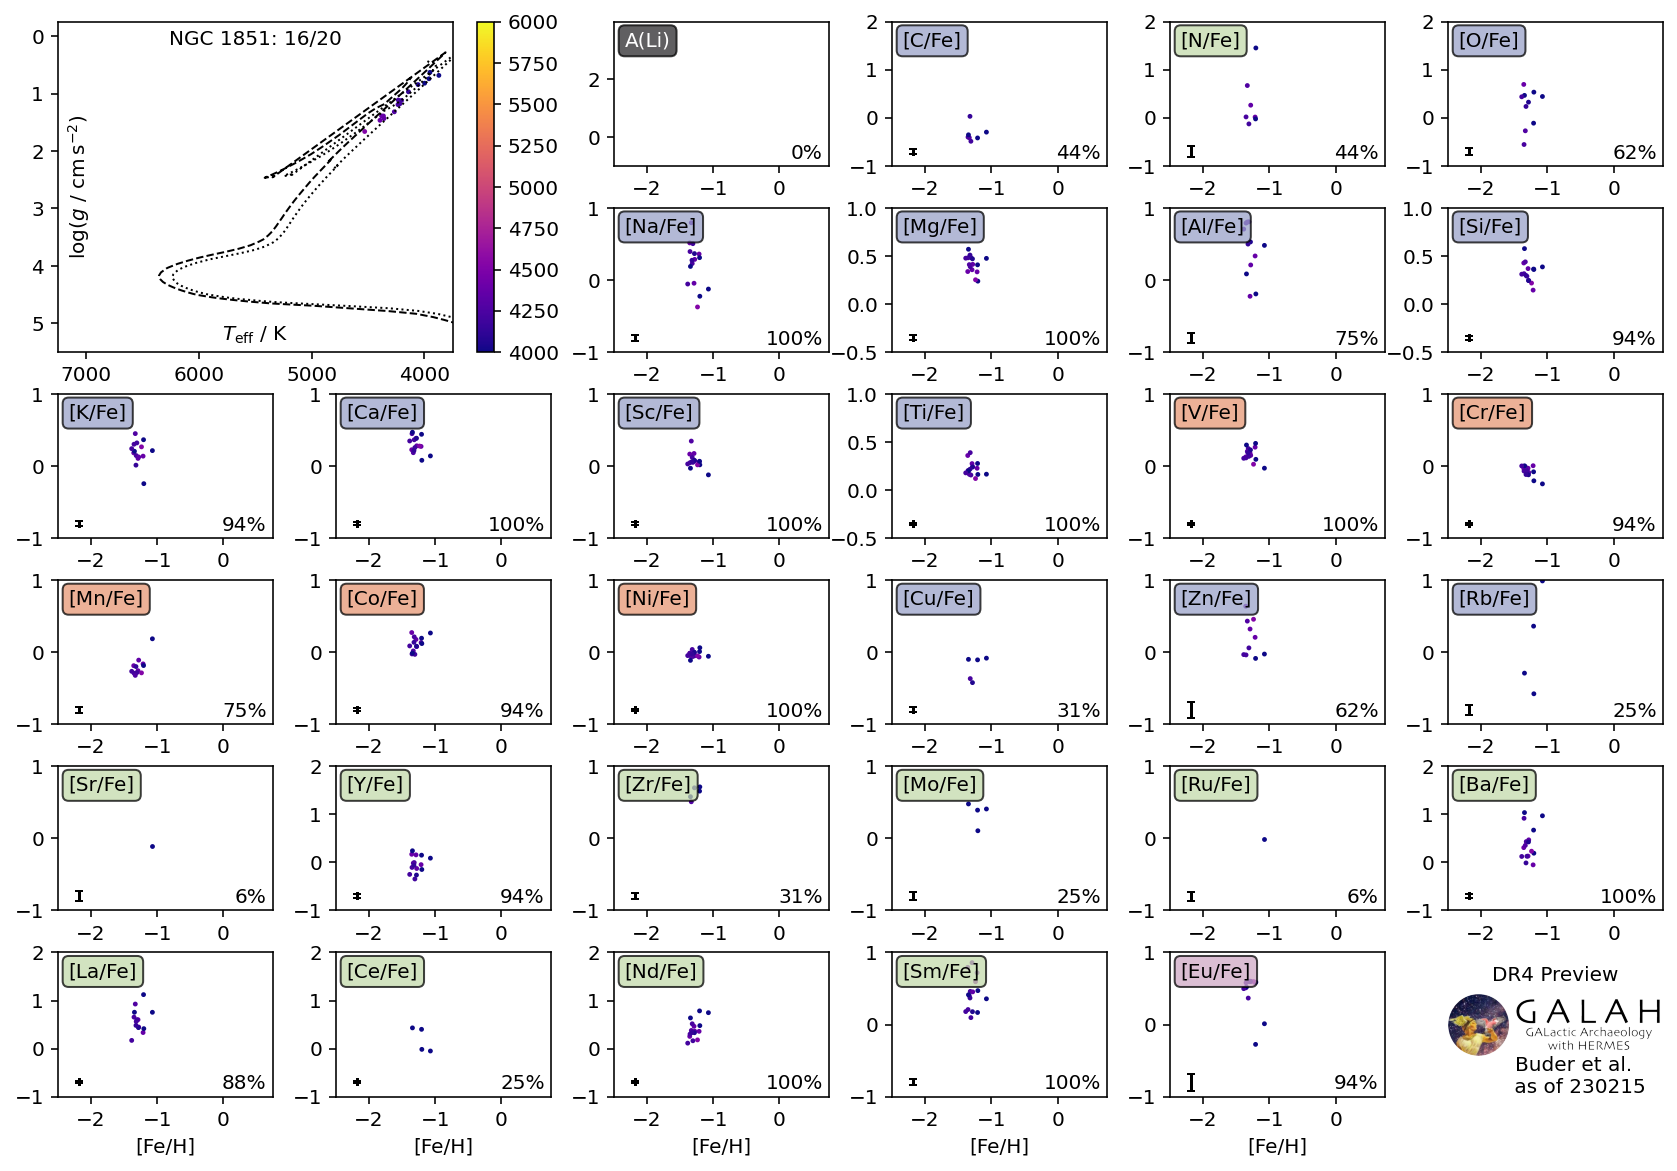

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


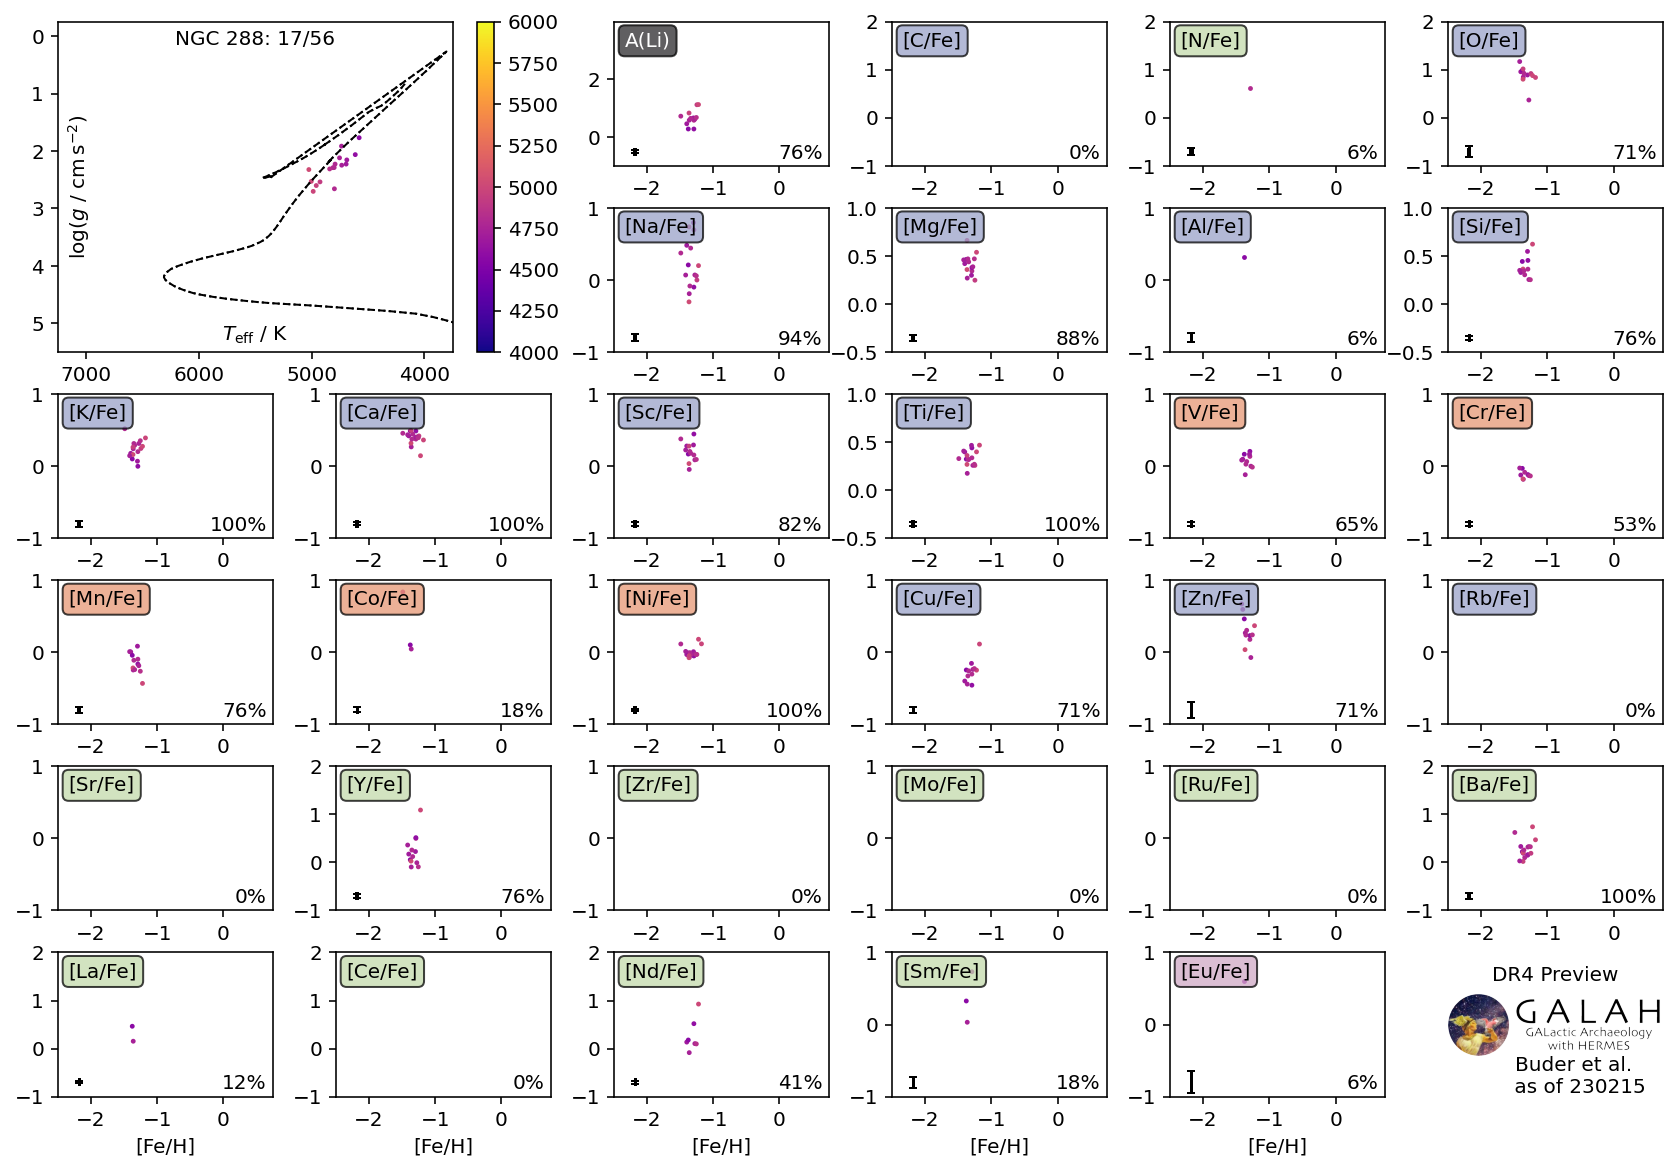

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


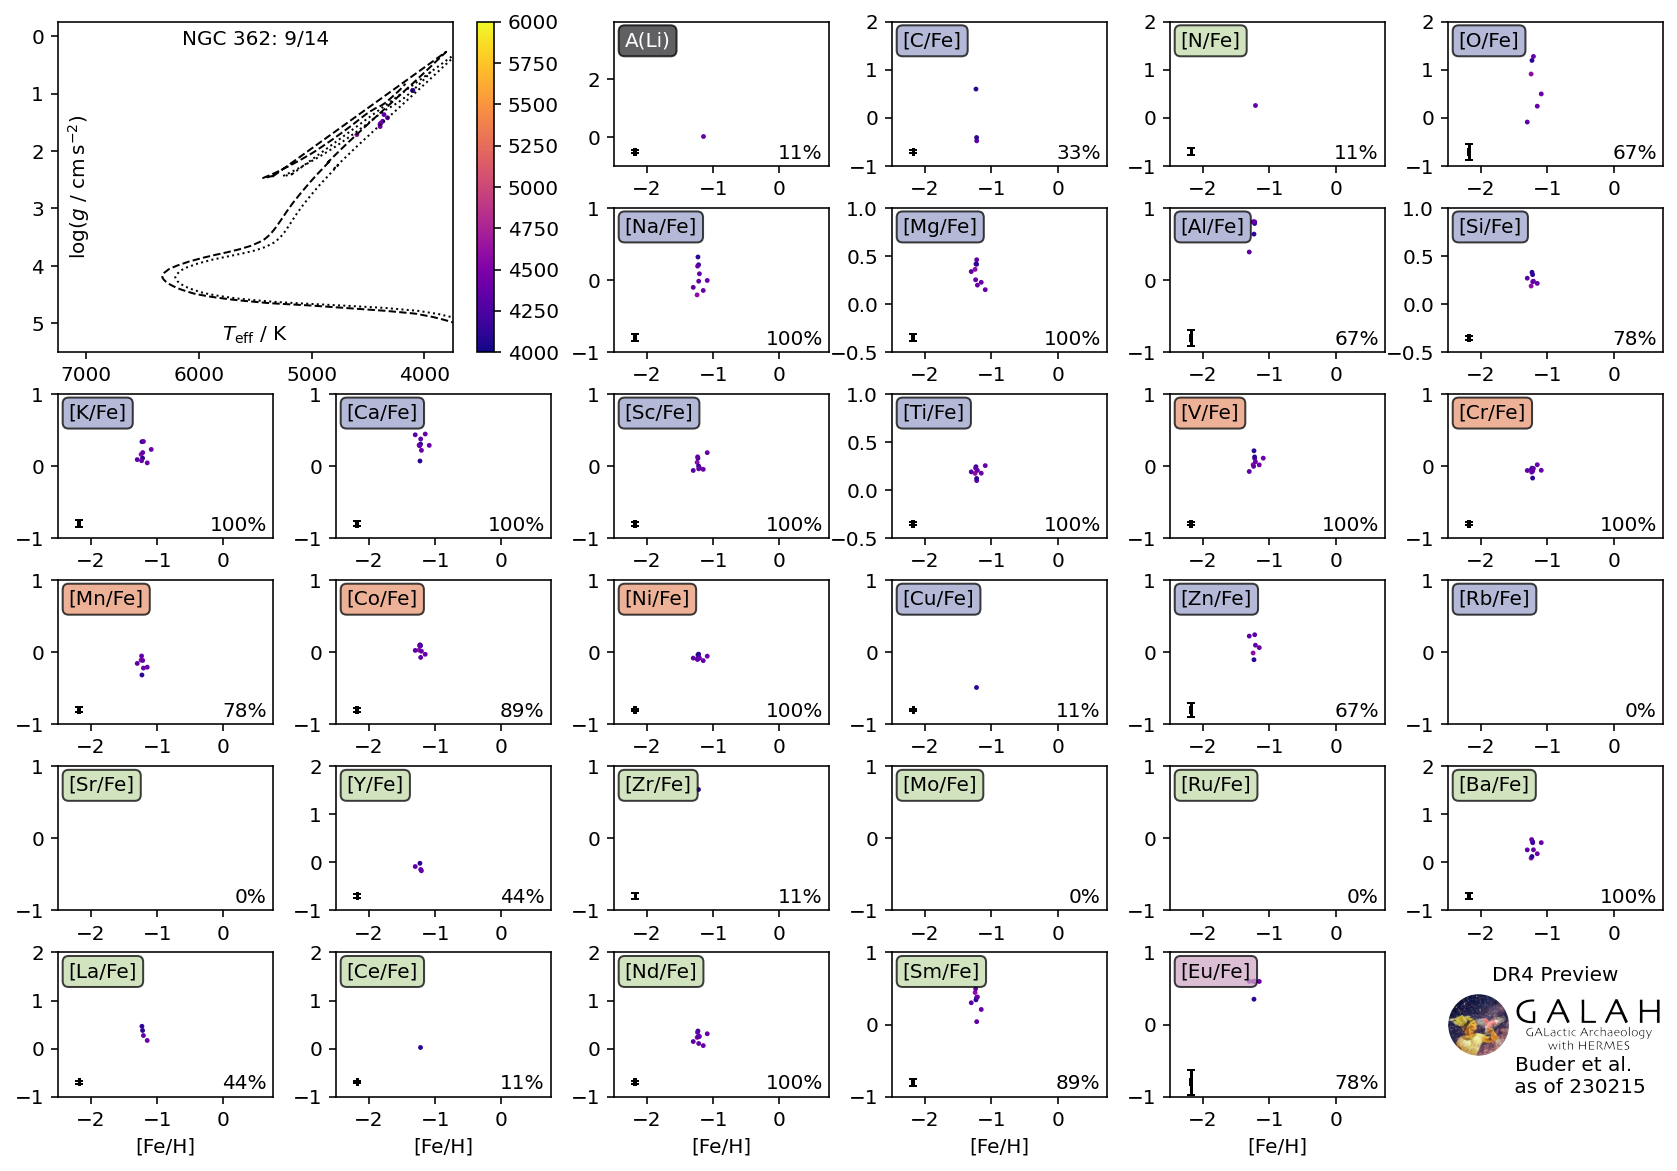

NGC_4590_M_68 1


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


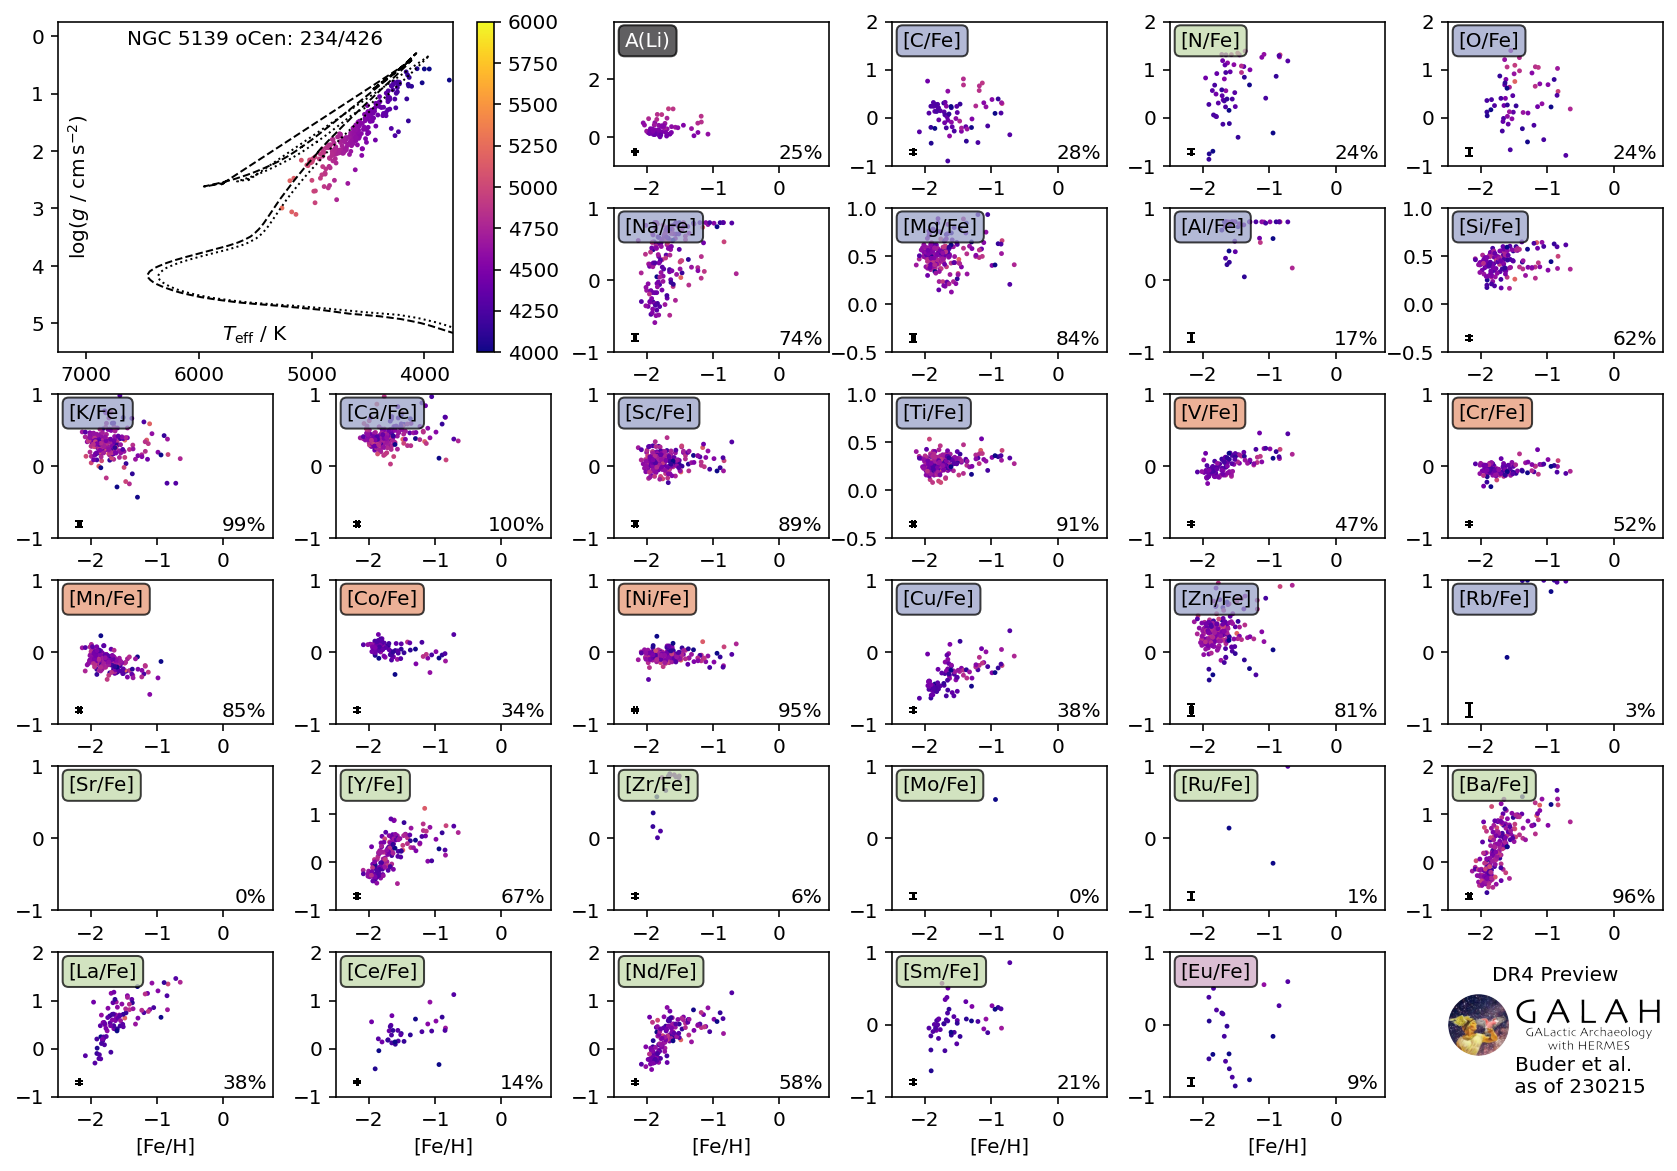

NGC_5986 1


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


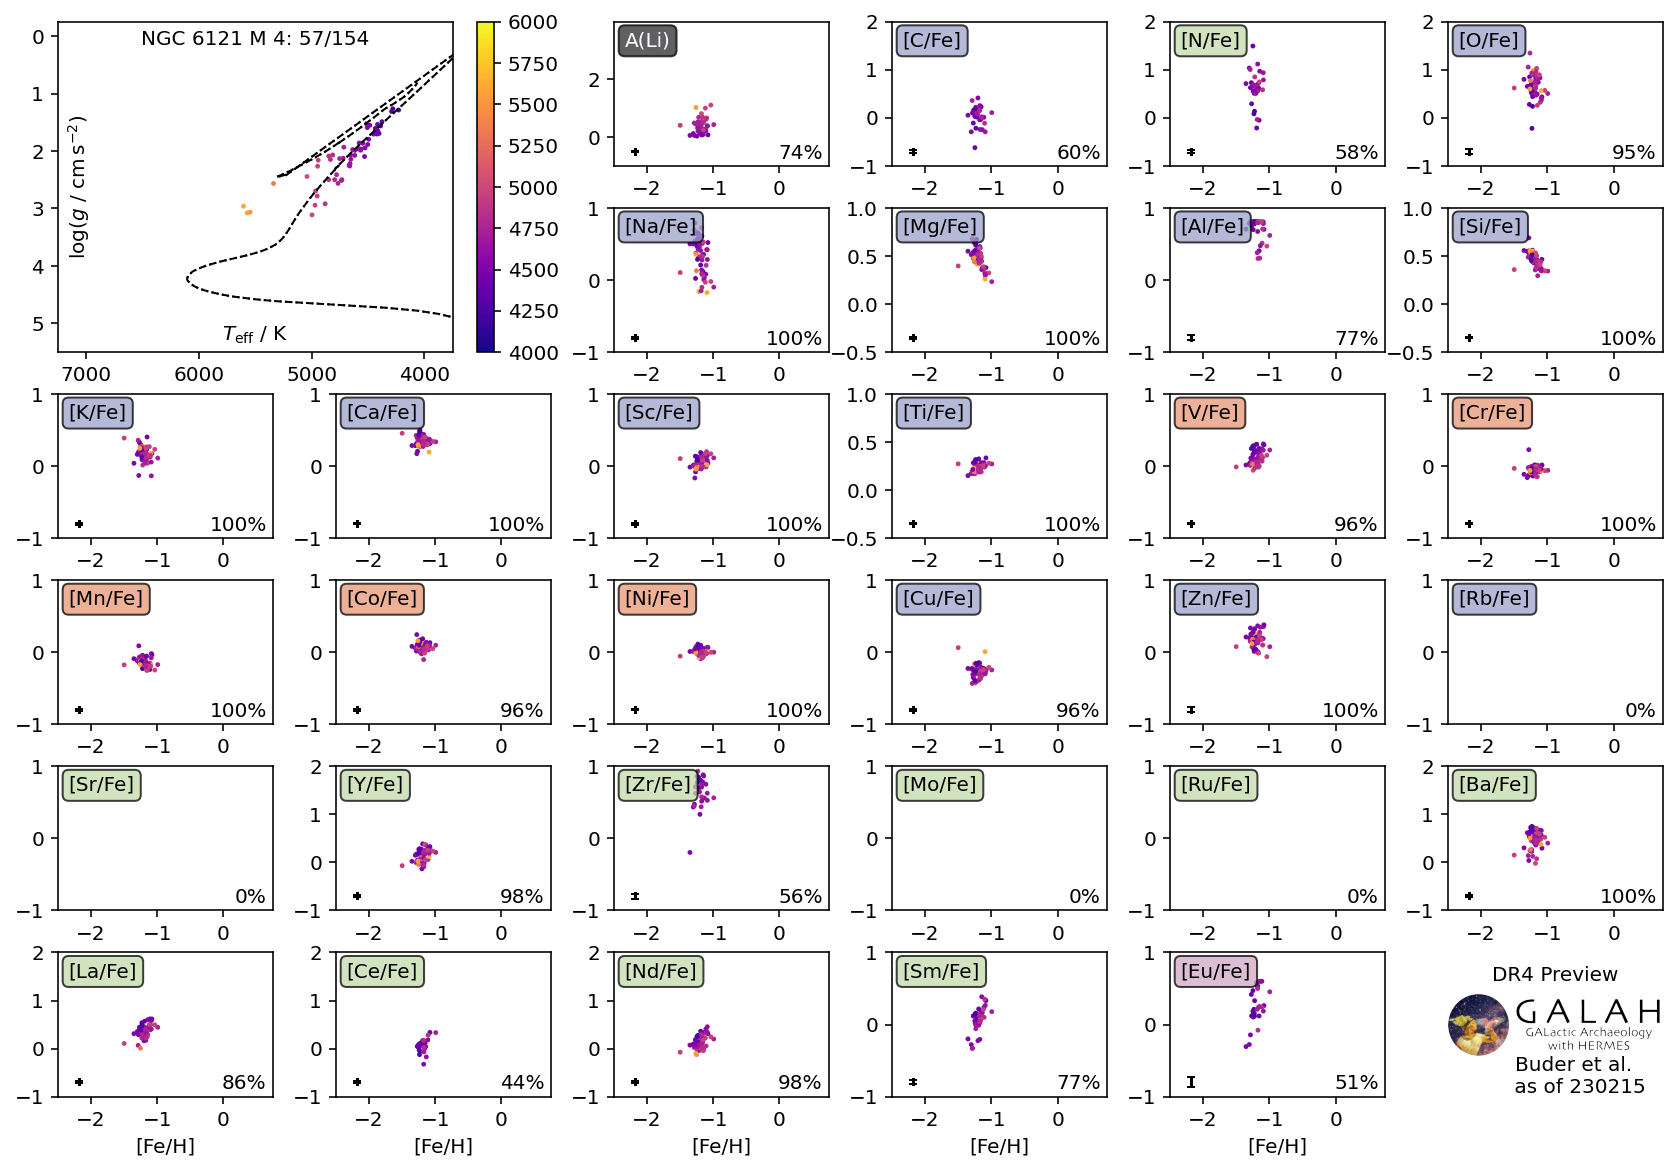

NGC_6144 2


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


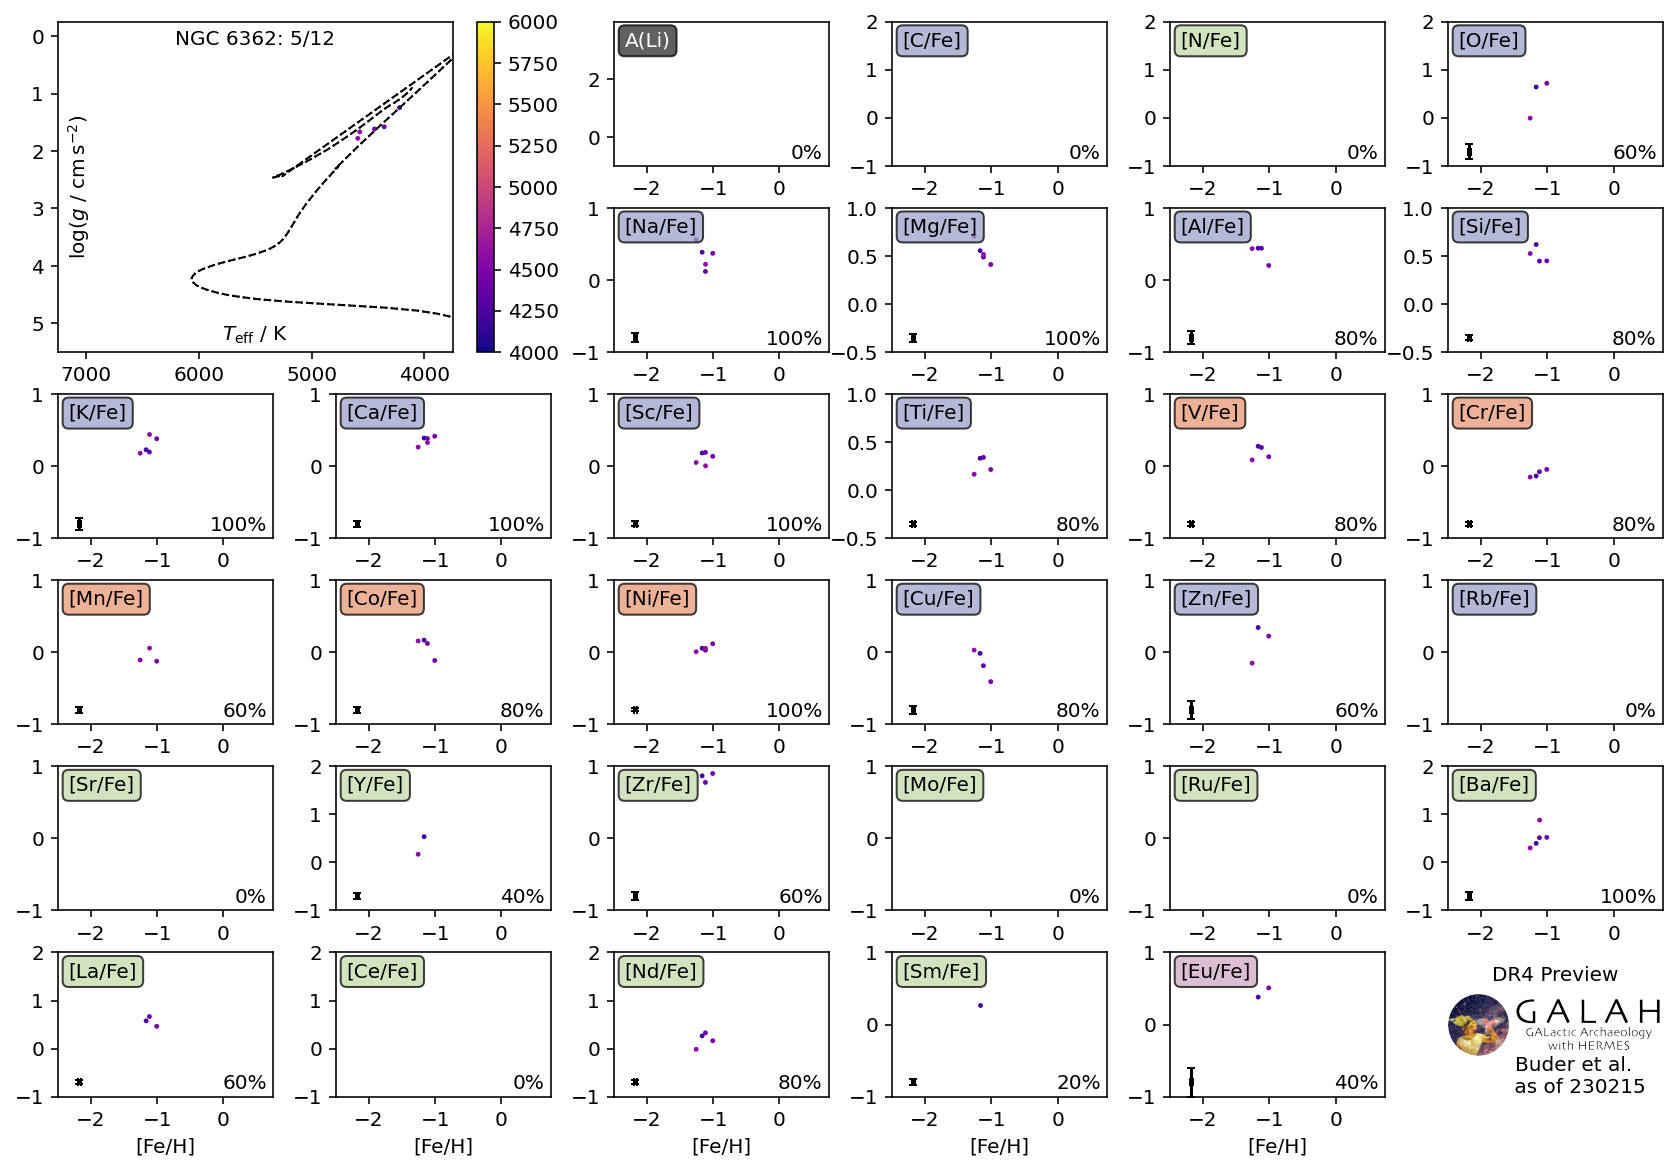

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


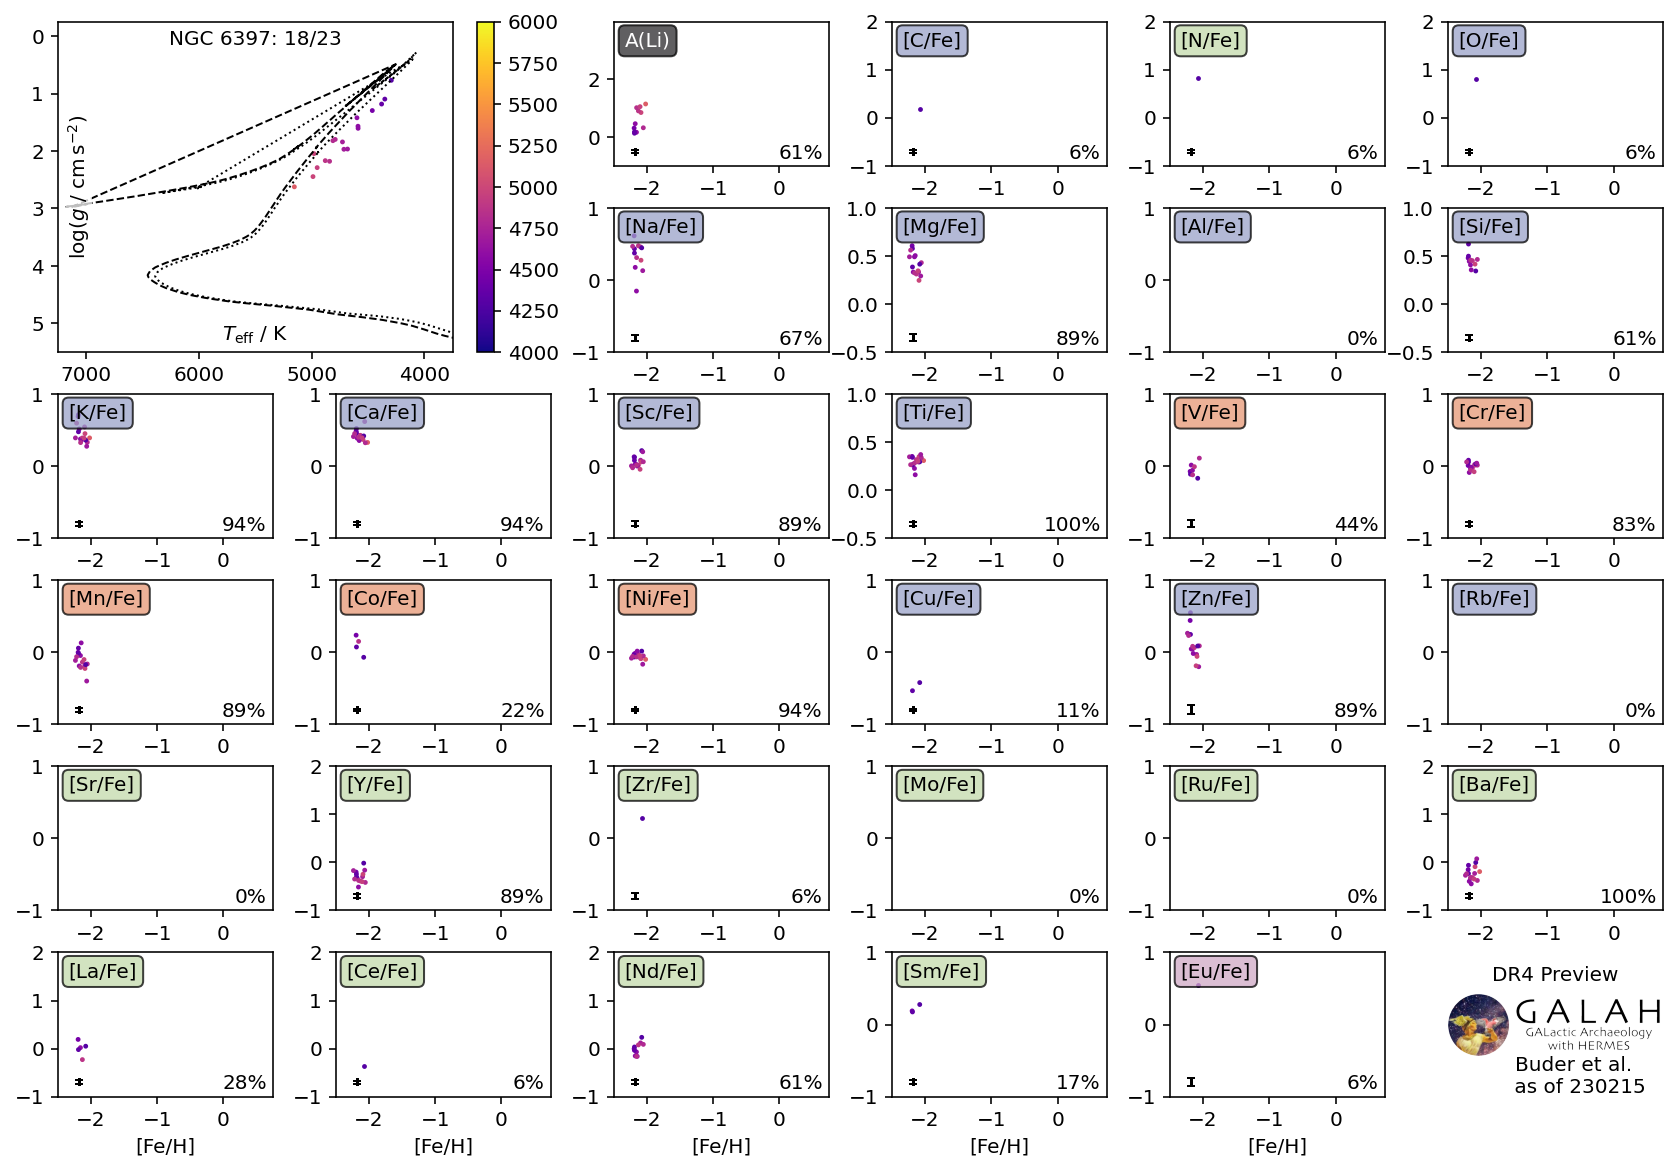

NGC_6541 1
NGC_6584 1


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


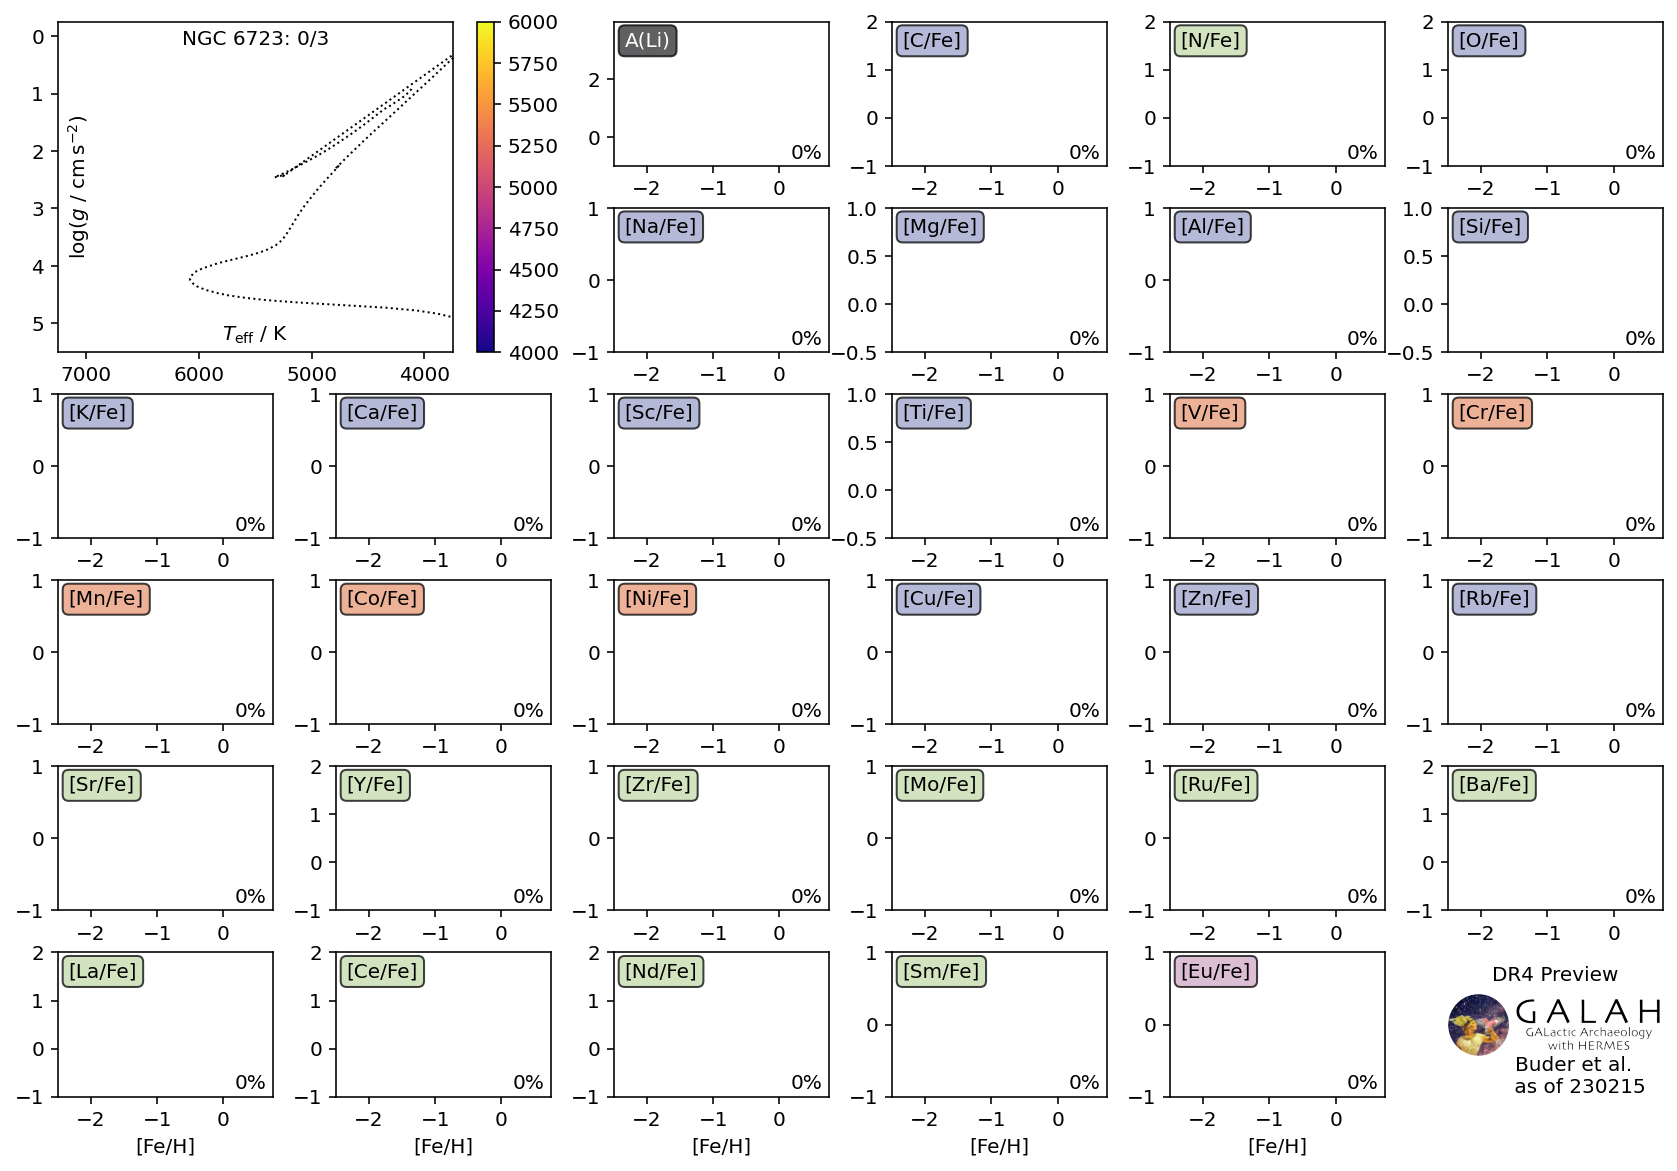

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


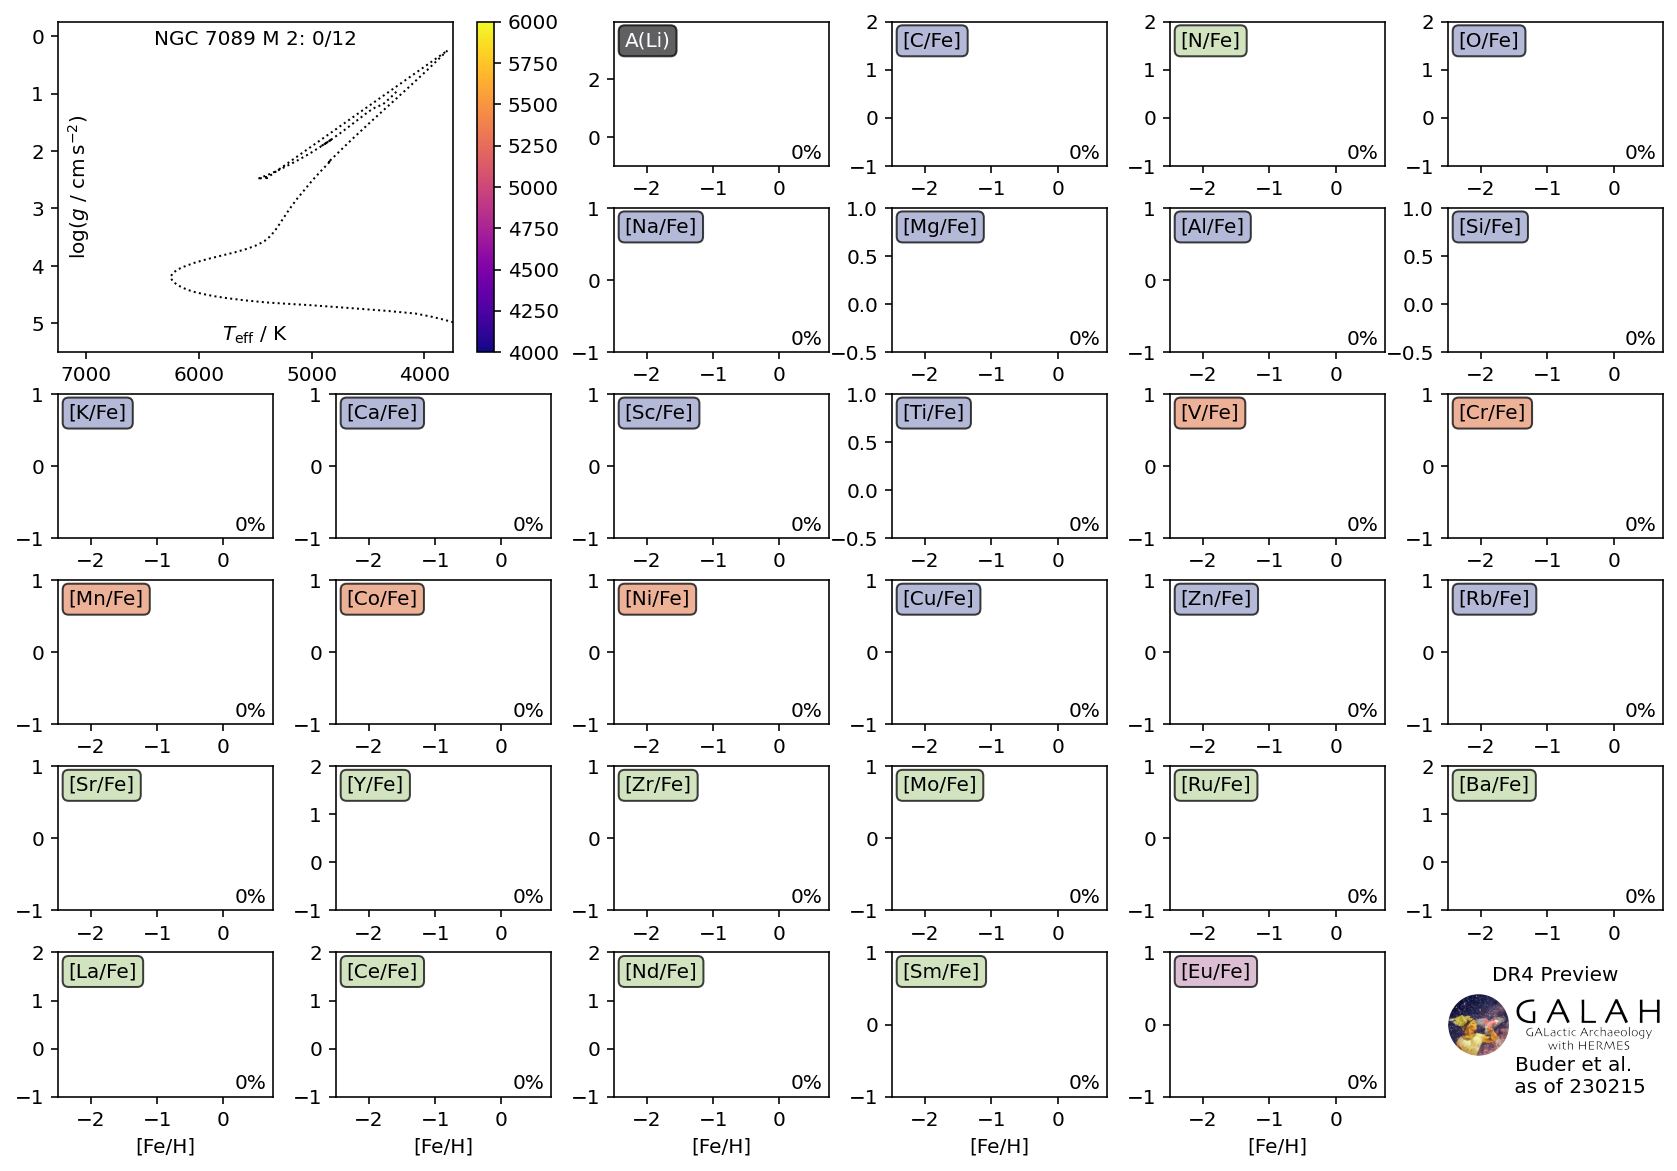

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


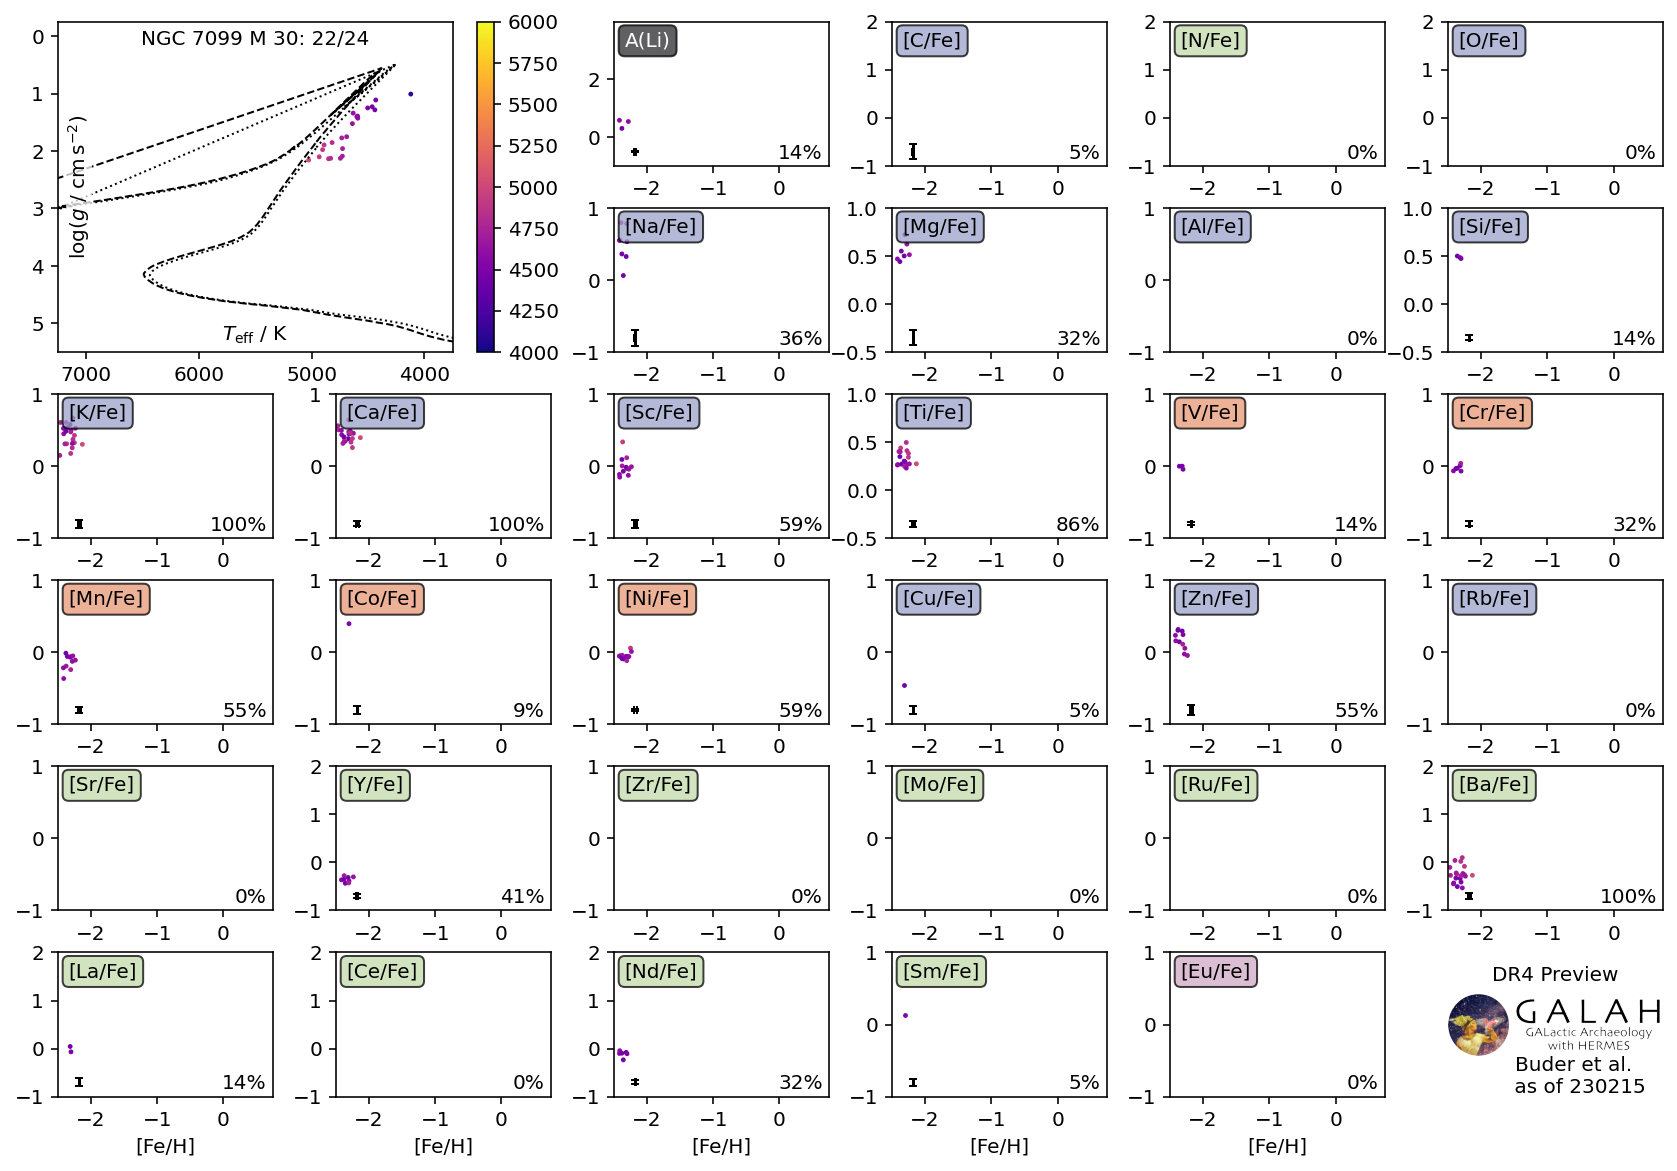

In [17]:
for cluster_name in cluster_names:
#     try:
    plot_galah_dr4_overview_cluster(cluster_name)
#     except:
#         pass

## Data collection: GALAH DR4 x OmegaCen by Johnson & Pilachowski (2010)

In [18]:
jp10 = Table.read('literature_data/JohnsonPilachowski2010_ApJ_722_1373_OmegaCen.fits')
jp10_xmatch = Table.read('literature_data/JohnsonPilachowski2010_ApJ_722_1373_OmegaCen_xmatch.fits')
galah_jp10 = join(galah_dr4_raw,jp10_xmatch,keys='sobject_id')

In [19]:
repeats = Table.read('../observations/dr6.0_220714_repeats.fits')

In [20]:
for tmass_id in np.unique(galah_jp10['tmass_id']):
    r = repeats['tmass_id'] == tmass_id
    print(tmass_id)
    r_i = repeats['sobject_id'][r]
    for r_ix in r_i:
        rix = np.where(r_ix == galah_jp10['sobject_id'])[0]
        if len(rix) > 0:
            print(r_ix,r_ix in galah_jp10['sobject_id'],int(galah_jp10['snr_px_ccd2'][rix[0]]))
        else:
            print(r_ix,r_ix in galah_jp10['sobject_id'])
        
    print()

13243074-4724264
140314005201210 True 94
140315002501210 False
140316004201210 False

13244676-4724486
140314005201215 True 60
140315002501215 False
140316004201215 False

13250590-4720486
140314005201226 True 45
140315002501226 False
140316004201226 False

13250824-4720197
140314005201231 True 99
140315002501231 False
140316004201231 False

13251015-4730495
140314005201190 True 90
140315002501190 False
140316004201190 False

13251733-4741357

13251752-4724266
140314005201217 True 98
140315002501217 False
140316004201217 False

13251799-4733257
140305003201170 True 78
140314005201179 False
140315002501179 False
140316004201179 False

13251897-4728509
140305003201197 True 68
140314005201198 False
140315002501198 False
140316004201198 False

13252131-4736540
140314005201163 True 140
140315002501163 False
140316004201163 False

13252403-4739206
140305003201157 True 61
140314005201157 False
140315002501157 False
140316004201157 False

13252432-4715051
140314005201247 True 75
14031500250124

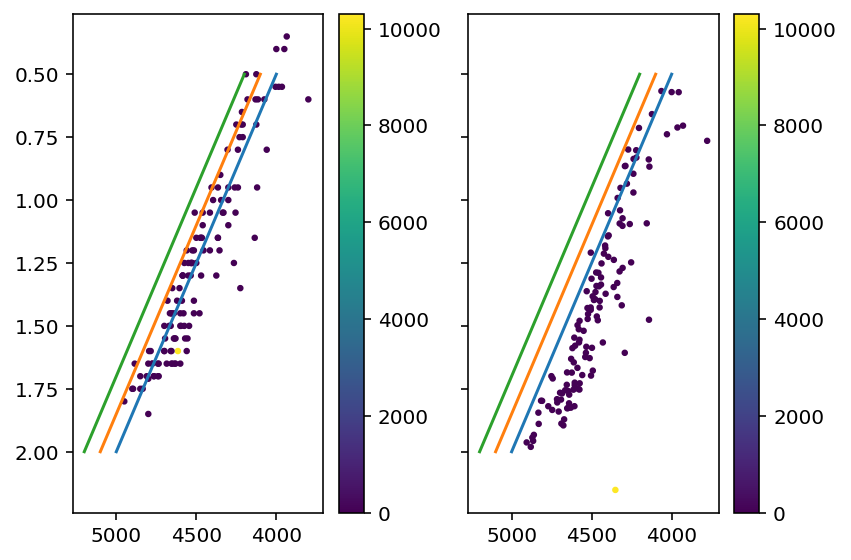

In [21]:
f, gs = plt.subplots(1,2,sharex=True,sharey=True)
ax = gs[0]
s = ax.scatter(
    galah_jp10['Teff'], galah_jp10['log_g_'],
    c = galah_jp10['flag_sp'],
    s = 5
)
plt.colorbar(s,ax=ax)
ax.plot([4000,5000],[0.5,2.0])
ax.plot([4100,5100],[0.5,2.0])
ax.plot([4200,5200],[0.5,2.0])

ax = gs[1]
s = ax.scatter(
    galah_jp10['teff'], galah_jp10['logg'],
    c = galah_jp10['flag_sp'],
    s = 5
)
plt.colorbar(s,ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot([4000,5000],[0.5,2.0])
ax.plot([4100,5100],[0.5,2.0])
ax.plot([4200,5200],[0.5,2.0])

plt.tight_layout()

In [22]:
galah_jp10[(galah_jp10['flag_sp'] > 64) & (galah_jp10['flag_sp'] < 128)]

<Table length=0>
sobject_id tmass_id gaiadr3_source_id ... GroupID GroupSize Separation
                                      ...                     arcsec  
  int64    bytes16        int64       ...  int32    int32    float64  
---------- -------- ----------------- ... ------- --------- ----------

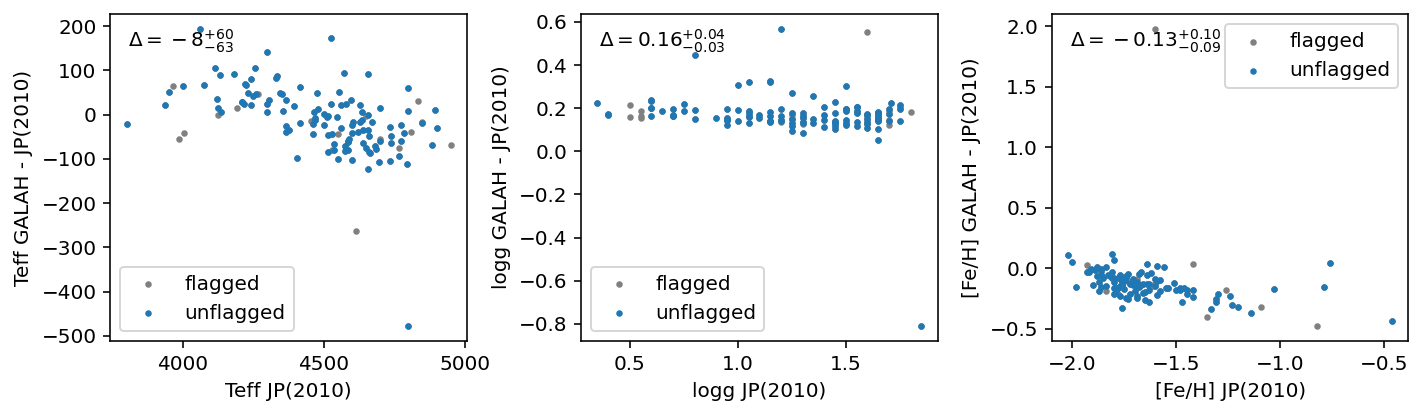

In [23]:
useful = np.isfinite(galah_jp10['__Fe_H_']) & (galah_jp10['flag_sp'] == 0)

f, gs = plt.subplots(1,3,figsize=(10,3))
ax = gs[0]
label_lit = 'Teff'
label_galah = 'teff'
ax.set_xlabel('Teff JP(2010)')
ax.set_ylabel('Teff GALAH - JP(2010)')
s = ax.scatter(
    galah_jp10[label_lit], galah_jp10[label_galah]-galah_jp10[label_lit],
    c = 'grey', label = 'flagged',
    s = 5
)
s = ax.scatter(
    galah_jp10[label_lit][useful], galah_jp10[label_galah][useful]-galah_jp10[label_lit][useful],
    c = 'C0', label = 'unflagged',
    s = 5
)
ax.legend()
p16,p50,p84 = np.percentile(galah_jp10[label_galah][useful]-galah_jp10[label_lit][useful],q=[16,50,84])
ax.text(0.05,0.9,r'$\Delta = '+"{:.0f}".format(p50)+'_{-'+"{:.0f}".format(p50-p16)+'}^{+'+"{:.0f}".format(p84-p50)+'}$',transform=ax.transAxes)

ax = gs[1]
label_lit = 'log_g_'
label_galah = 'logg'
ax.set_xlabel('logg JP(2010)')
ax.set_ylabel('logg GALAH - JP(2010)')
s = ax.scatter(
    galah_jp10[label_lit], galah_jp10[label_galah]-galah_jp10[label_lit],
    c = 'grey', label = 'flagged',
    s = 5
)
s = ax.scatter(
    galah_jp10[label_lit][useful], galah_jp10[label_galah][useful]-galah_jp10[label_lit][useful],
    c = 'C0', label = 'unflagged',
    s = 5
)
ax.legend()
p16,p50,p84 = np.percentile(galah_jp10[label_galah][useful]-galah_jp10[label_lit][useful],q=[16,50,84])
ax.text(0.05,0.9,r'$\Delta = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',transform=ax.transAxes)
# plt.colorbar(s,ax=ax)

ax = gs[2]
label_lit = '__Fe_H_'
label_galah = 'fe_h'
ax.set_xlabel('[Fe/H] JP(2010)')
ax.set_ylabel('[Fe/H] GALAH - JP(2010)')
s = ax.scatter(
    galah_jp10[label_lit], galah_jp10[label_galah]-galah_jp10[label_lit],
    c = 'grey', label = 'flagged',
    s = 5
)
s = ax.scatter(
    galah_jp10[label_lit][useful], galah_jp10[label_galah][useful]-galah_jp10[label_lit][useful],
    c = 'C0', label = 'unflagged',
    s = 5
)
ax.legend()
p16,p50,p84 = np.percentile(galah_jp10[label_galah][useful]-galah_jp10[label_lit][useful],q=[16,50,84])
ax.text(0.05,0.9,r'$\Delta = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',transform=ax.transAxes)
# plt.colorbar(s,ax=ax)
plt.tight_layout(w_pad=0)

In [25]:
np.unique(galah_jp10['model_name'][galah_jp10['flag_sp'] > 24],return_counts=True)

(<MaskedColumn name='model_name' dtype='bytes16' length=1>
 4500_2.00_-0.25,
 array([1]))

Analysis for O with Johnson & Pilachowski (2010)


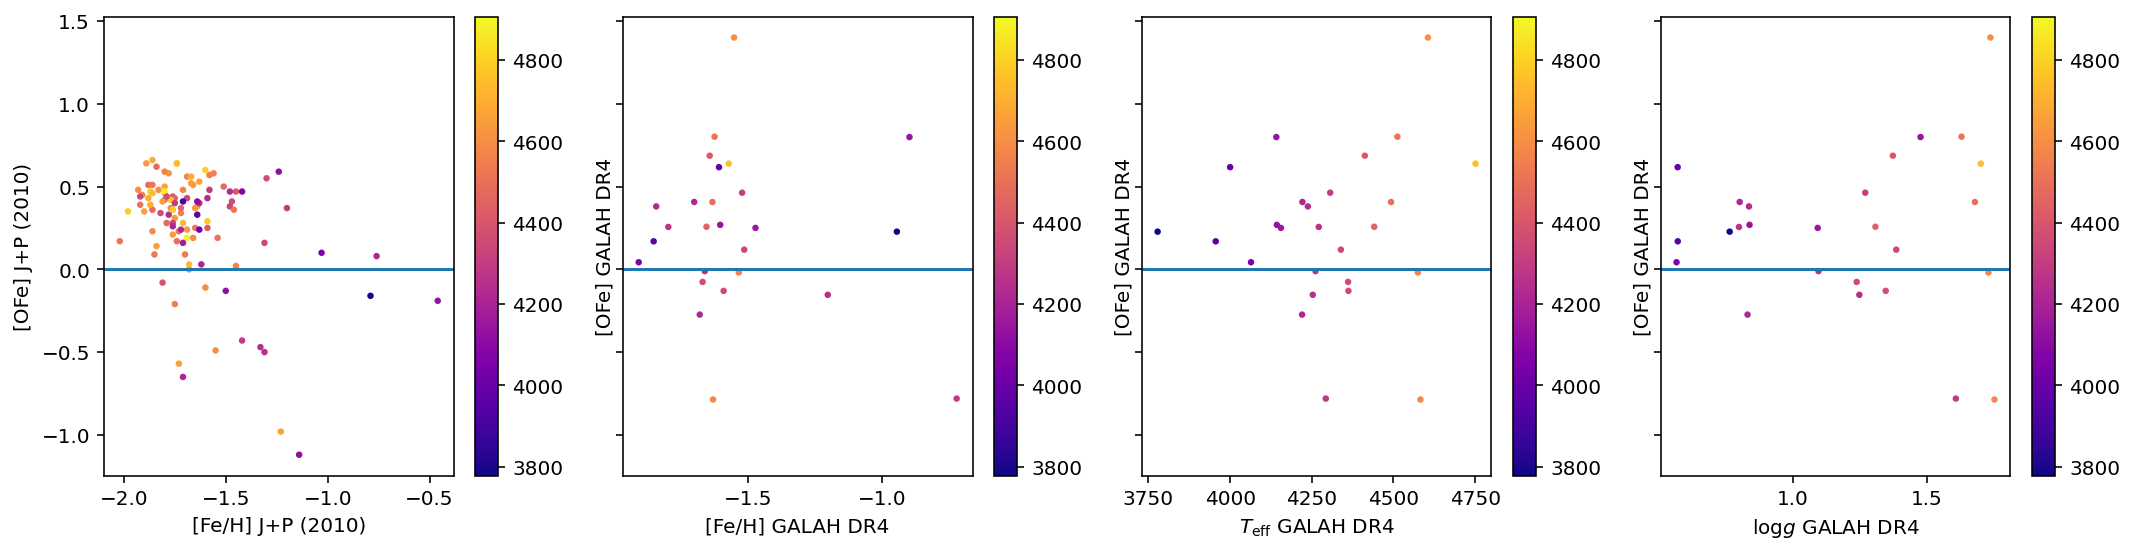

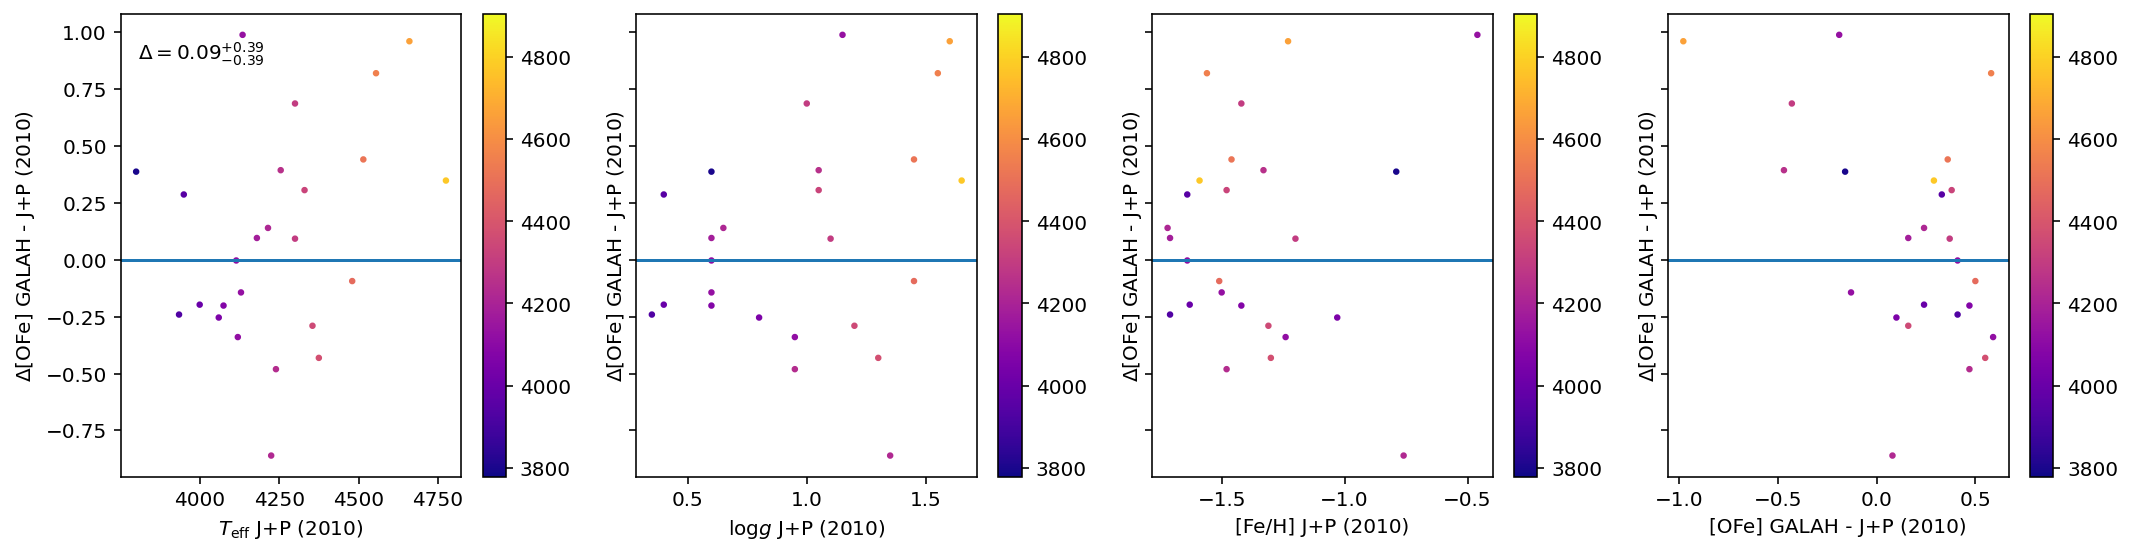

Analysis for Na with Johnson & Pilachowski (2010)


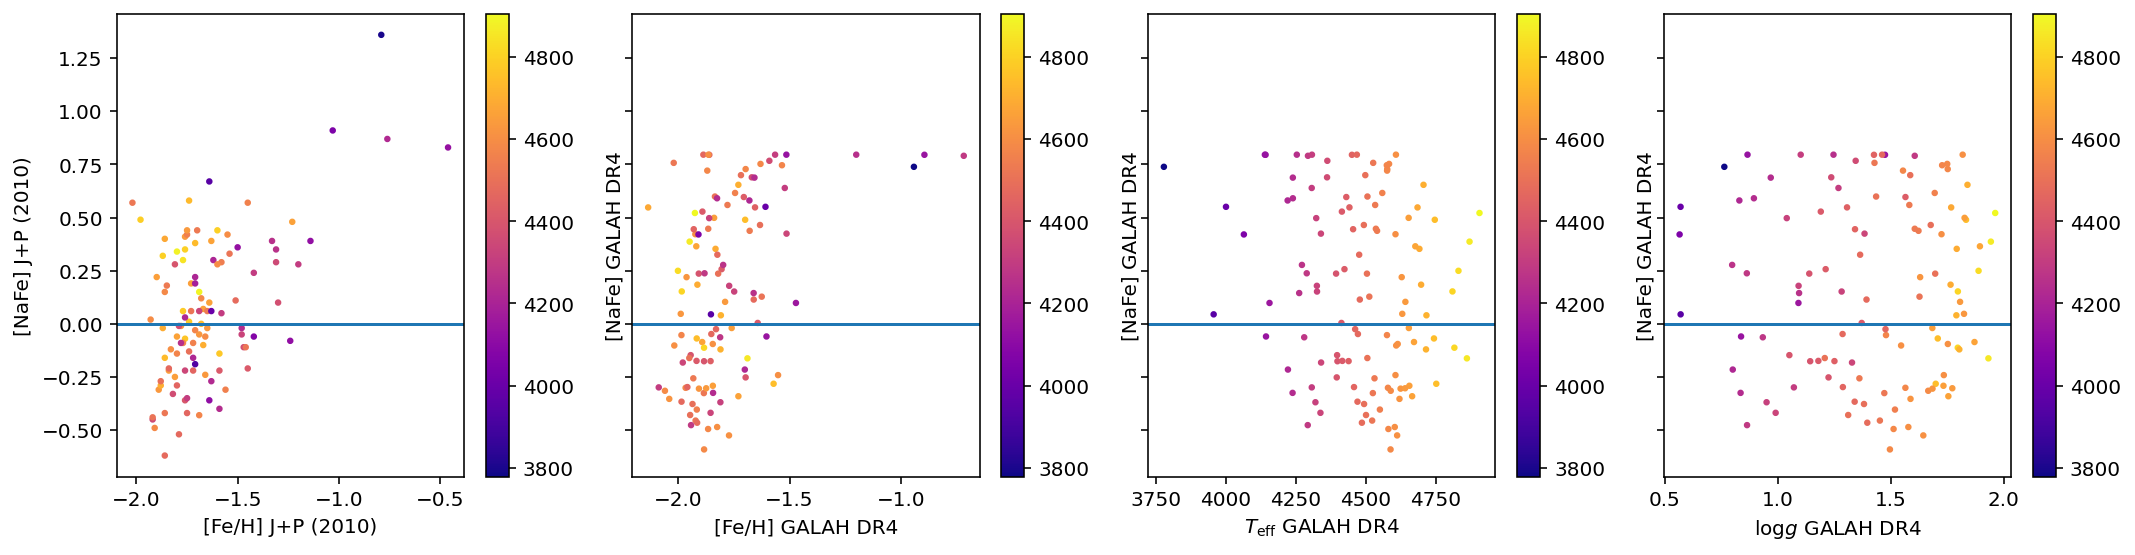

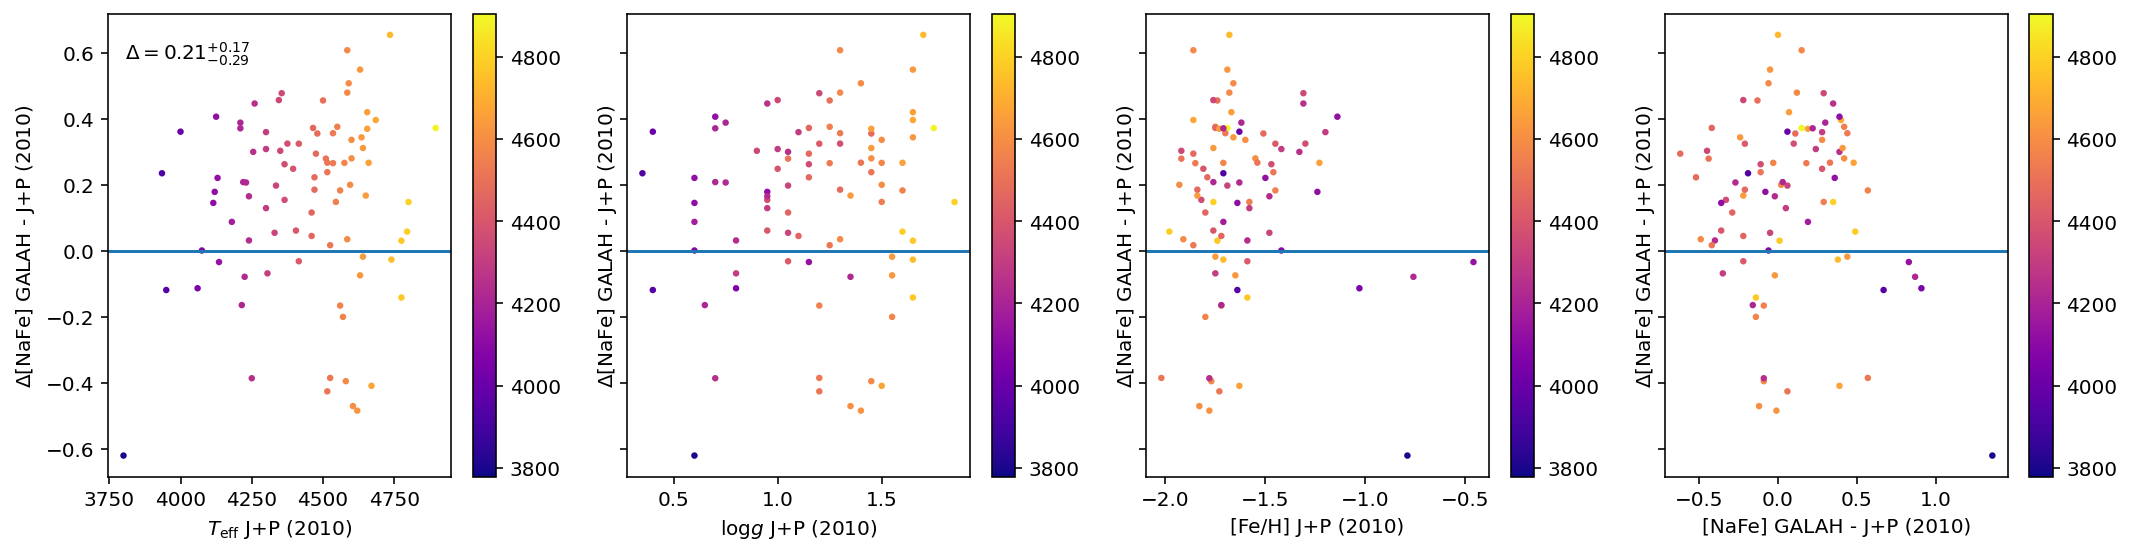

Analysis for Al with Johnson & Pilachowski (2010)


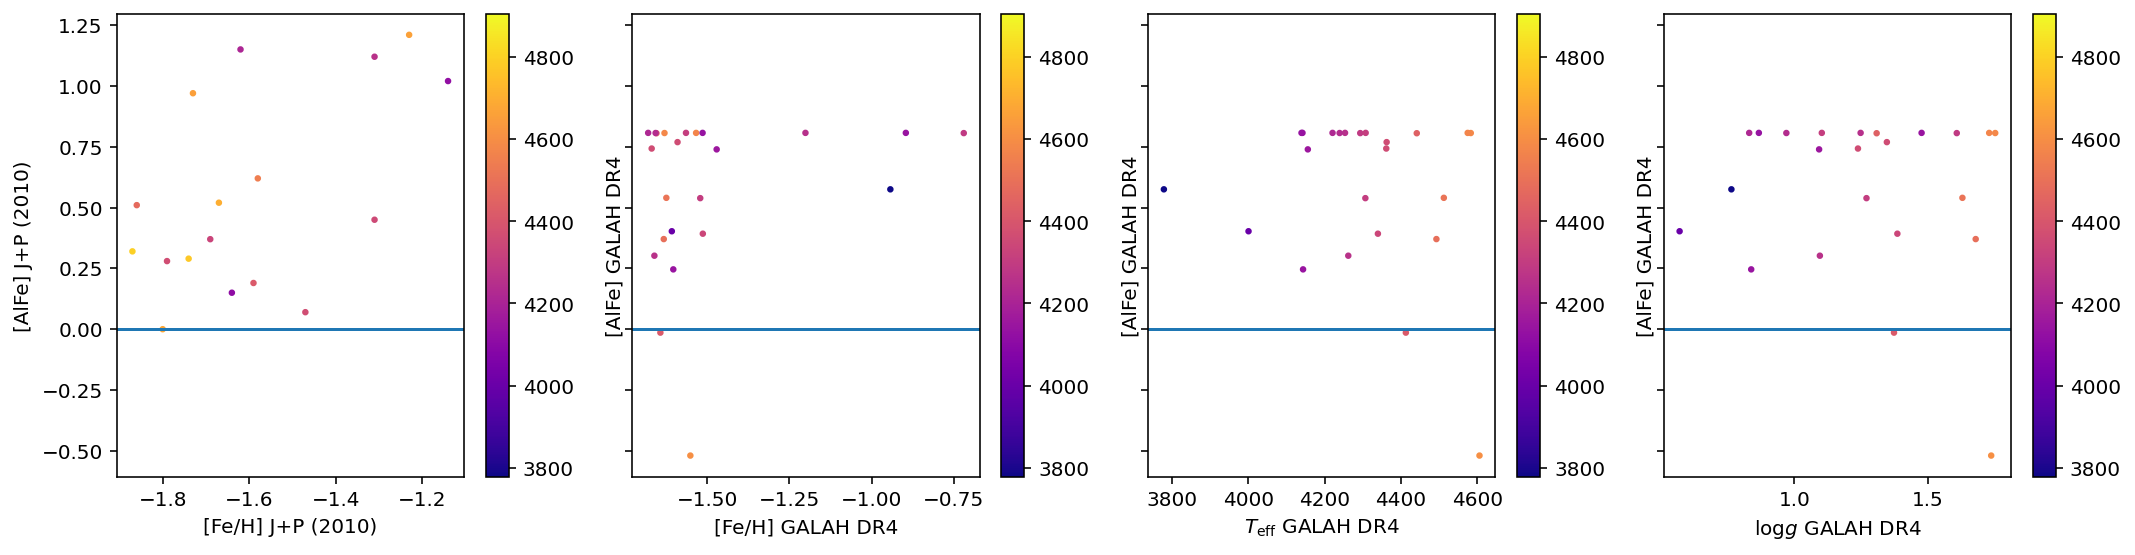

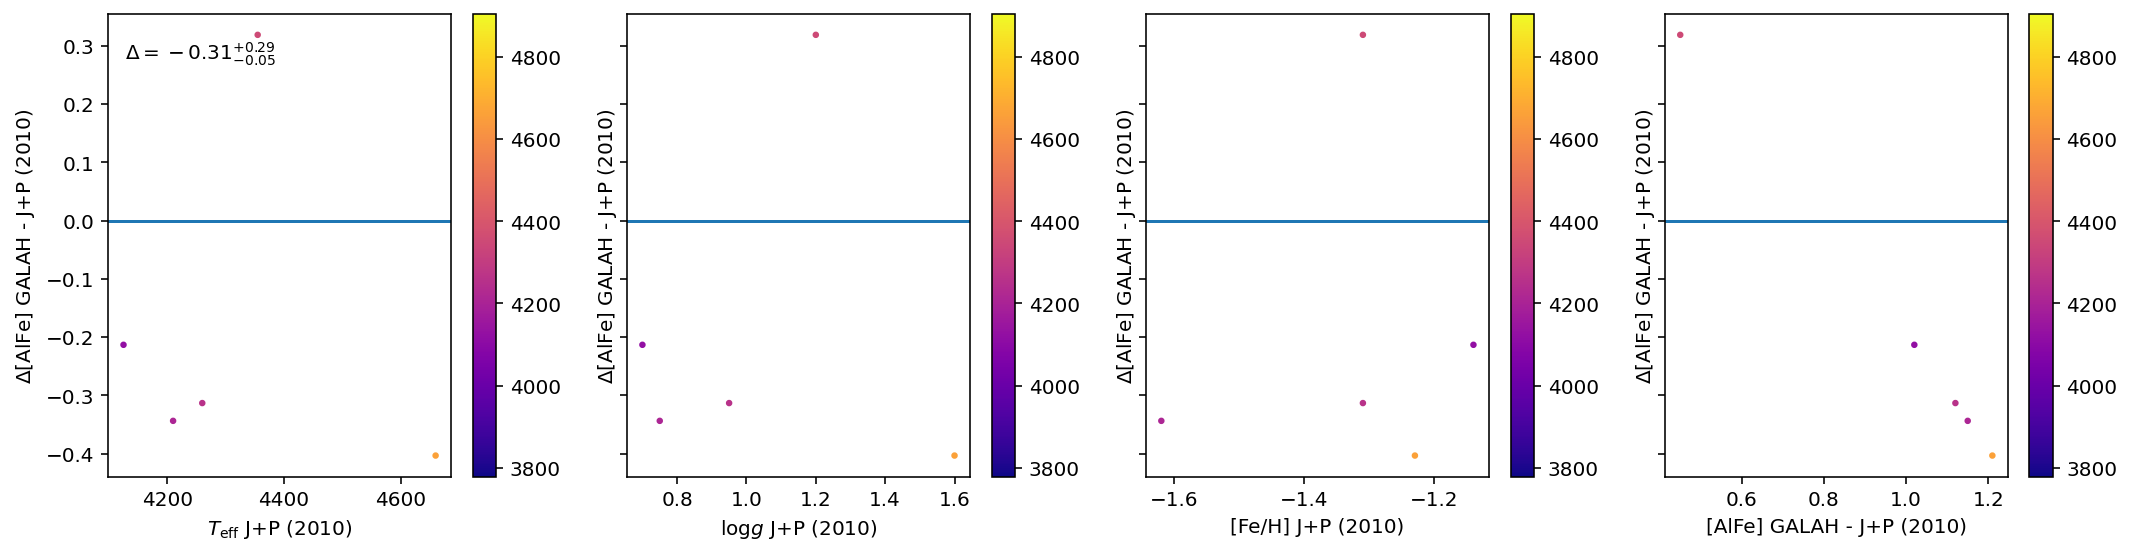

Analysis for Si with Johnson & Pilachowski (2010)


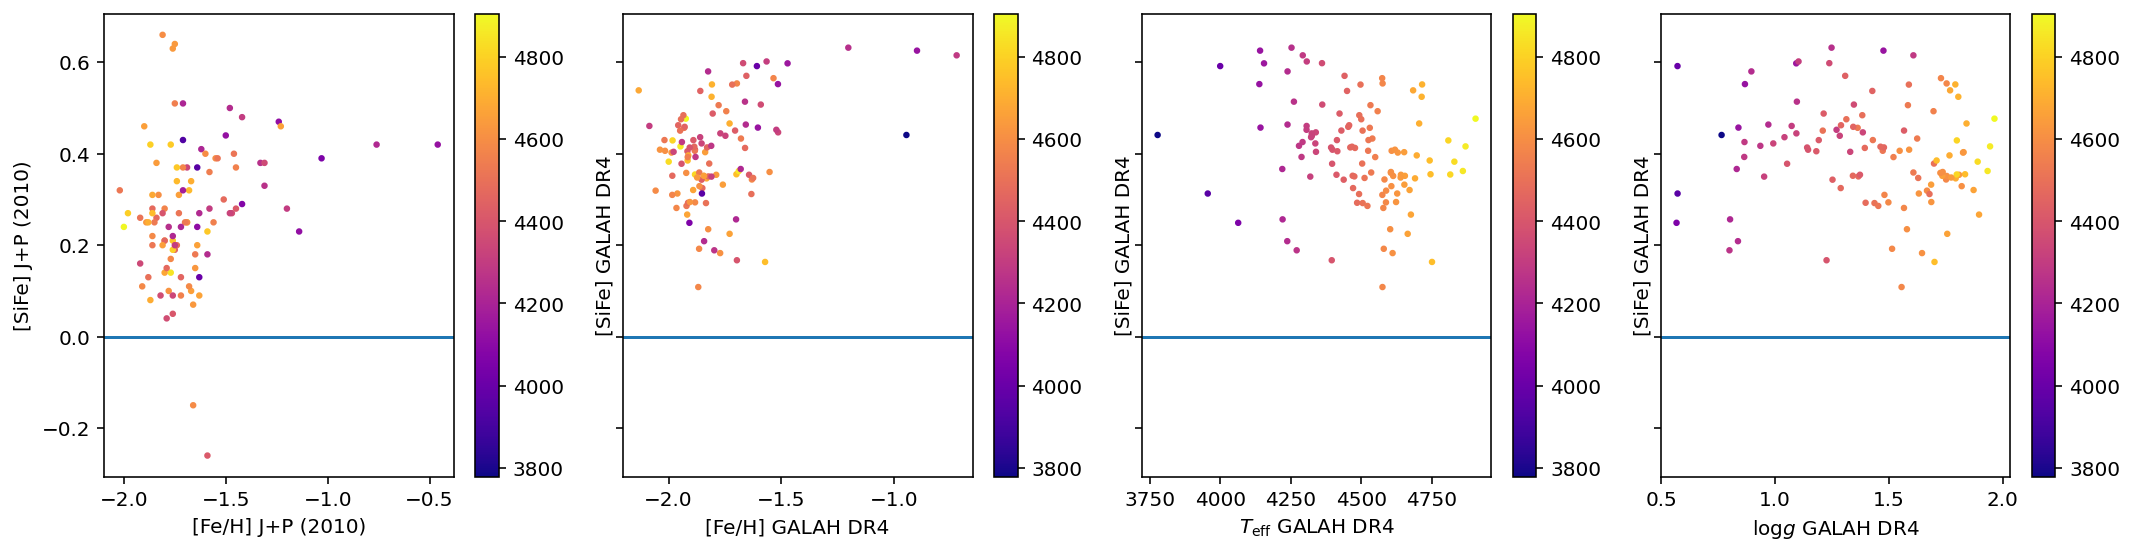

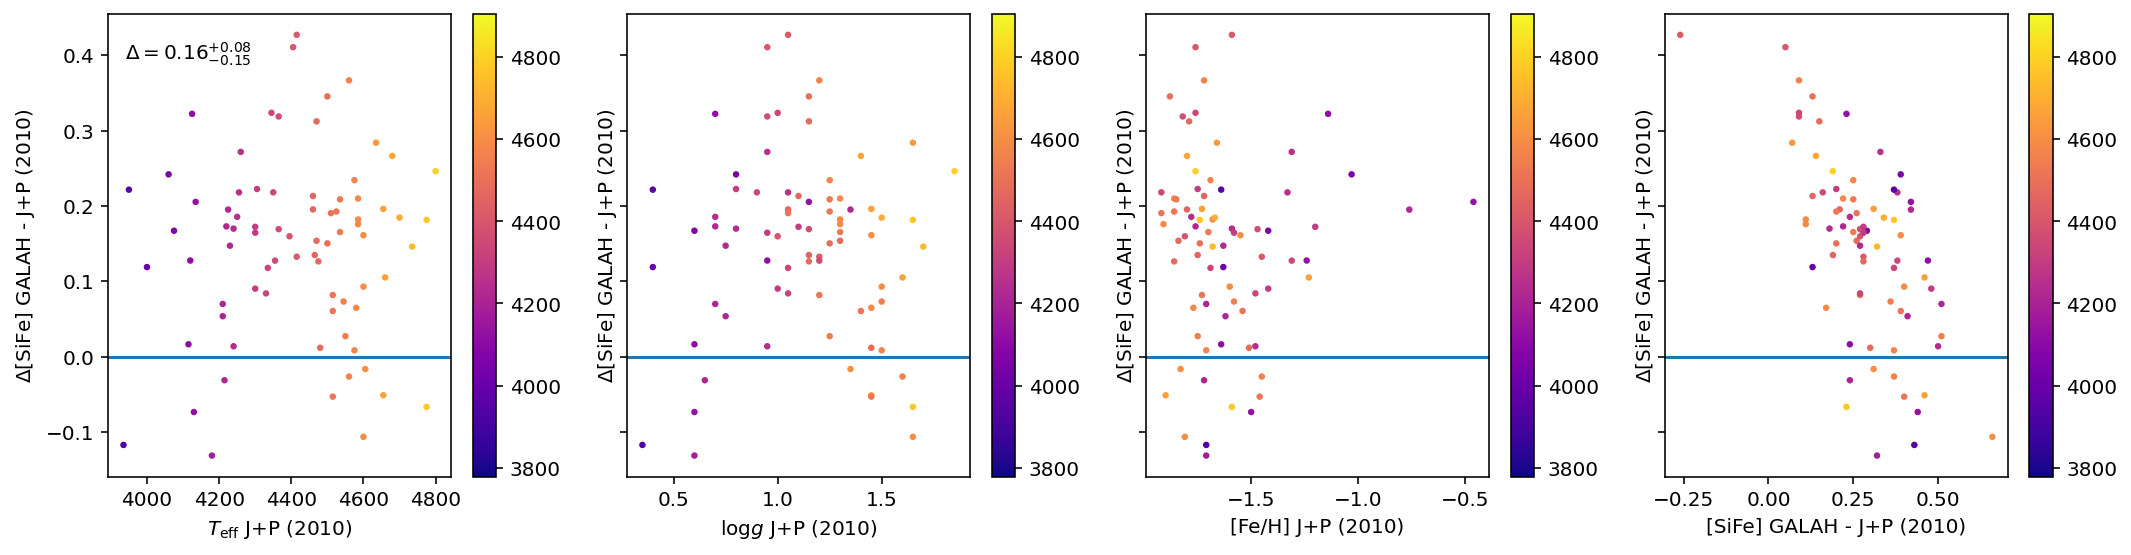

Analysis for Ca with Johnson & Pilachowski (2010)


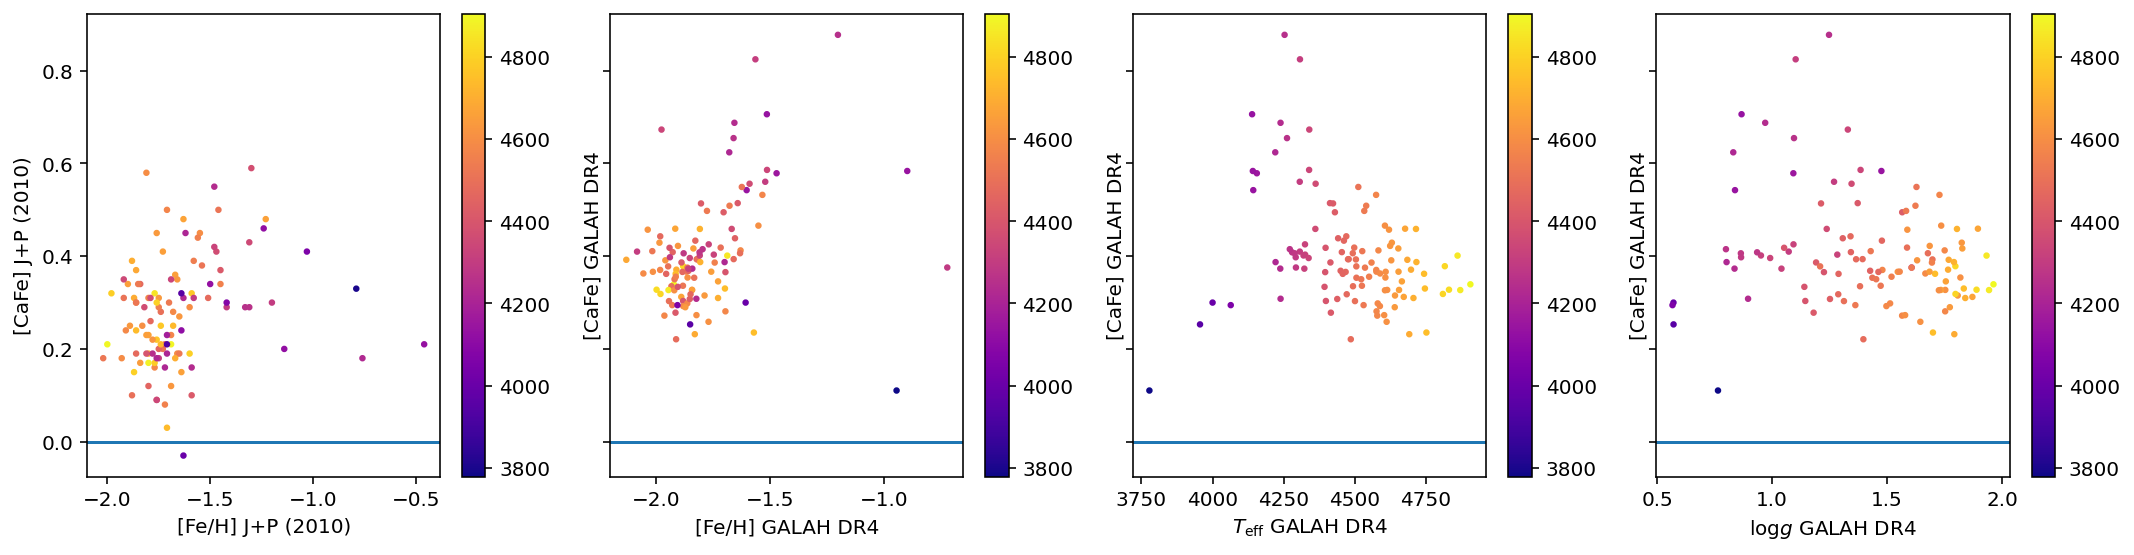

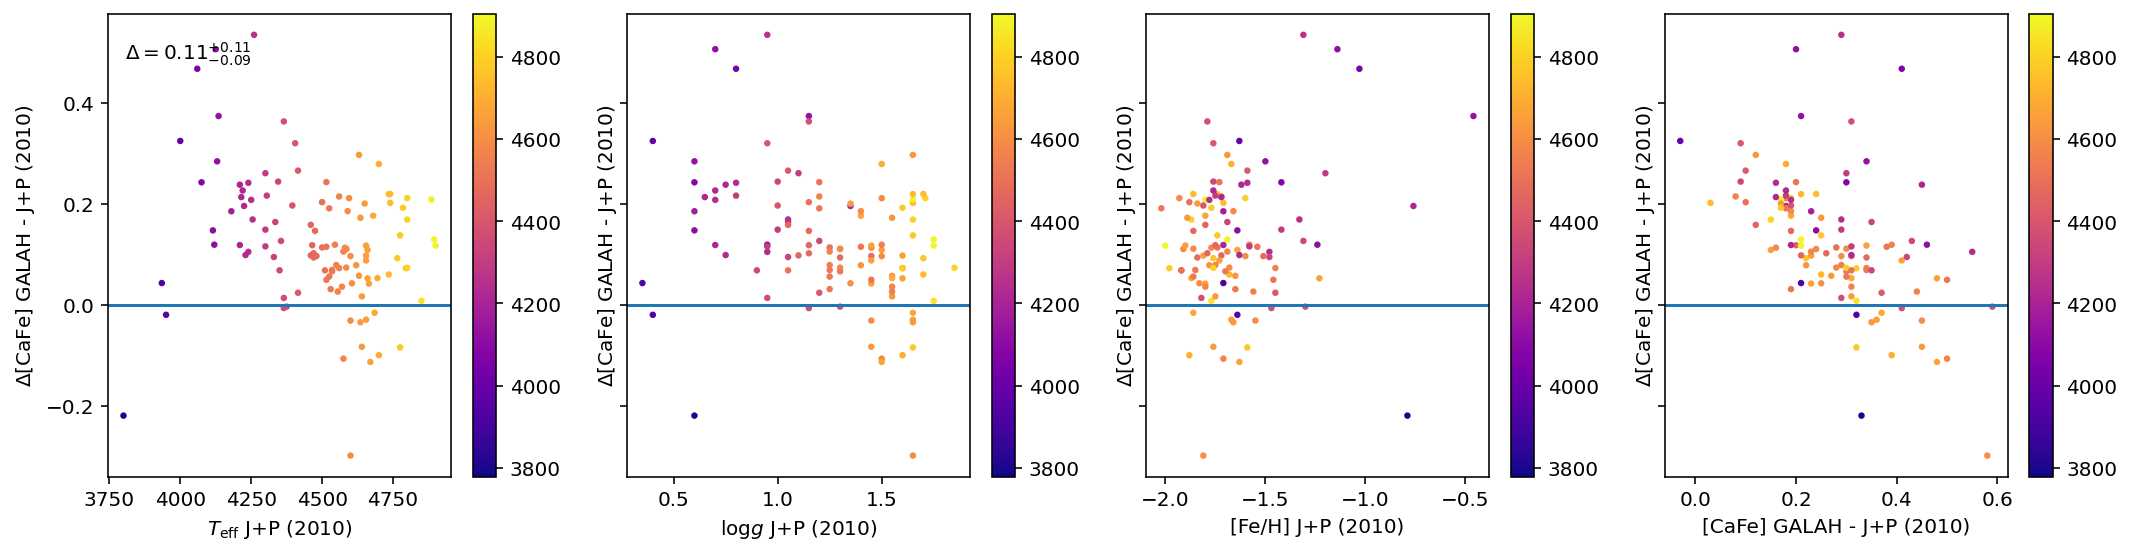

Analysis for Sc with Johnson & Pilachowski (2010)


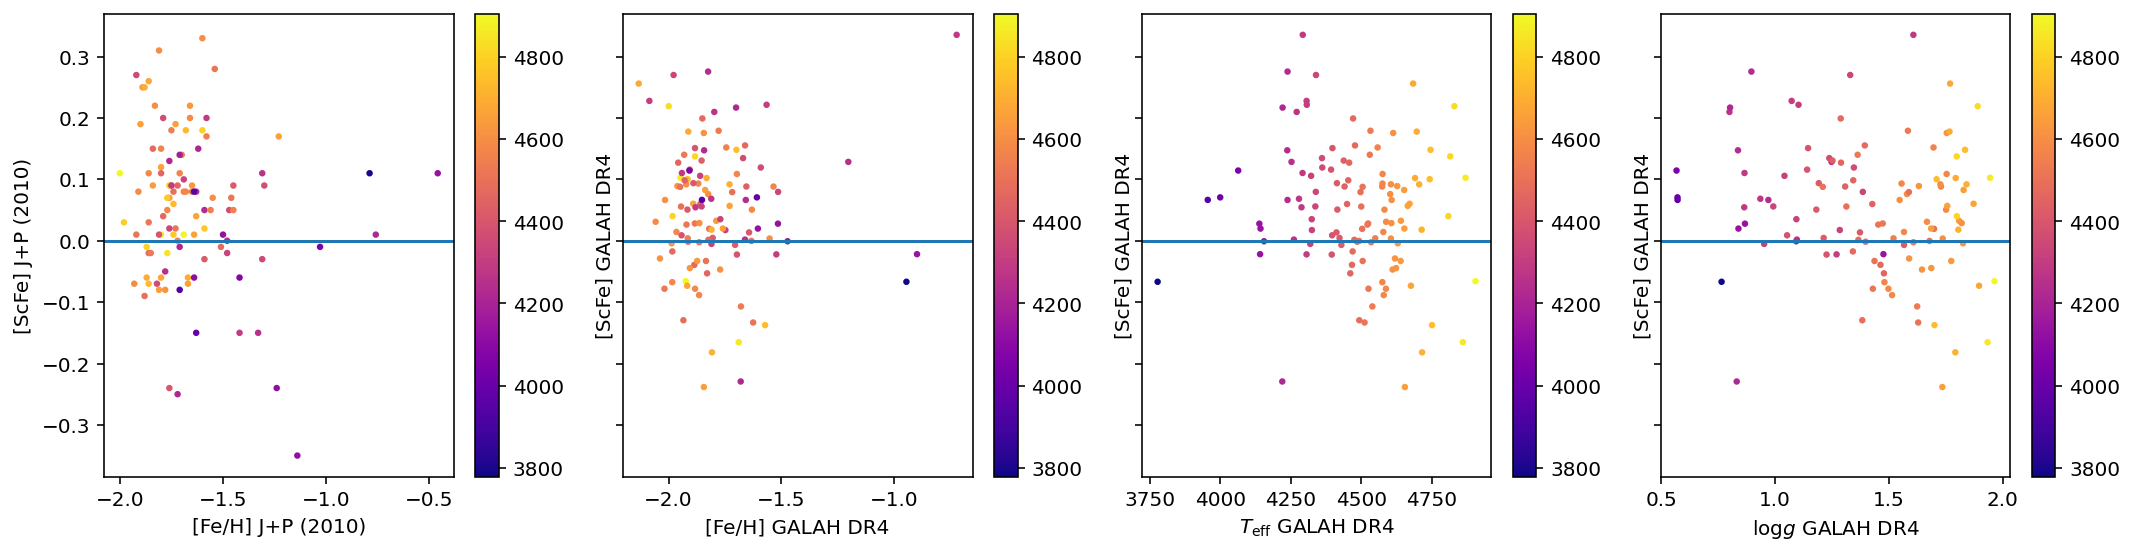

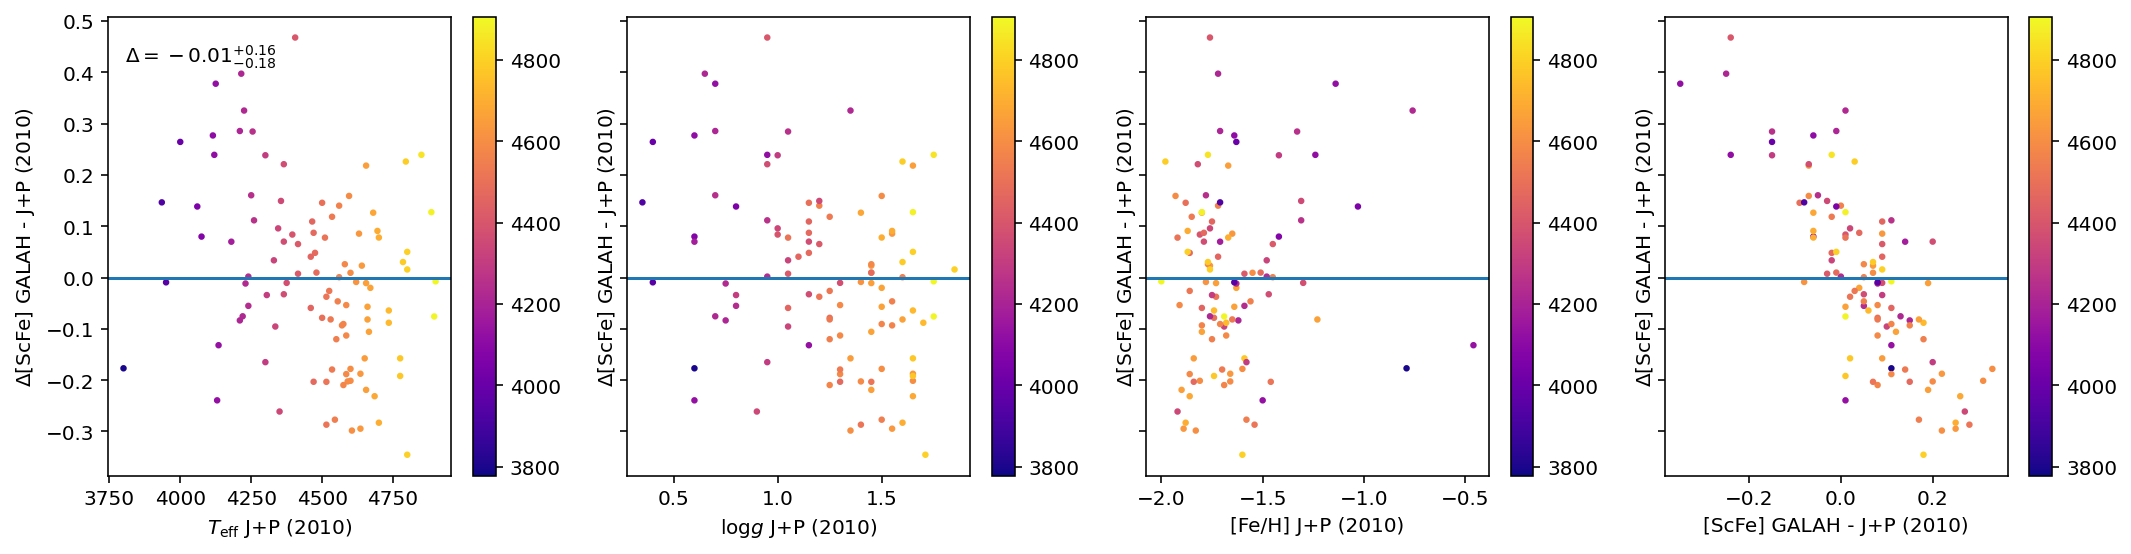

Analysis for Ti with Johnson & Pilachowski (2010)


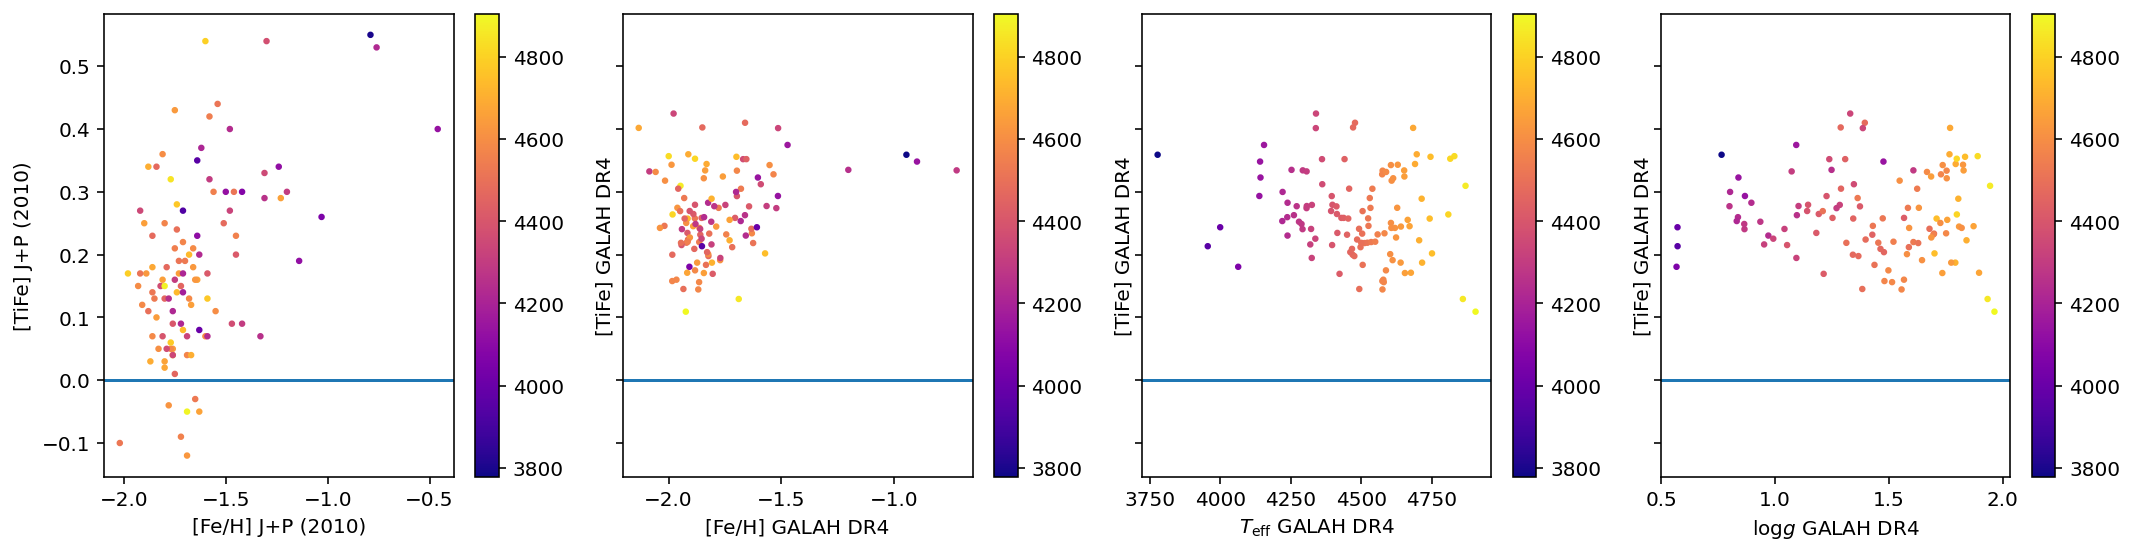

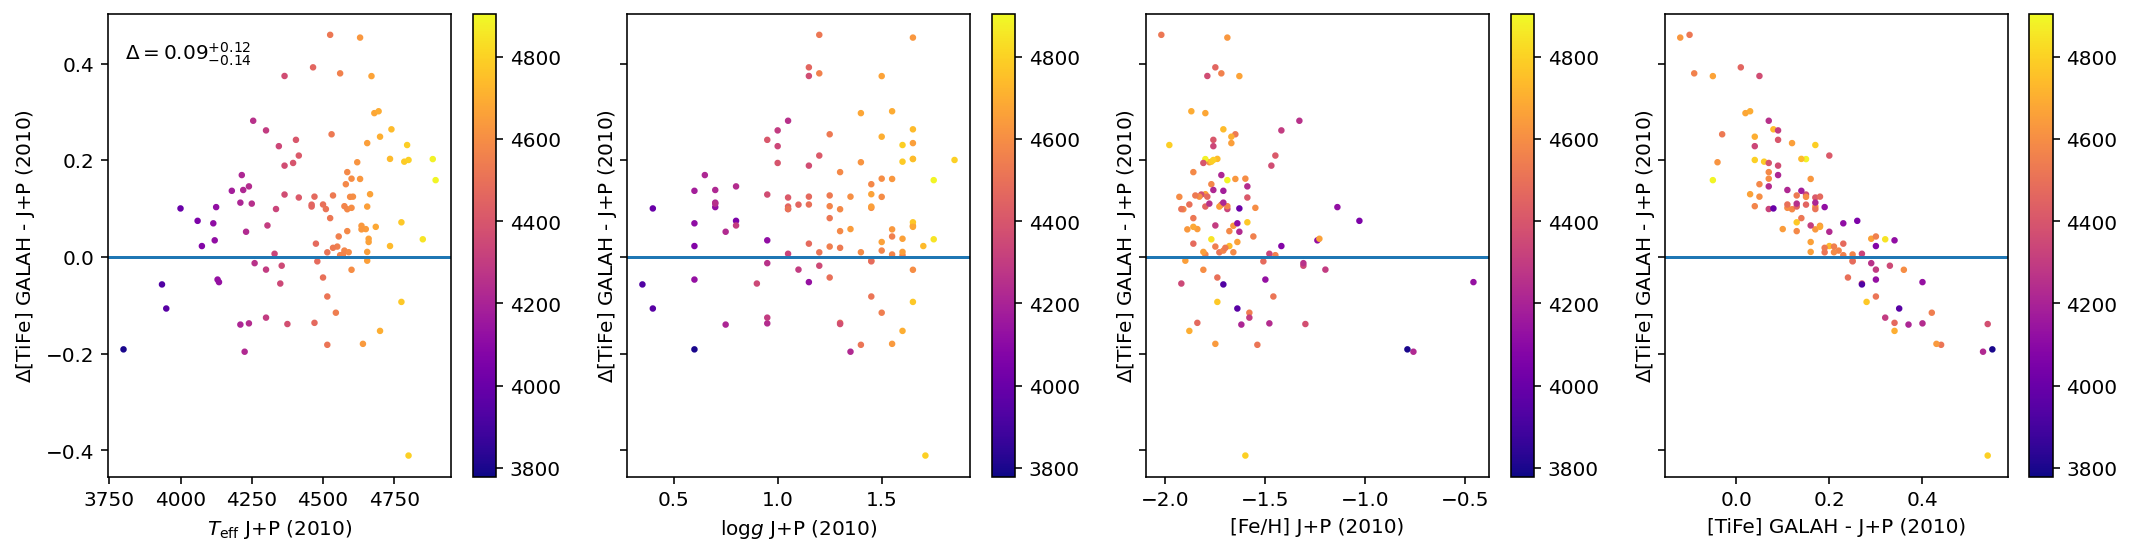

Analysis for Ni with Johnson & Pilachowski (2010)


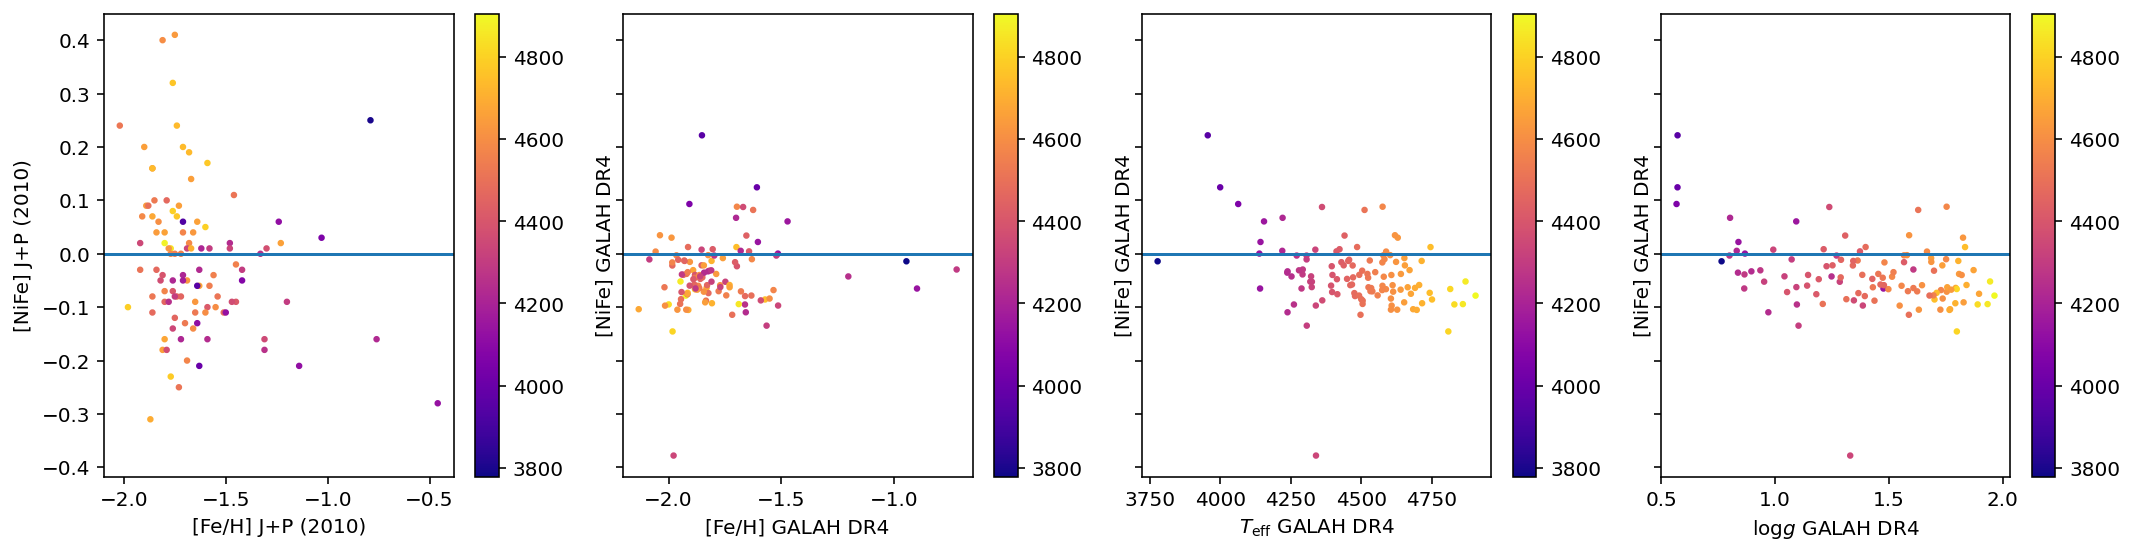

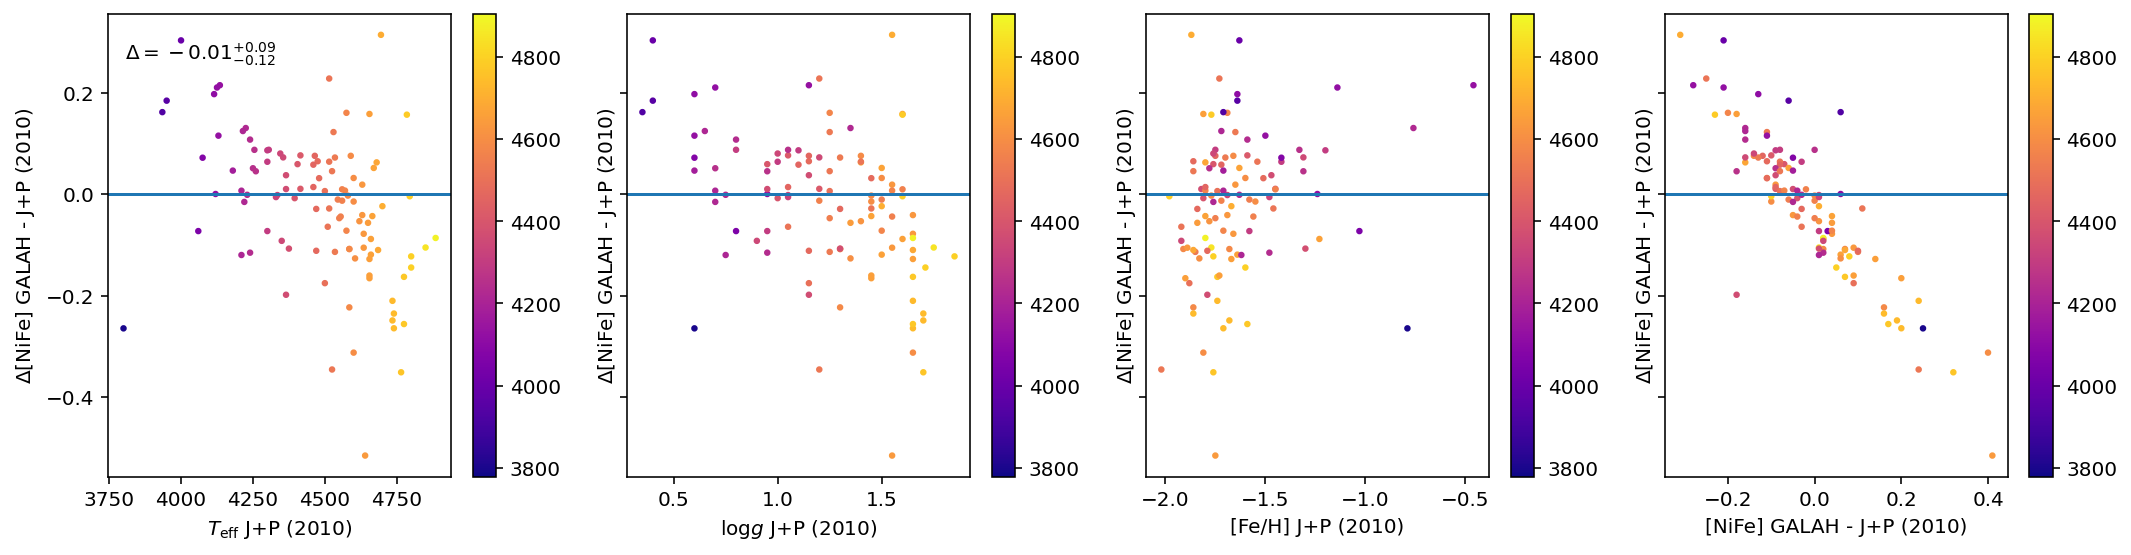

Analysis for La with Johnson & Pilachowski (2010)


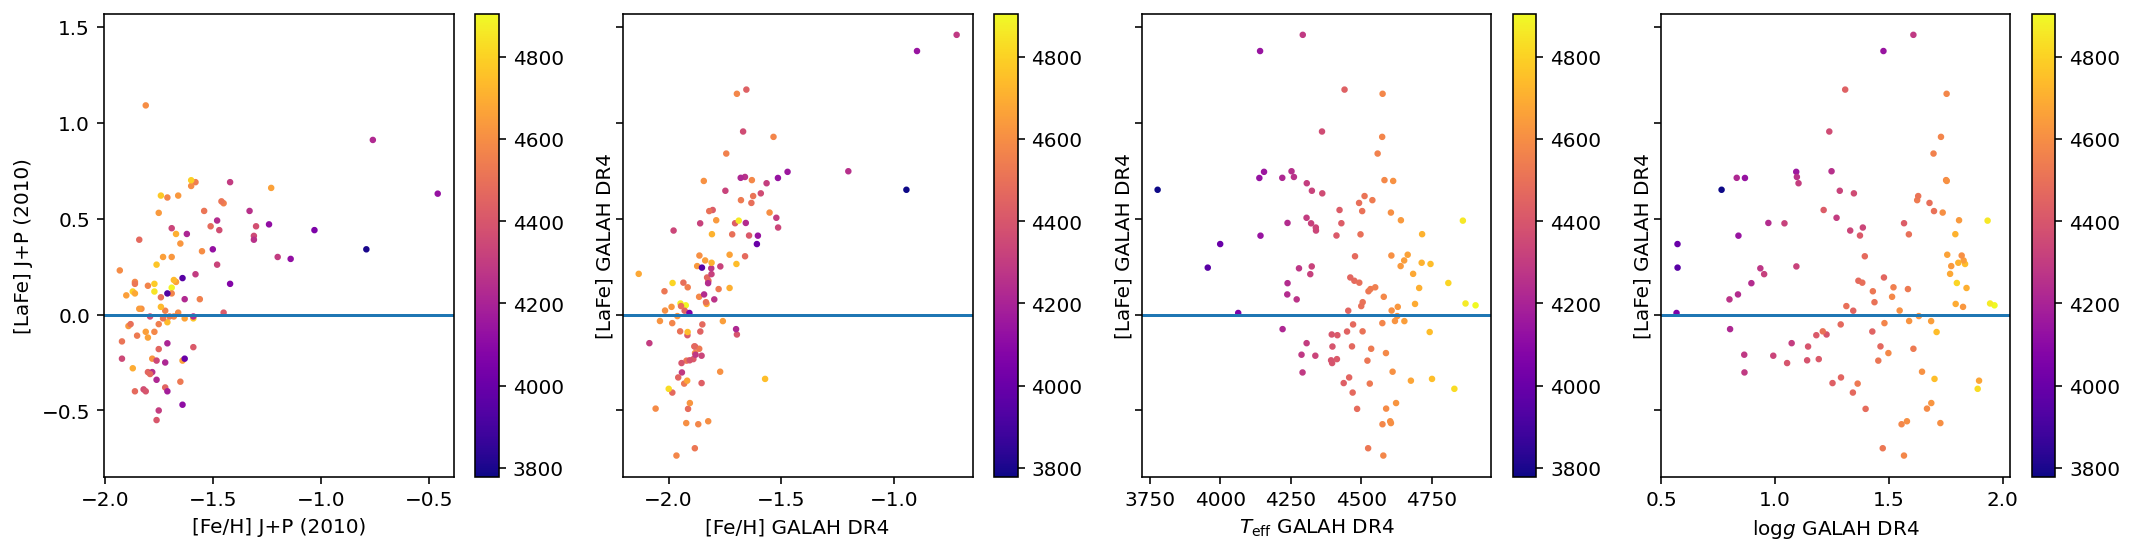

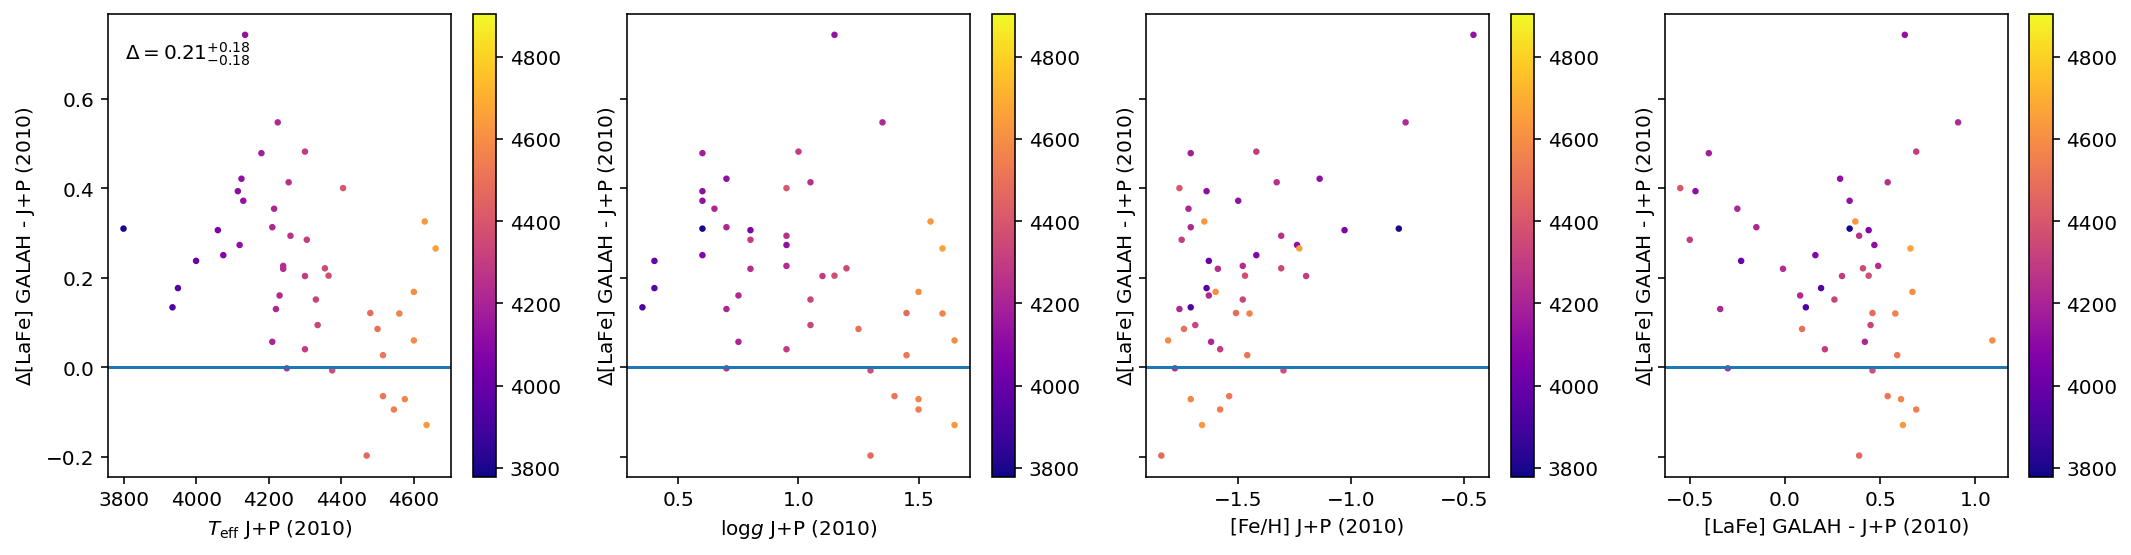

Analysis for Eu with Johnson & Pilachowski (2010)


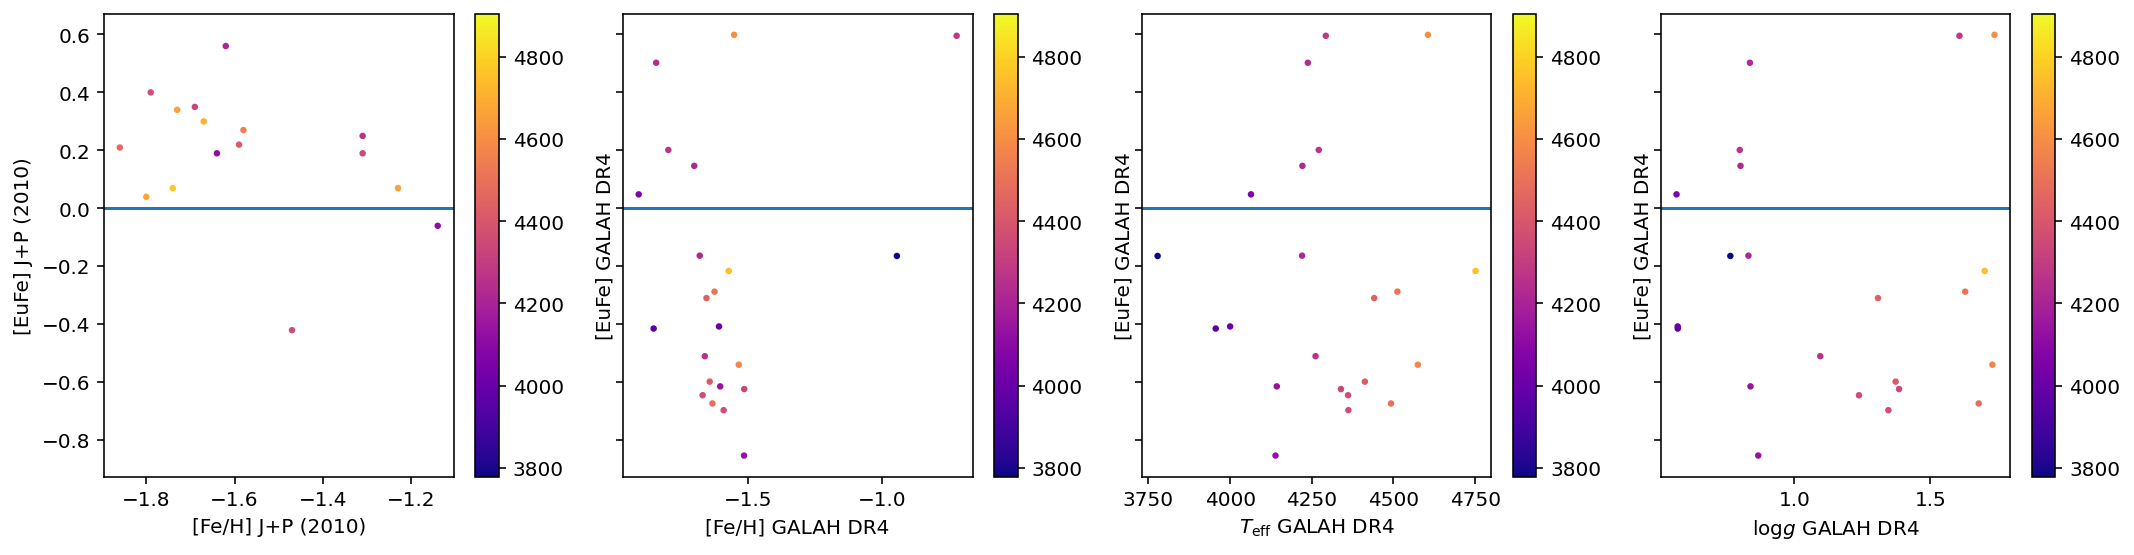

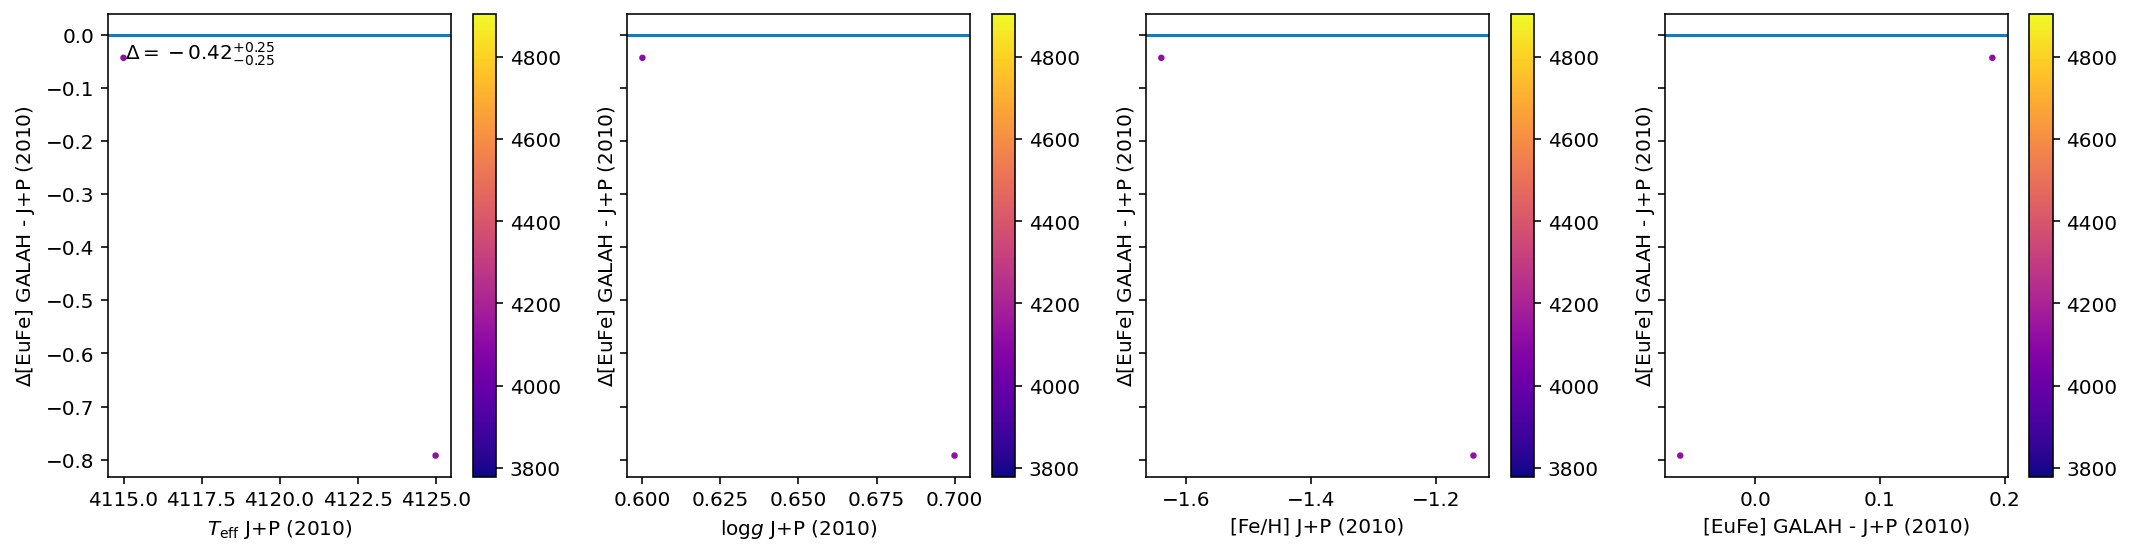

In [26]:
for elem in ['O','Na','Al','Si','Ca','Sc','Ti','Ni','La','Eu']:
    
    print('Analysis for '+elem+' with Johnson & Pilachowski (2010)')
    
    selection = (galah_jp10['flag_sp'] == 0)
    
    if elem in ['La','Eu']:
        name = elem+'II'
    else:        
        name = elem

    color_range = (
        np.min([np.nanmin(galah_jp10['Teff'][selection]),np.nanmin(galah_jp10['teff'][selection])]),
        np.max([np.nanmax(galah_jp10['Teff'][selection]),np.nanmax(galah_jp10['teff'][selection])])
    )
        
    f, gs = plt.subplots(1,4,figsize=(15,4),sharey=True)
    ax = gs[0]
    s = ax.scatter(
        galah_jp10['__Fe_H_'][selection], galah_jp10['__'+name+'_Fe_'][selection],
        c = galah_jp10['Teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel('[Fe/H] J+P (2010)')
    ax.set_ylabel('['+elem+'Fe] J+P (2010)')
    ax.axhline(0)
    
    ax = gs[1]
    s = ax.scatter(
        galah_jp10['fe_h'][selection], galah_jp10[elem.lower()+'_fe'][selection],
        c = galah_jp10['teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel('[Fe/H] GALAH DR4')
    ax.set_ylabel('['+elem+'Fe] GALAH DR4')
    ax.axhline(0)
    
    ax = gs[2]
    s = ax.scatter(
        galah_jp10['teff'][selection], galah_jp10[elem.lower()+'_fe'][selection],
        c = galah_jp10['teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel(r'$T_\mathrm{eff}$ GALAH DR4')
    ax.set_ylabel('['+elem+'Fe] GALAH DR4')
    ax.axhline(0)
    
    ax = gs[3]
    s = ax.scatter(
        galah_jp10['logg'][selection], galah_jp10[elem.lower()+'_fe'][selection],
        c = galah_jp10['teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel(r'$\log g$ GALAH DR4')
    ax.set_ylabel('['+elem+'Fe] GALAH DR4')
    ax.axhline(0)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    selection = (galah_jp10['flag_sp'] == 0) & (galah_jp10['flag_'+elem.lower()+'_fe'] == 0) & np.isfinite(galah_jp10['__'+name+'_Fe_'])

        
    f, gs = plt.subplots(1,4,figsize=(15,4),sharey=True)
    ax = gs[0]
    s = ax.scatter(
        galah_jp10['Teff'][selection], galah_jp10[elem.lower()+'_fe'][selection] - galah_jp10['__'+name+'_Fe_'][selection],
        c = galah_jp10['Teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel(r'$T_\mathrm{eff}$ J+P (2010)')
    ax.set_ylabel(r'$\Delta$['+elem+'Fe] GALAH - J+P (2010)')
    ax.axhline(0)
    p16,p50,p84 = np.percentile(galah_jp10[elem.lower()+'_fe'][selection] - galah_jp10['__'+name+'_Fe_'][selection],q=[16,50,84])
    ax.text(0.05,0.9,r'$\Delta = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',transform=ax.transAxes)
  
    ax = gs[1]
    s = ax.scatter(
        galah_jp10['log_g_'][selection], galah_jp10[elem.lower()+'_fe'][selection] - galah_jp10['__'+name+'_Fe_'][selection],
        c = galah_jp10['Teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel(r'$\log g$ J+P (2010)')
    ax.set_ylabel(r'$\Delta$['+elem+'Fe] GALAH - J+P (2010)')
    ax.axhline(0)

    ax = gs[2]
    s = ax.scatter(
        galah_jp10['__Fe_H_'][selection], galah_jp10[elem.lower()+'_fe'][selection] - galah_jp10['__'+name+'_Fe_'][selection],
        c = galah_jp10['Teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel('[Fe/H] J+P (2010)')
    ax.set_ylabel(r'$\Delta$['+elem+'Fe] GALAH - J+P (2010)')
    ax.axhline(0)
    
    ax = gs[3]
    s = ax.scatter(
        galah_jp10['__'+name+'_Fe_'][selection], galah_jp10[elem.lower()+'_fe'][selection] - galah_jp10['__'+name+'_Fe_'][selection],
        c = galah_jp10['Teff'][selection], cmap = 'plasma',
        vmin = color_range[0], vmax = color_range[1],
        s = 5
    )
    plt.colorbar(s,ax=ax)
    ax.set_xlabel(r'['+elem+'Fe] GALAH - J+P (2010)')
    ax.set_ylabel(r'$\Delta$['+elem+'Fe] GALAH - J+P (2010)')
    ax.axhline(0)
    plt.tight_layout()
    plt.show()
    plt.close()
    

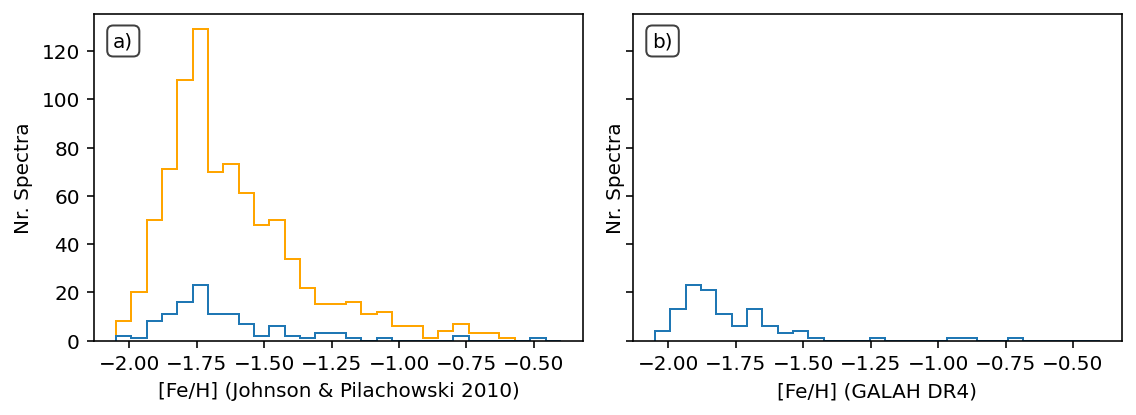

In [27]:
selection = (galah_jp10['flag_sp'] == 0) & (galah_jp10['flag_fe_h'] == 0)

fe_h_bins = np.linspace(-2.05,-0.4,30)

f, gs = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax = gs[0]
ax.text(0.04,0.9,'a)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.set_xlabel('[Fe/H] (Johnson & Pilachowski 2010)')
ax.set_ylabel('Nr. Spectra')
ax.hist(
    jp10['__Fe_H_'],
    histtype='step',color='orange',
    bins = fe_h_bins
)
ax.hist(
    galah_jp10['__Fe_H_'][selection],
    histtype='step',color='C0',
    bins = fe_h_bins
)

ax = gs[1]
ax.set_xlabel('[Fe/H] (GALAH DR4)')
ax.set_ylabel('Nr. Spectra')
ax.text(0.04,0.9,'b)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.hist(
    galah_jp10['fe_h'][selection],
    histtype='step',
    bins = fe_h_bins
)
plt.tight_layout()

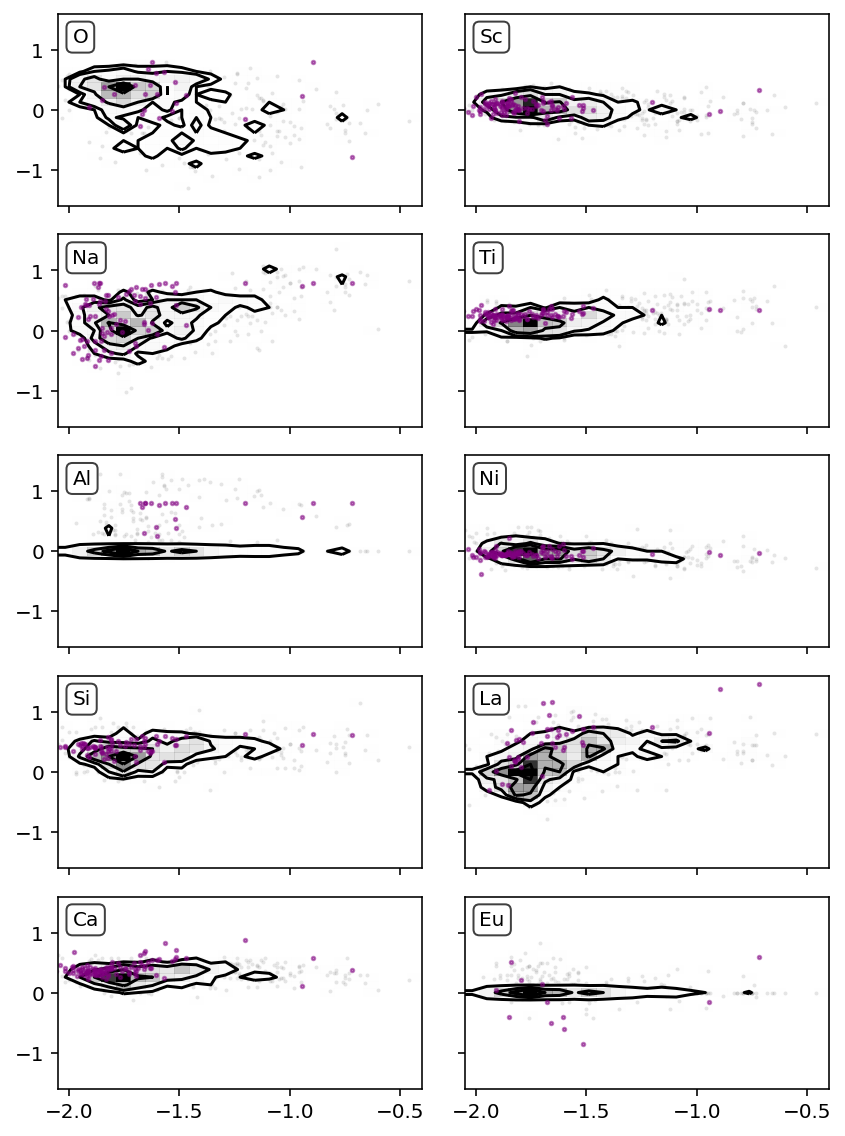

In [28]:
selection = (galah_jp10['flag_sp'] == 0)

f, gs = plt.subplots(5,2,figsize=(6,8),sharex=True,sharey=True)

for index, elem in enumerate(['O','Sc','Na','Ti','Al','Ni','Si','La','Ca','Eu']):

    unflagged = (
        (galah_jp10['flag_sp'] == 0) & 
        (galah_jp10['flag_fe_h'] == 0) & 
        (galah_jp10['flag_'+elem.lower()+'_fe'] == 0)
    )
    
    ax = gs[int((index - index%2)/2),index%2]
    ax.text(0.04,0.85,elem,ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    xlims = (-2.05,-0.4)
    ylims = (-1.6,1.6)
    
    elem_name = '__'+elem+'_Fe_'
    if elem in ['La','Eu']:
        elem_name = '__'+elem+'II_Fe_'

    corner.hist2d(
        jp10['__Fe_H_'],
        jp10[elem_name],
        ax=ax,
        bins = 25,
        range=[xlims,ylims],
        zorder=1,
        label = 'JP10'
    )

    ax.scatter(
        galah_jp10['fe_h'][unflagged],
        galah_jp10[elem.lower()+'_fe'][unflagged],
        s = 3,
        c = 'purple',alpha=0.5,
        zorder=2,
        label='GALAH DR4'
    )
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    #if index == 0:
    #    ax.legend()

plt.tight_layout()

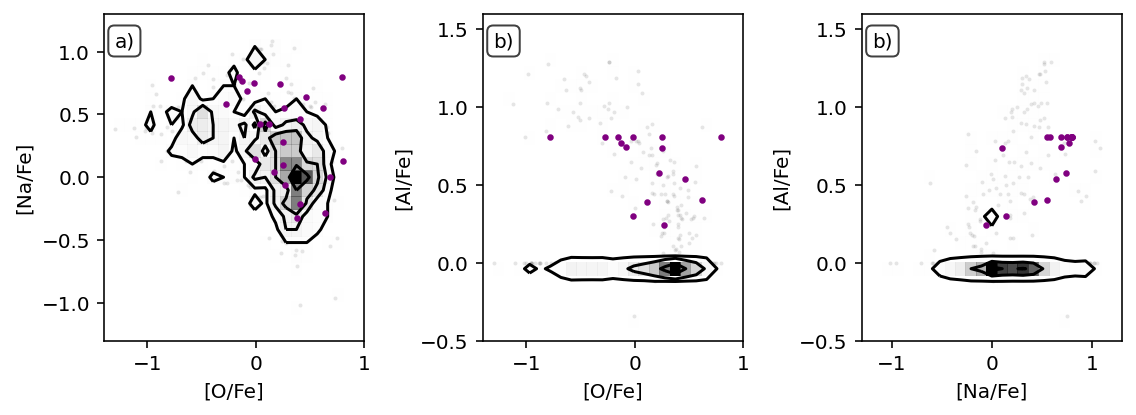

In [29]:
selection = (galah_jp10['flag_sp'] == 0)

f, gs = plt.subplots(1,3,figsize=(8,3))

unflagged = (
    (galah_jp10['flag_sp'] == 0) & 
    (galah_jp10['flag_o_fe'] == 0) & 
    (galah_jp10['flag_na_fe'] == 0)
)

ax = gs[0]
ax.text(0.04,0.9,'a)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.set_xlabel('[O/Fe]')
ax.set_ylabel('[Na/Fe]')

xlims = (-1.4,1.0)
ylims = (-1.3,1.3)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

corner.hist2d(
    jp10['__O_Fe_'],
    jp10['__Na_Fe_'],
    ax=ax,
    bins = 25,
    range=[xlims,ylims],
    zorder=1,
    label = 'JP10'
)
ax.scatter(
    galah_jp10['o_fe'][unflagged],
    galah_jp10['na_fe'][unflagged],
    s = 5,
    c = 'purple',
    zorder=2,
    label='GALAH DR4'
)

unflagged = (
    (galah_jp10['flag_sp'] == 0) & 
    (galah_jp10['flag_o_fe'] == 0) & 
    (galah_jp10['flag_al_fe'] == 0)
)

ax = gs[1]
ax.text(0.04,0.9,'b)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.set_xlabel('[O/Fe]')
ax.set_ylabel('[Al/Fe]')

xlims = (-1.4,1.0)
ylims = (-0.5,1.6)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

corner.hist2d(
    jp10['__O_Fe_'],
    jp10['__Al_Fe_'],
    ax=ax,
    bins = 25,
    range=[xlims,ylims],
    zorder=1,
    label = 'JP10'
)

ax.scatter(
    galah_jp10['o_fe'][unflagged],
    galah_jp10['al_fe'][unflagged],
    s = 5,
    c = 'purple',
    zorder=2,
    label='GALAH DR4'
)

unflagged = (
    (galah_jp10['flag_sp'] == 0) & 
    (galah_jp10['flag_na_fe'] == 0) & 
    (galah_jp10['flag_al_fe'] == 0)
)

ax = gs[2]
ax.text(0.04,0.9,'b)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.set_xlabel('[Na/Fe]')
ax.set_ylabel('[Al/Fe]')

xlims = (-1.3,1.3)
ylims = (-0.5,1.6)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

corner.hist2d(
    jp10['__Na_Fe_'],
    jp10['__Al_Fe_'],
    ax=ax,
    bins = 25,
    range=[xlims,ylims],
    zorder=1,
    label = 'JP10'
)

ax.scatter(
    galah_jp10['na_fe'][unflagged],
    galah_jp10['al_fe'][unflagged],
    s = 5,
    c = 'purple',
    zorder=2,
    label='GALAH DR4'
)

#if index == 0:
#    ax.legend()

plt.tight_layout()

# Carretta (2009)

In [30]:
c09 = Table.read('literature_data/Carretta2009_AandA_505_139_GCs.fits')
galah_c09 = join(c09, galah_dr4_raw, keys='tmass_id')
galah_c09

<Table length=20>
    tmass_id       _RAJ2000     _DEJ2000   ...  rv_dib6613      source_id     
                     deg          deg      ...                                
    bytes17        float64      float64    ...   float32          int64       
---------------- ------------ ------------ ... ----------- -------------------
00223195-7206489   5.63324583 -72.11360833 ...  -22.957977 4689638403539699584
00232094-7205183   5.83738333 -72.08840278 ...  -22.941902 4689638678425880576
00232926-7204483     5.871975 -72.08006944 ...  -22.618317 4689638678425891712
00241686-7211496   6.07032083   -72.197075 ...         nan 4689623049035687040
00243138-7201254    6.1308125 -72.02370556 ...         nan 4689640430772703232
00524054-2638162  13.16891667 -26.63776389 ...  -62.483818 2342903083717827200
00525849-2630555  13.24364167 -26.51539167 ...  -77.101616 2342908340757896704
16230438-2623429 245.76823333 -26.39527778 ...  -4.2430573 6045482411226841472
16231395-2633244 245.80810833 -26.55677778 ...         nan 6045464402412124160
16231459-2630469 245.81081667 -26.51300833 ...  -5.7681656 6045476363912657792
16232950-2629116 245.87294583 -26.48658056 ...         nan 6045466189124452096
16233996-2628490 245.91657917 -26.48028056 ...   -7.881874 6045466640106128768
16234632-2632272 245.94301667 -26.54088889 ...   -4.454422 6045465403155228416
16235358-2634151 245.97324167 -26.57086111 ... -0.12308502 6045462169030878208
17400552-5339493 265.02295833 -53.66369167 ...  -6.6876183 5921748801479852288
17400552-5339493 265.02294583 -53.66369167 ...  -6.6876183 5921748801479852288
17404680-5336326      265.195 -53.60894167 ...  -6.7260303 5921751752101964416
21401982-2313509    325.08255 -23.23083611 ...         nan 6816574863573301888
21403107-2310333 325.12945417   -23.175975 ...         nan 6816580906591320704
21403856-2310587   325.160675 -23.18303333 ...         nan 6816581250188305664

In [31]:
dr60 = Table.read('../observations/dr6.0_220701.fits')
dr60['tmass_id'] = dr60['2mass']

In [32]:
for tmass_id in np.unique(c09['tmass_id']):
    if tmass_id in dr60['tmass_id']:
        print(tmass_id)
        rix = np.where(tmass_id == dr60['tmass_id'])[0]
        if len(rix) > 0:
            for ind,ri in enumerate(rix):
                print(dr60['sobject_id'][ri],dr60['sobject_id'][ri] in galah_dr4_allspec['sobject_id'])

            if len(rix) > 1:
                print('...',dr60['sobject_id'][rix[0]]+1000,dr60['sobject_id'][rix[0]]+1000 in galah_dr4_allspec['sobject_id'])
#     r = repeats['tmass_id'] == tmass_id
#     print(tmass_id)
#     r_i = repeats['sobject_id'][r]
#     for r_ix in r_i:
#         rix = np.where(r_ix == galah_jp10['sobject_id'])[0]
#         if len(rix) > 0:
#             print(r_ix,r_ix in galah_jp10['sobject_id'],int(galah_jp10['snr_px_ccd2'][rix[0]]))
#         else:
#             print(r_ix,r_ix in galah_jp10['sobject_id'])
        
        print()

00223195-7206489
140808004201188 True
211114000101189 False
... 140808004202188 False

00232094-7205183
140824004801118 True

00232926-7204483
140824004801018 True

00241686-7211496
140824004801058 True

00243138-7201254
140824004801322 True

00524054-2638162
140114002401080 True
140115002101080 False
140116002201080 False
... 140114002402080 False

00525849-2630555
140114002401334 True
140115002101334 False
140116002201334 False
... 140114002402334 False

16230438-2623429
210802001601253 True
210803001601253 False
... 210802001602253 False

16231395-2633244
210802001601169 True
210803001601169 False
... 210802001602169 False

16231459-2630469
210802001601194 True
210803001601194 False
... 210802001602194 False

16232950-2629116
210802001601275 True
210803001601275 False
... 210802001602275 False

16233996-2628490
210802001601357 True
210803001601357 False
... 210802001602357 False

16234632-2632272
210802001601116 True
210803001601116 False
... 210802001602116 False

16235358-2634151


104


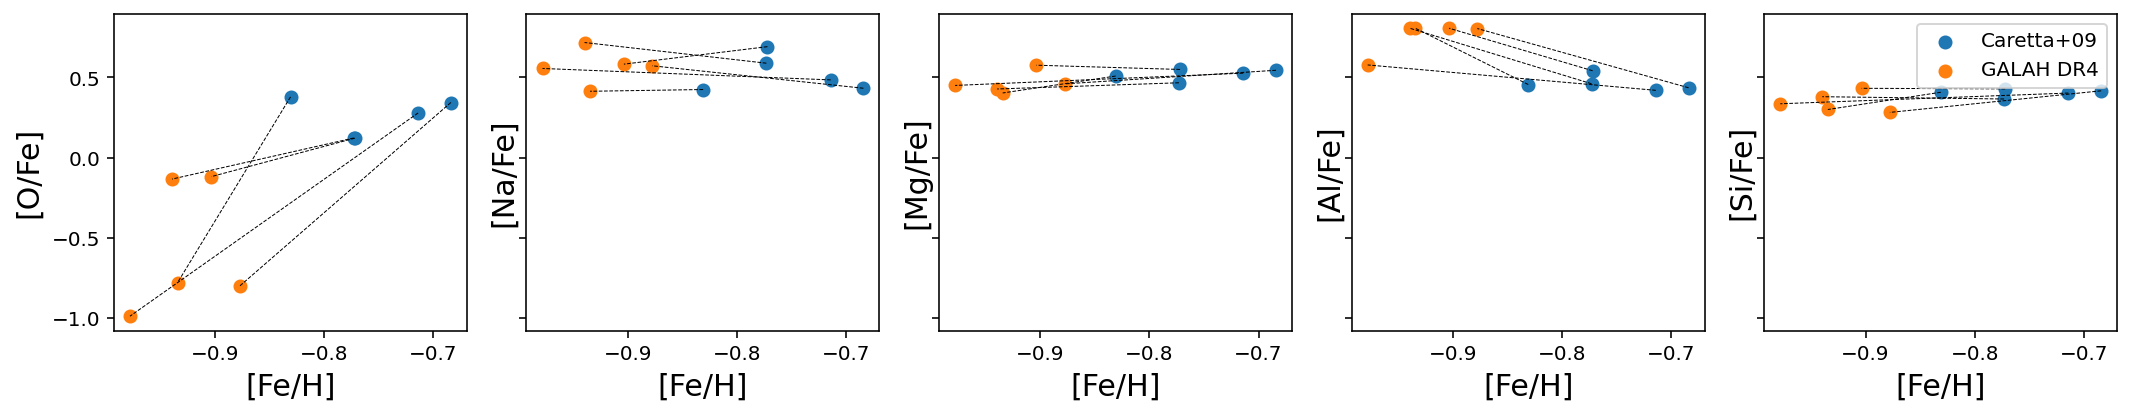

288


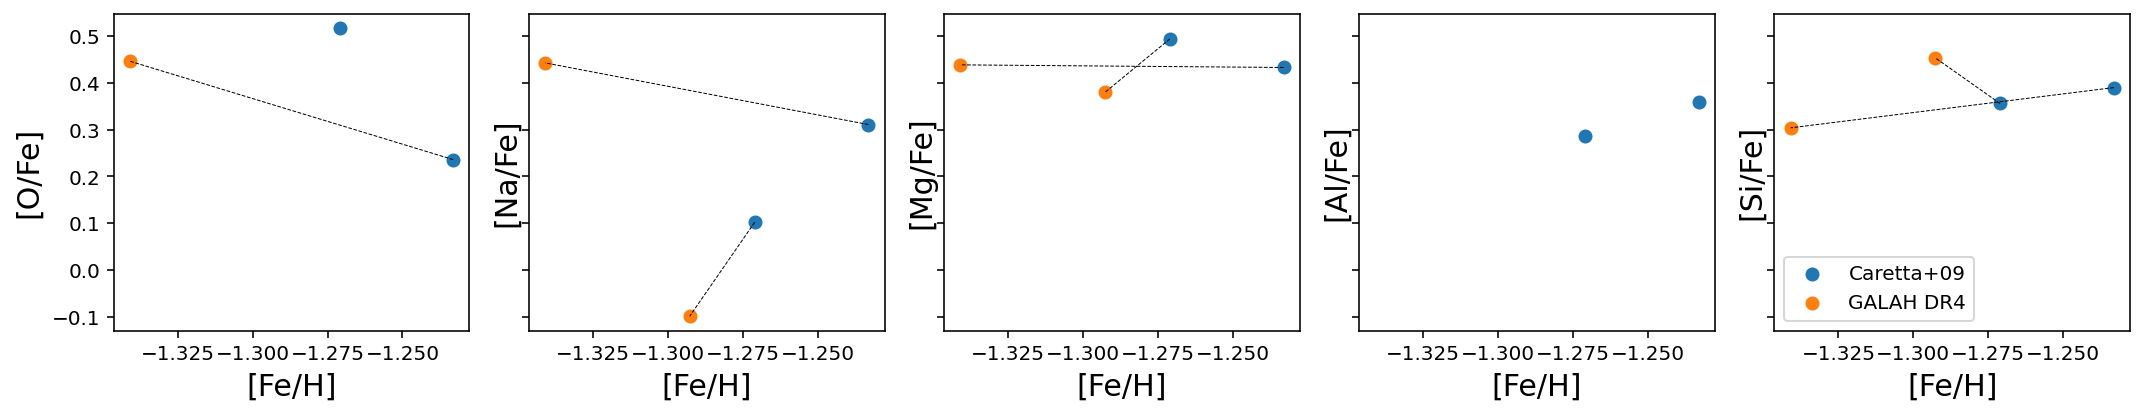

6121


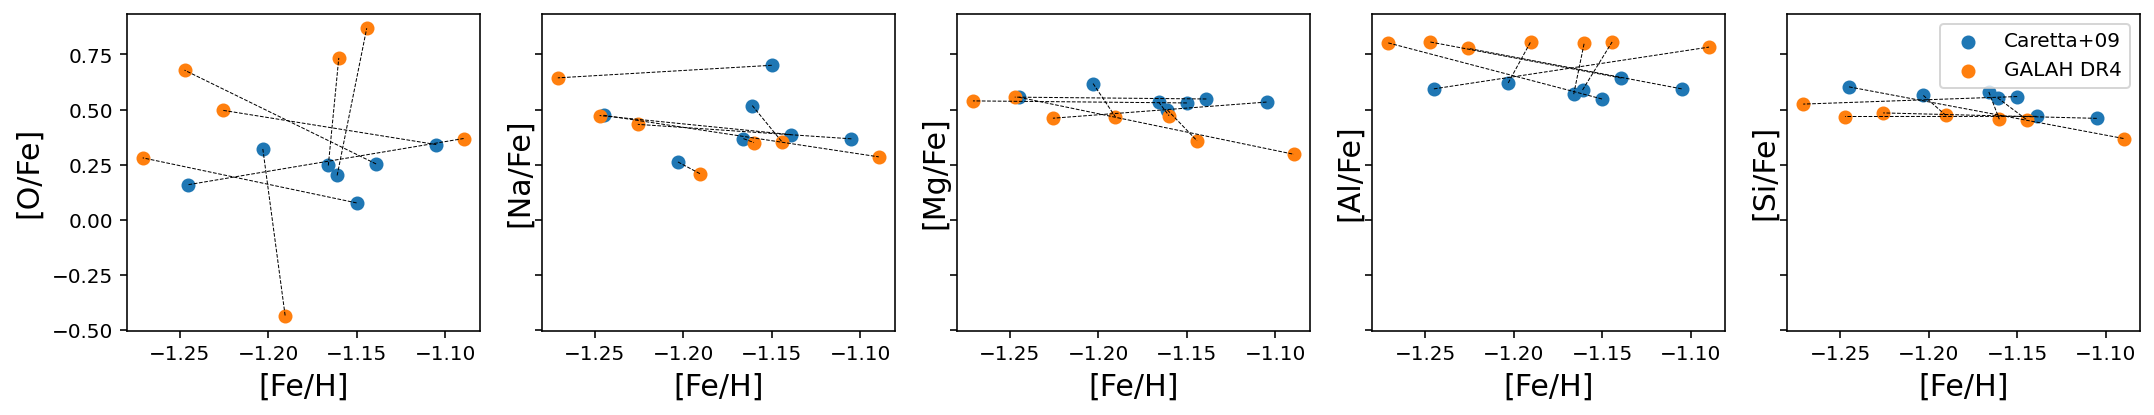

6397


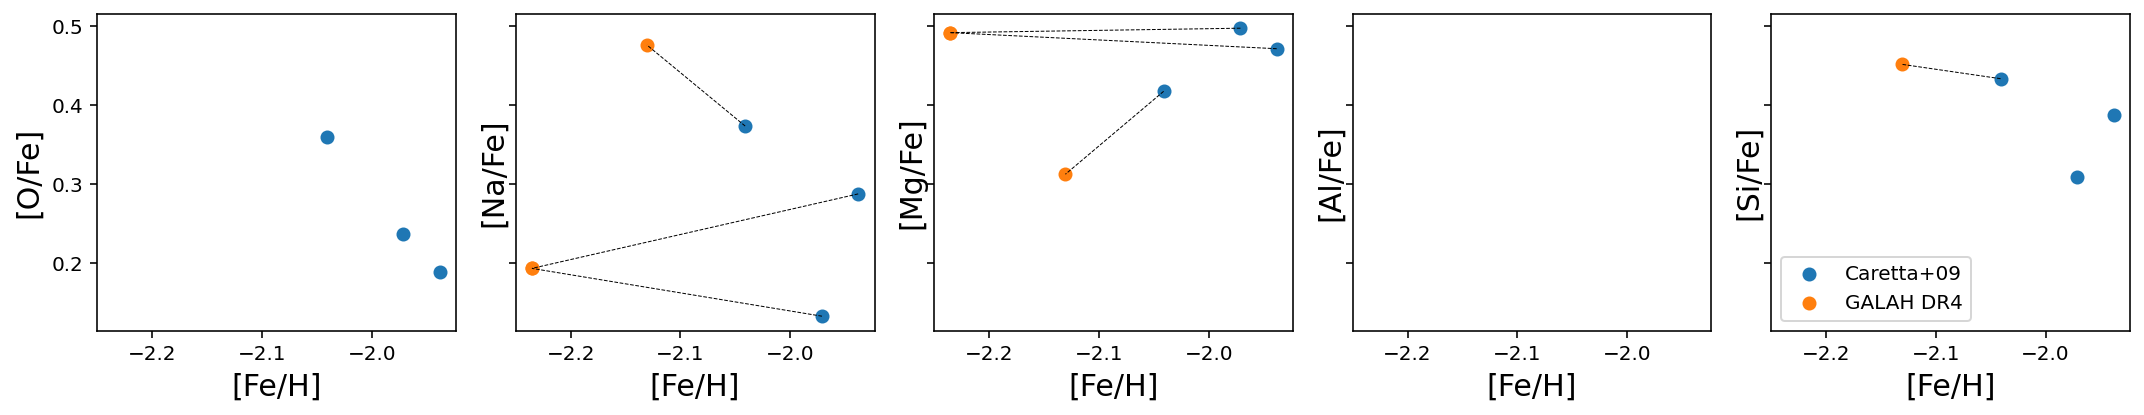

7099


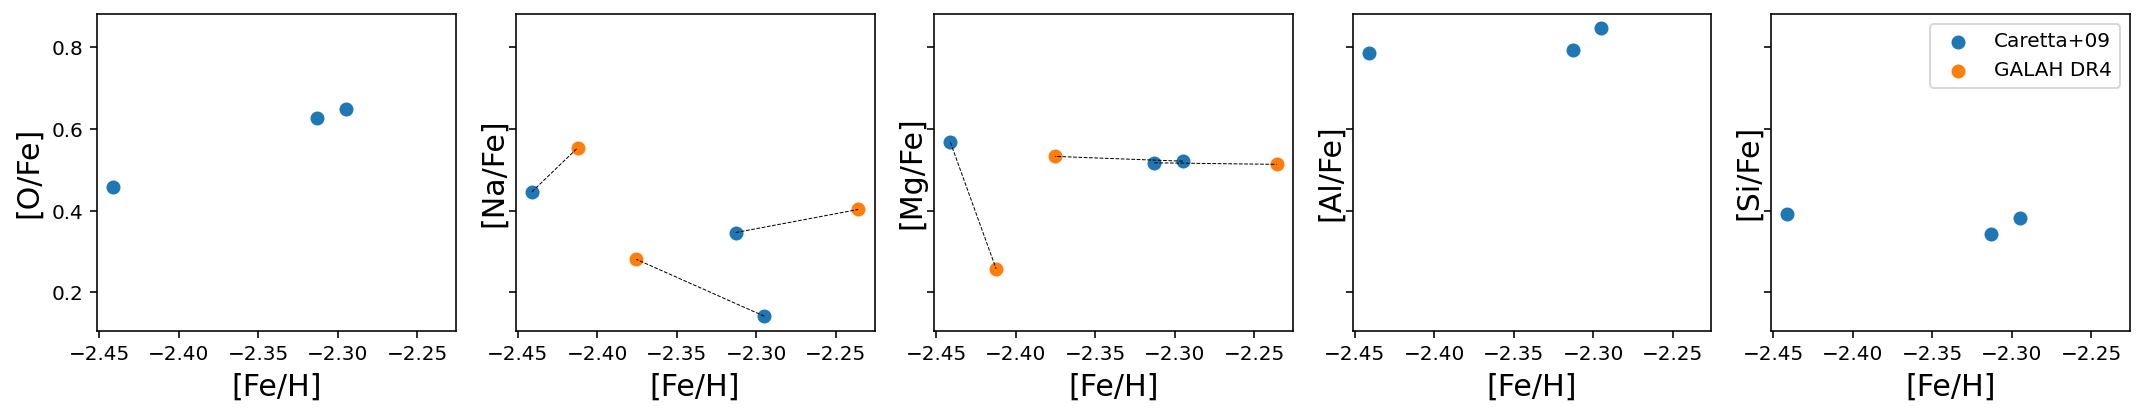

In [33]:
for ngc in np.unique(galah_c09['NGC']):
    
    print(ngc)
    
    in_ngc = galah_c09['NGC'] == ngc
    
#     ax = gs[0]
    
#     ax.scatter(
#         galah_c09['Teff'][in_ngc],
#         galah_c09['logg_1'][in_ngc],
#     )
#     ax.scatter(
#         galah_c09['teff'][in_ngc],
#         galah_c09['logg_2'][in_ngc],
#     )
    
    f, gs = plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=True)

    for i, elem in enumerate(['O','Na','Mg','Al','Si']):
        ax = gs[0+i]
        ax.scatter(
            galah_c09['__FeI_H_'][in_ngc],
            galah_c09['__'+elem+'_Fe_'][in_ngc],
            label = 'Caretta+09'
        )
        ax.scatter(
            galah_c09['fe_h'][in_ngc],
            galah_c09[elem.lower()+'_fe'][in_ngc],
            label = 'GALAH DR4'
        )
        ax.plot(
            [galah_c09['__FeI_H_'][in_ngc],galah_c09['fe_h'][in_ngc]],
            [galah_c09['__'+elem+'_Fe_'][in_ngc],galah_c09[elem.lower()+'_fe'][in_ngc]],
            c='k',ls='dashed',lw=0.5
        )
        ax.set_xlabel('[Fe/H]',fontsize=15)
        ax.set_ylabel('['+elem+'/Fe]',fontsize=15)
        if elem == 'Si':
            ax.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [34]:
c14 = Table.read('literature_data/Cordero2014_ApJ_780_94_47Tuc_2MASS.fits')
galah_c14 = join(c14, galah_dr4_raw, keys='tmass_id')

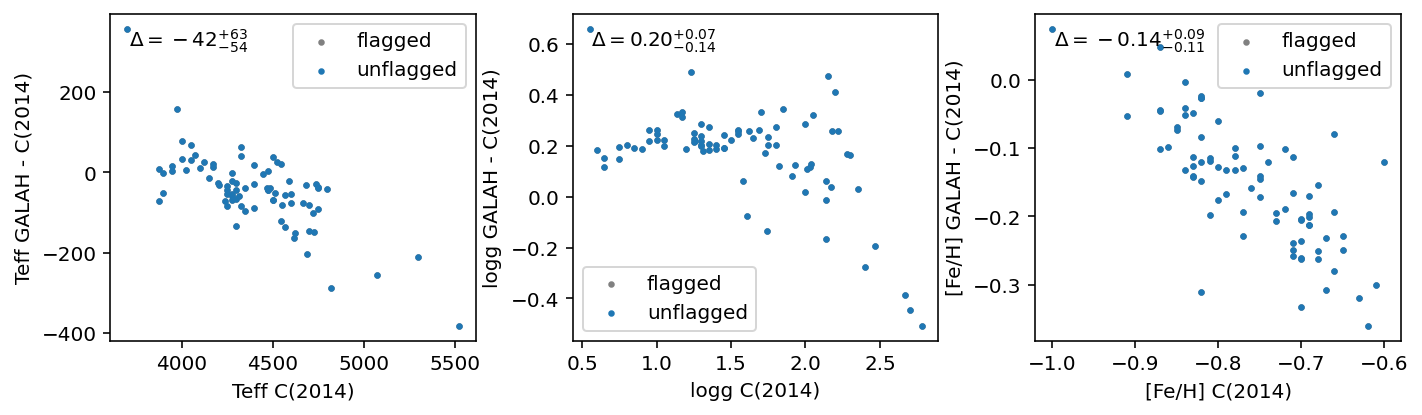

In [35]:
useful = np.isfinite(galah_c14['__Fe_H_']) & (galah_c14['flag_sp_fit'] == 0)

f, gs = plt.subplots(1,3,figsize=(10,3))
ax = gs[0]
label_lit = 'Teff'
label_galah = 'teff'
ax.set_xlabel('Teff C(2014)')
ax.set_ylabel('Teff GALAH - C(2014)')
s = ax.scatter(
    galah_c14[label_lit], galah_c14[label_galah]-galah_c14[label_lit],
    c = 'grey', label = 'flagged',
    s = 5
)
s = ax.scatter(
    galah_c14[label_lit][useful], galah_c14[label_galah][useful]-galah_c14[label_lit][useful],
    c = 'C0', label = 'unflagged',
    s = 5
)
ax.legend()
p16,p50,p84 = np.percentile(galah_c14[label_galah][useful]-galah_c14[label_lit][useful],q=[16,50,84])
ax.text(0.05,0.9,r'$\Delta = '+"{:.0f}".format(p50)+'_{-'+"{:.0f}".format(p50-p16)+'}^{+'+"{:.0f}".format(p84-p50)+'}$',transform=ax.transAxes)

ax = gs[1]
label_lit = 'logg_1'
label_galah = 'logg_2'
ax.set_xlabel('logg C(2014)')
ax.set_ylabel('logg GALAH - C(2014)')
s = ax.scatter(
    galah_c14[label_lit], galah_c14[label_galah]-galah_c14[label_lit],
    c = 'grey', label = 'flagged',
    s = 5
)
s = ax.scatter(
    galah_c14[label_lit][useful], galah_c14[label_galah][useful]-galah_c14[label_lit][useful],
    c = 'C0', label = 'unflagged',
    s = 5
)
ax.legend()
p16,p50,p84 = np.percentile(galah_c14[label_galah][useful]-galah_c14[label_lit][useful],q=[16,50,84])
ax.text(0.05,0.9,r'$\Delta = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',transform=ax.transAxes)
# plt.colorbar(s,ax=ax)

ax = gs[2]
label_lit = '__Fe_H_'
label_galah = 'fe_h'
ax.set_xlabel('[Fe/H] C(2014)')
ax.set_ylabel('[Fe/H] GALAH - C(2014)')
s = ax.scatter(
    galah_c14[label_lit], galah_c14[label_galah]-galah_c14[label_lit],
    c = 'grey', label = 'flagged',
    s = 5
)
s = ax.scatter(
    galah_c14[label_lit][useful], galah_c14[label_galah][useful]-galah_c14[label_lit][useful],
    c = 'C0', label = 'unflagged',
    s = 5
)
ax.legend()
p16,p50,p84 = np.percentile(galah_c14[label_galah][useful]-galah_c14[label_lit][useful],q=[16,50,84])
ax.text(0.05,0.9,r'$\Delta = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',transform=ax.transAxes)
# plt.colorbar(s,ax=ax)
plt.tight_layout(w_pad=0)

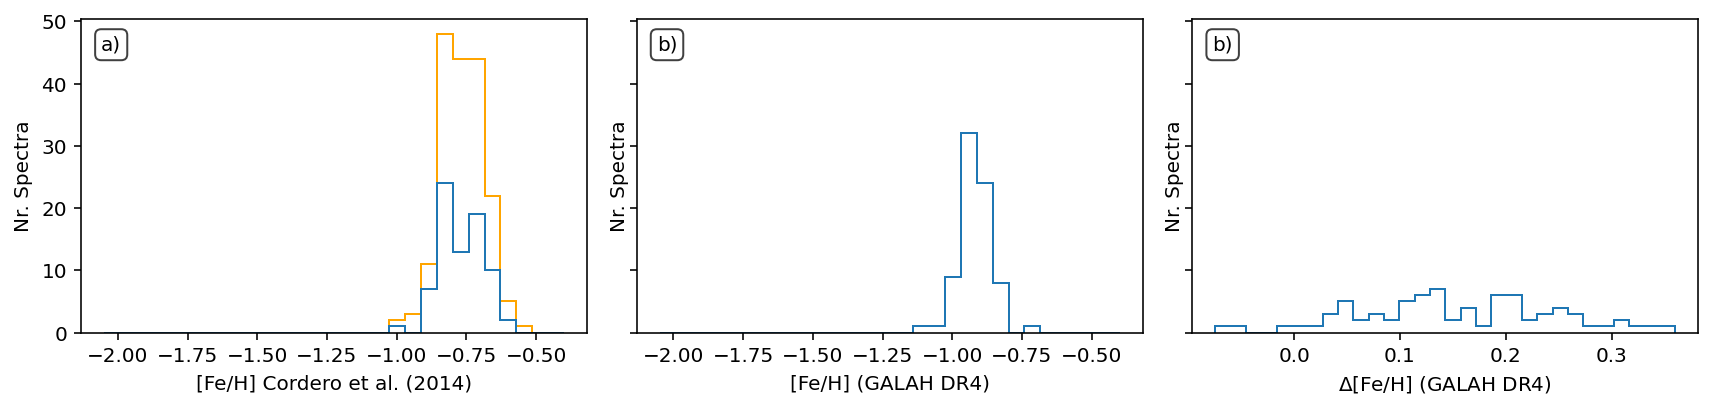

In [36]:
selection = (galah_c14['flag_sp_fit'] == 0) & (galah_c14['flag_fe_h'] == 0)

fe_h_bins = np.linspace(-2.05,-0.4,30)

f, gs = plt.subplots(1,3,figsize=(12,3),sharey=True)
ax = gs[0]
ax.text(0.04,0.9,'a)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.set_xlabel('[Fe/H] Cordero et al. (2014)')
ax.set_ylabel('Nr. Spectra')
ax.hist(
    c14['__Fe_H_'],
    histtype='step',color='orange',
    bins = fe_h_bins
)
ax.hist(
    galah_c14['__Fe_H_'][selection],
    histtype='step',color='C0',
    bins = fe_h_bins
)

ax = gs[1]
ax.set_xlabel('[Fe/H] (GALAH DR4)')
ax.set_ylabel('Nr. Spectra')
ax.text(0.04,0.9,'b)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.hist(
    galah_c14['fe_h'][selection],
    histtype='step',
    bins = fe_h_bins
)

ax = gs[2]
ax.set_xlabel('$\Delta$[Fe/H] (GALAH DR4)')
ax.set_ylabel('Nr. Spectra')
ax.text(0.04,0.9,'b)',ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
ax.hist(
    galah_c14['__Fe_H_'][selection] - galah_c14['fe_h'][selection],
    histtype='step',
    bins = 30#fe_h_bins
)
plt.tight_layout()

In [37]:
c14.keys()

['Inst',
 'r_Star',
 'Star',
 'N',
 'Teff',
 'logg',
 '__Fe_H_',
 'Vt',
 '__O_Fe_',
 '__Na_Fe_',
 '__Al_Fe_',
 '__Si_Fe_',
 '__Ca_Fe_',
 '__Ti_Fe_',
 '__Ni_Fe_',
 '__La_Fe_',
 '__Eu_Fe_',
 'Pop',
 'Dist',
 'SimbadName',
 '_RA',
 '_DE',
 'tmass_id',
 'RAJ2000',
 'DEJ2000',
 'angDist']

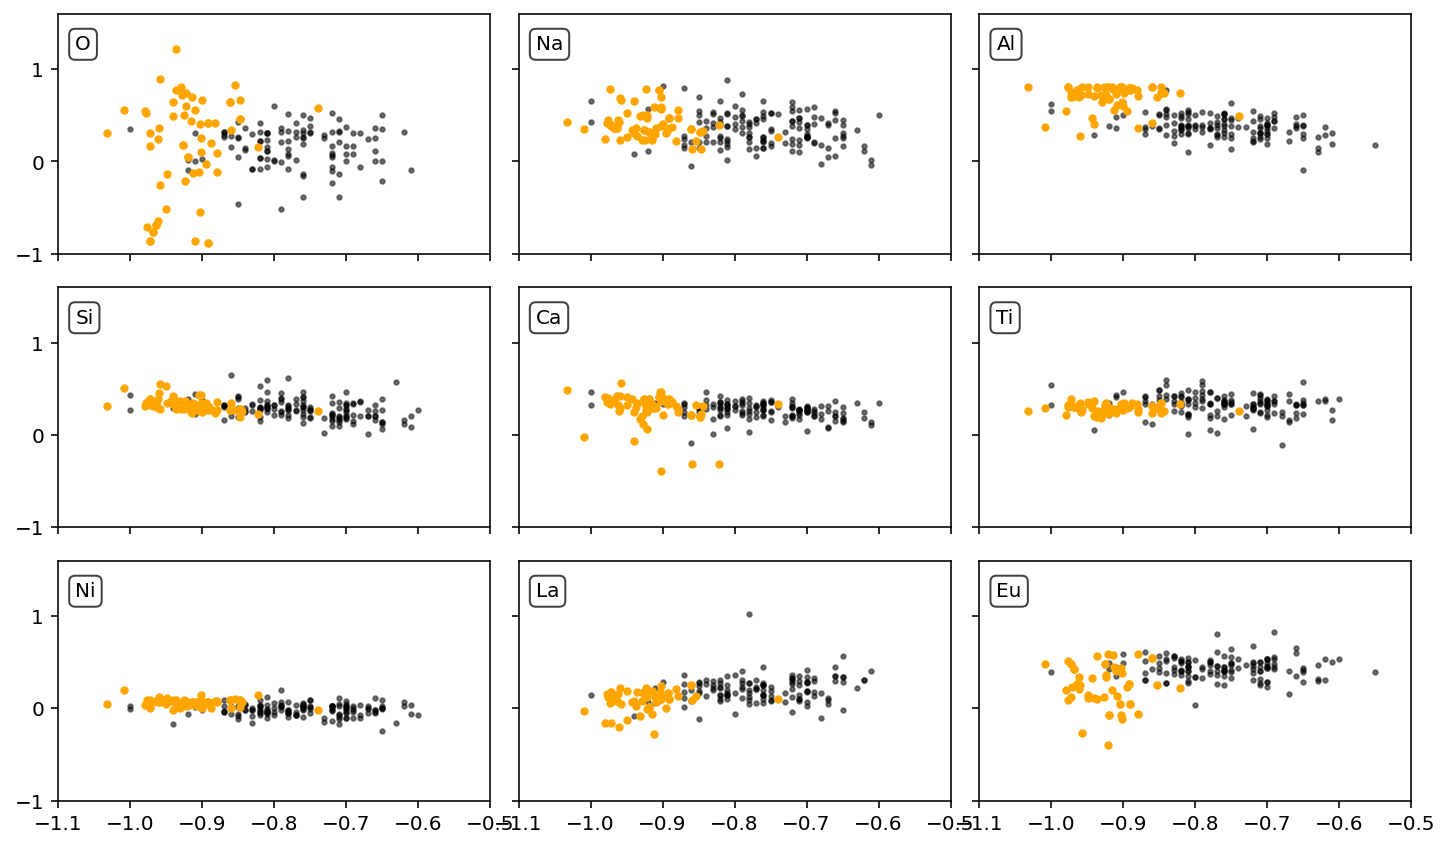

In [38]:
selection = (galah_c14['flag_sp'] == 0)

f, gs = plt.subplots(3,3,figsize=(10,6),sharex=True,sharey=True)

for index, elem in enumerate(['O','Na','Al','Si','Ca','Ti','Ni','La','Eu']):

    unflagged = (
        (galah_c14['flag_sp'] == 0) & 
        (galah_c14['flag_fe_h'] == 0) & 
        (galah_c14['flag_'+elem.lower()+'_fe'] == 0)
    )
    
    ax = gs[int((index - index%3)/3),index%3]
    ax.text(0.04,0.85,elem,ha='left',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    xlims = (-1.1,-0.5)
    ylims = (-1.,1.6)
    
    elem_name = '__'+elem+'_Fe_'

    ax.scatter(
    #corner.hist2d(
        c14['__Fe_H_'],
        c14[elem_name],
        zorder=1,
        s = 5,alpha=0.5,
        c = 'k',
        label = 'C14'
    )

    ax.scatter(
        galah_c14['fe_h'][unflagged],
        galah_c14[elem.lower()+'_fe'][unflagged],
        s = 10,
        c = 'orange',#alpha=0.5,
        zorder=2,
        label='GALAH DR4'
    )
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    #if index == 0:
    #    ax.legend()

plt.tight_layout()